

**מה המחברת עושה:**
1. תמלול עם Whisper → word_count
2. VAD עם Silero → speech_fraction, max_silence_duration
3. סינון (0 מילים או <10% דיבור בלבד)
4. דגימת 50 סגמנטים (10-30-10)
5. הוצאת פיצ'רים קוליים
6. קריאה לLLM להוצאת פיצריים של טקסט

---

## 📦 Step 1: Setup & Installations

In [ ]:
# התקנת ספריות נדרשות
#!pip install -q openai-whisper
#!pip install -q transformers
#!pip install -q librosa
#!pip install -q torchaudio
#!pip install -q tqdm
#!pip install -q pandas

# Silero VAD
#!pip install -q silero-vad

In [ ]:
# ייבוא ספריות
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
import librosa
from pathlib import Path
from tqdm import tqdm
#from transformers import Wav2Vec2FeatureExtractor, WavLMModel
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# בדיקת GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [ ]:
# חיבור ל-Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# הגדרת נתיבים
BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/"

SEGMENTS_FOLDER = f"{BASE_PATH}/DAIC-WOZ/segments/audio/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"

# יצירת מבנה תיקיות
FOLDERS = {
    'transcriptions': f"{OUTPUT_BASE}transcriptions",
    'vad_results': f"{OUTPUT_BASE}vad_results",
    'filtered_segments': f"{OUTPUT_BASE}filtered_segments",
    'wavlm_embeddings': f"{OUTPUT_BASE}wavlm_embeddings",
    'spectrograms': f"{OUTPUT_BASE}spectrograms",
    'metadata': f"{OUTPUT_BASE}metadata",
    'opensmile_features': f"{OUTPUT_BASE}opensmile_features"
}

for folder_name, folder_path in FOLDERS.items():
    os.makedirs(folder_path, exist_ok=True)
    print(f"✓ Created: {folder_name}")

print(f"\n📁 All folders created under: {OUTPUT_BASE}")

✓ Created: transcriptions
✓ Created: vad_results
✓ Created: filtered_segments
✓ Created: wavlm_embeddings
✓ Created: spectrograms
✓ Created: metadata
✓ Created: opensmile_features

📁 All folders created under: /content/drive/MyDrive/try/


## 📋 Step 2: Load Segments Metadata

In [ ]:
def parse_segment_filename(filename):
    """
    מפרסר שם קובץ כמו 483_seg176.wav
    מחזיר: (segment_number, participant_id)
    """
    try:
        # 483_seg176.wav -> 483, seg176.wav
        parts = filename.split('_', 1)
        if len(parts) == 2:
            participant_id = parts[0]  # 483
            seg_part = parts[1]  # seg176.wav
            # חילוץ מספר הסגמנט
            seg_num = int(seg_part.replace('seg', '').replace('.wav', ''))
            return seg_num, participant_id
    except ValueError:
        pass
    return None, None

# טעינת כל קבצי הסגמנטים
all_files = [f for f in os.listdir(SEGMENTS_FOLDER) if '_seg' in f and f.endswith('.wav')]
print(f"Total segment files found: {len(all_files)}")

# ארגון לפי participant
participants_segments = defaultdict(list)
for filename in all_files:
    seg_num, pid = parse_segment_filename(filename)
    if pid:
        participants_segments[pid].append({
            'filename': filename,
            'segment_num': seg_num,
            'filepath': os.path.join(SEGMENTS_FOLDER, filename)
        })

# מיון לפי מספר סגמנט (ציר זמן)
for pid in participants_segments:
    participants_segments[pid].sort(key=lambda x: x['segment_num'])

print(f"\nTotal participants: {len(participants_segments)}")
print(f"\nSegments per participant (sample):")
for pid in list(participants_segments.keys())[:5]:
    print(f"  Participant {pid}: {len(participants_segments[pid])} segments")

Total segment files found: 24610

Total participants: 189

Segments per participant (sample):
  Participant 483: 256 segments
  Participant 484: 145 segments
  Participant 485: 51 segments
  Participant 486: 77 segments
  Participant 487: 154 segments


In [ ]:
import pandas as pd
import os
from collections import defaultdict

# נתיבים
TRANSCRIPTS_FOLDER = f"{BASE_PATH}/DAIC-WOZ/RAW_DATA/transcripts_raw"
SEGMENT_SEC = 10
OVERLAP_SEC = 5
HOP_SEC = SEGMENT_SEC - OVERLAP_SEC  # 5 שניות

def map_transcript_to_segments(participant_id):
    """
    ממפה תמלול מקורי לסגמנטים של 10 שניות
    """
    # טעינת התמלול המקורי
    transcript_path = f"{TRANSCRIPTS_FOLDER}/{participant_id}_TRANSCRIPT.csv"
    if not os.path.exists(transcript_path):
        return None

    df = pd.read_csv(transcript_path, sep='\t')

    # סינון רק Participant
    participant_df = df[df['speaker'] == 'Participant'].copy()

    if len(participant_df) == 0:
        return None

    # חישוב זמן מצטבר באודיו המנוקה
    cumulative_time = 0
    utterances = []

    for idx, row in participant_df.iterrows():
        duration = row['stop_time'] - row['start_time']
        text = row['value'] if pd.notna(row['value']) else ""
        utterances.append({
            'text': str(text),
            'original_start': row['start_time'],
            'original_end': row['stop_time'],
            'clean_start': cumulative_time,
            'clean_end': cumulative_time + duration
        })
        cumulative_time += duration

    total_duration = cumulative_time

    # חישוב מספר הסגמנטים
    num_segments = len(participants_segments.get(participant_id, []))

    # מיפוי לכל סגמנט
    segment_transcripts = []

    for seg_num in range(num_segments):
        seg_start = seg_num * HOP_SEC
        seg_end = seg_start + SEGMENT_SEC

        # מציאת כל ה-utterances שחופפות לסגמנט הזה
        segment_text = []
        for utt in utterances:
            if utt['clean_end'] > seg_start and utt['clean_start'] < seg_end:
                if utt['text']:  # רק אם יש טקסט
                    segment_text.append(utt['text'])

        combined_text = ' '.join(segment_text).strip()
        word_count = len(combined_text.split()) if combined_text else 0

        segment_transcripts.append({
            'participant_id': participant_id,
            'segment_num': seg_num,
            'filename': f"{participant_id}_seg{seg_num:03d}.wav",
            'text': combined_text,
            'word_count': word_count
        })

    return segment_transcripts

# הרצה על כל ה-participants
all_transcripts = []

for pid in tqdm(participants_segments.keys(), desc="Mapping transcripts"):
    result = map_transcript_to_segments(pid)
    if result:
        all_transcripts.extend(result)

# שמירה
transcription_df = pd.DataFrame(all_transcripts)
transcription_df.to_csv(f"{FOLDERS['transcriptions']}/all_transcriptions.csv", index=False)

print(f"\n✓ Mapped {len(transcription_df)} segments")
print(f"Segments with 0 words: {(transcription_df['word_count'] == 0).sum()}")
print(f"\nSample:")
print(transcription_df.head(10))

Mapping transcripts: 100%|██████████| 189/189 [01:07<00:00,  2.79it/s]



✓ Mapped 24610 segments
Segments with 0 words: 6929

Sample:
  participant_id  segment_num        filename  \
0            483            0  483_seg000.wav   
1            483            1  483_seg001.wav   
2            483            2  483_seg002.wav   
3            483            3  483_seg003.wav   
4            483            4  483_seg004.wav   
5            483            5  483_seg005.wav   
6            483            6  483_seg006.wav   
7            483            7  483_seg007.wav   
8            483            8  483_seg008.wav   
9            483            9  483_seg009.wav   

                                                text  word_count  
0  <synch> sure <laughter> mm good i guess new or...          30  
1  uh two thousand five i used to go back often b...          37  
2  uh <laughter> uh well guess you're not program...          22  
3  guess you're not programmed with this knowledg...          39  
4  um hmm where to begin uh just l_a's different ...          3

In [ ]:
# המרה למבנה transcription_results
transcription_results = {}
for _, row in transcription_df.iterrows():
    transcription_results[row['filename']] = {
        'text': row['text'],
        'word_count': row['word_count']
    }

print(f"✓ Loaded {len(transcription_results)} transcriptions into memory")

✓ Loaded 24610 transcriptions into memory


## 🔇 Step 4: VAD (Voice Activity Detection) with Silero

In [ ]:
# טעינת Silero VAD - גרסה מתוקנת
print("Loading Silero VAD model...")
vad_model, utils = torch.hub.load(
    repo_or_dir='snakers4/silero-vad',
    model='silero_vad',
    force_reload=True
)
(get_speech_timestamps, _, _, _, _) = utils
vad_model = vad_model.to(device)
print("✓ Silero VAD loaded")

Loading Silero VAD model...
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
✓ Silero VAD loaded


In [ ]:
import librosa
import numpy as np

def analyze_vad_simple(filepath, target_sr=16000, frame_length=0.025, hop_length=0.010, energy_threshold=0.02):
    """
    VAD פשוט מבוסס אנרגיה
    """
    try:
        # טעינת אודיו
        wav, sr = librosa.load(filepath, sr=target_sr)
        total_duration = len(wav) / sr

        # חישוב RMS energy בחלונות
        frame_samples = int(frame_length * sr)
        hop_samples = int(hop_length * sr)

        rms = librosa.feature.rms(y=wav, frame_length=frame_samples, hop_length=hop_samples)[0]

        # נרמול
        rms_normalized = rms / (rms.max() + 1e-8)

        # זיהוי פריימים עם דיבור
        speech_frames = rms_normalized > energy_threshold

        # חישוב אחוז דיבור
        speech_fraction = speech_frames.sum() / len(speech_frames)

        # חישוב שתיקה מקסימלית
        max_silence = 0
        current_silence = 0

        for is_speech in speech_frames:
            if not is_speech:
                current_silence += hop_length
            else:
                max_silence = max(max_silence, current_silence)
                current_silence = 0
        max_silence = max(max_silence, current_silence)  # שתיקה בסוף

        return speech_fraction, max_silence

    except Exception as e:
        print(f"Error analyzing {filepath}: {e}")
        return 0, 0

# בדיקה
test_pid = list(participants_segments.keys())[0]
test_file = participants_segments[test_pid][0]['filepath']
sf, ms = analyze_vad_simple(test_file)
print(f"Test VAD - Speech fraction: {sf:.2%}, Max silence: {ms:.2f}s")

Test VAD - Speech fraction: 58.64%, Max silence: 0.98s


In [ ]:
# טעינת התמלולים מהקובץ
transcription_df = pd.read_csv(f"{FOLDERS['transcriptions']}/all_transcriptions.csv")
transcription_results = {}
for _, row in transcription_df.iterrows():
    transcription_results[row['filename']] = {
        'text': row['text'],
        'word_count': row['word_count']
    }
print(f"✓ Loaded {len(transcription_results)} transcriptions")


# הגדרת הסגמנטים עם טקסט
all_segments = []
segments_with_text = []

# VAD עם שמירה תוך כדי
vad_csv_path = f"{FOLDERS['vad_results']}/all_vad_results.csv"

# טעינת תוצאות קיימות (אם יש)
vad_results = {}
if os.path.exists(vad_csv_path):
    existing = pd.read_csv(vad_csv_path)
    for _, row in existing.iterrows():
        vad_results[row['filename']] = {
            'speech_fraction': row['speech_fraction'],
            'max_silence_duration': row['max_silence_duration']
        }
    print(f"✓ Loaded {len(vad_results)} existing VAD results")

# סינון רק מה שצריך לעבד
to_process = []
for pid, seg in segments_with_text:
    if seg['filename'] not in vad_results:
        to_process.append((pid, seg))

print(f"To process: {len(to_process)} segments (skipping {len(segments_with_text) - len(to_process)} already done)")

# עיבוד עם שמירה כל 500
for i, (pid, seg) in enumerate(tqdm(to_process, desc="VAD Analysis")):
    filename = seg['filename']
    speech_fraction, max_silence = analyze_vad_simple(seg['filepath'])
    vad_results[filename] = {
        'speech_fraction': speech_fraction,
        'max_silence_duration': max_silence
    }

    # שמירה כל 500 סגמנטים
    if (i + 1) % 500 == 0:
        vad_data = []
        for pid2 in participants_segments:
            for seg2 in participants_segments[pid2]:
                fn = seg2['filename']
                if fn in vad_results:
                    vad_data.append({
                        'participant_id': pid2,
                        'filename': fn,
                        'segment_num': seg2['segment_num'],
                        'speech_fraction': vad_results[fn]['speech_fraction'],
                        'max_silence_duration': vad_results[fn]['max_silence_duration']
                    })
        pd.DataFrame(vad_data).to_csv(vad_csv_path, index=False)
        print(f"\n💾 Saved {len(vad_data)} results")

# שמירה סופית
vad_data = []
for pid in participants_segments:
    for seg in participants_segments[pid]:
        fn = seg['filename']
        vad = vad_results.get(fn, {'speech_fraction': 0, 'max_silence_duration': 10})
        vad_data.append({
            'participant_id': pid,
            'filename': fn,
            'segment_num': seg['segment_num'],
            'speech_fraction': vad['speech_fraction'],
            'max_silence_duration': vad['max_silence_duration']
        })

pd.DataFrame(vad_data).to_csv(vad_csv_path, index=False)
print(f"\n✓ Done! Total: {len(vad_data)} segments")

✓ Loaded 24610 transcriptions
✓ Loaded 24610 existing VAD results
To process: 0 segments (skipping 0 already done)


VAD Analysis: 0it [00:00, ?it/s]


✓ Done! Total: 24610 segments


## 🔍 Step 5: Filtering & Selection (10-30-10)

In [ ]:
# בדיקה - מה הפורמטים?
test_pid = '300'  # אחד שנכשל

print("=== Filenames in participants_segments ===")
if test_pid in participants_segments:
    for seg in participants_segments[test_pid][:3]:
        print(f"  {seg['filename']}")

print("\n=== Keys in transcription_results (sample) ===")
trans_keys = list(transcription_results.keys())[:10]
for k in trans_keys:
    print(f"  {k}")

print("\n=== Keys in vad_results (sample) ===")
vad_keys = list(vad_results.keys())[:10]
for k in vad_keys:
    print(f"  {k}")

# בדיקה ספציפית
test_filename = participants_segments[test_pid][0]['filename'] if test_pid in participants_segments else None
print(f"\n=== Test lookup for {test_filename} ===")
print(f"In transcription_results: {test_filename in transcription_results}")
print(f"In vad_results: {test_filename in vad_results}")

=== Filenames in participants_segments ===
  300_seg000.wav
  300_seg001.wav
  300_seg002.wav

=== Keys in transcription_results (sample) ===
  483_seg000.wav
  483_seg001.wav
  483_seg002.wav
  483_seg003.wav
  483_seg004.wav
  483_seg005.wav
  483_seg006.wav
  483_seg007.wav
  483_seg008.wav
  483_seg009.wav

=== Keys in vad_results (sample) ===
  483_seg000.wav
  483_seg001.wav
  483_seg002.wav
  483_seg003.wav
  483_seg004.wav
  483_seg005.wav
  483_seg006.wav
  483_seg007.wav
  483_seg008.wav
  483_seg009.wav

=== Test lookup for 300_seg000.wav ===
In transcription_results: True
In vad_results: True


In [ ]:
# מציאת סגמנטים שצריכים VAD מחדש
need_vad = []
for pid in participants_segments:
    for seg in participants_segments[pid]:
        filename = seg['filename']
        word_count = transcription_results.get(filename, {}).get('word_count', 0)
        speech_fraction = vad_results.get(filename, {}).get('speech_fraction', 0)

        # יש מילים אבל VAD = 0 -> צריך לחשב מחדש
        if word_count > 0 and speech_fraction == 0:
            need_vad.append((pid, seg))

print(f"Segments needing VAD recalculation: {len(need_vad)}")

Segments needing VAD recalculation: 2


In [ ]:
# הרצת VAD על הסגמנטים החסרים
vad_csv_path = f"{FOLDERS['vad_results']}/all_vad_results.csv"

print(f"Running VAD on {len(need_vad)} segments...")

for i, (pid, seg) in enumerate(tqdm(need_vad, desc="VAD Recalculation")):
    filename = seg['filename']
    speech_fraction, max_silence = analyze_vad_simple(seg['filepath'])
    vad_results[filename] = {
        'speech_fraction': speech_fraction,
        'max_silence_duration': max_silence
    }

    # שמירה כל 500
    if (i + 1) % 500 == 0:
        vad_data = []
        for pid2 in participants_segments:
            for seg2 in participants_segments[pid2]:
                fn = seg2['filename']
                vad = vad_results.get(fn, {'speech_fraction': 0, 'max_silence_duration': 10})
                vad_data.append({
                    'participant_id': pid2,
                    'filename': fn,
                    'segment_num': seg2['segment_num'],
                    'speech_fraction': vad['speech_fraction'],
                    'max_silence_duration': vad['max_silence_duration']
                })
        pd.DataFrame(vad_data).to_csv(vad_csv_path, index=False)
        print(f"\n💾 Saved checkpoint at {i+1}")

# שמירה סופית
vad_data = []
for pid in participants_segments:
    for seg in participants_segments[pid]:
        fn = seg['filename']
        vad = vad_results.get(fn, {'speech_fraction': 0, 'max_silence_duration': 10})
        vad_data.append({
            'participant_id': pid,
            'filename': fn,
            'segment_num': seg['segment_num'],
            'speech_fraction': vad['speech_fraction'],
            'max_silence_duration': vad['max_silence_duration']
        })
pd.DataFrame(vad_data).to_csv(vad_csv_path, index=False)

print(f"\n✓ Done! Updated {len(need_vad)} segments")

Running VAD on 2 segments...


VAD Recalculation: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]



✓ Done! Updated 2 segments


In [ ]:
# קריטריוני סינון
MIN_WORDS = 1  # לפחות מילה אחת (0 מילים = נפסל)
MIN_SPEECH_FRACTION = 0.10  # לפחות 10% דיבור
MIN_VALID_SEGMENTS = 10  # מינימום סגמנטים כשרים לparticipant
TARGET_SEGMENTS = 50

def filter_and_select_segments(pid, segments, transcriptions, vad_results):
    """מסנן ובוחר 50 סגמנטים בשיטת 10-30-10"""
    valid_segments = []

    for seg in segments:
        filename = seg['filename']
        trans = transcriptions.get(filename, {'word_count': 0, 'text': ''})
        vad = vad_results.get(filename, {'speech_fraction': 0, 'max_silence_duration': 10})

        word_count = trans['word_count']
        speech_fraction = vad['speech_fraction']

        # סינון רק מקרי קיצון
        if word_count >= MIN_WORDS and speech_fraction >= MIN_SPEECH_FRACTION:
            valid_segments.append({
                **seg,
                'word_count': word_count,
                'text': trans['text'],
                'speech_fraction': speech_fraction,
                'max_silence_duration': vad['max_silence_duration']
            })

    # בדיקת מינימום
    if len(valid_segments) < MIN_VALID_SEGMENTS:
        return None, f"Only {len(valid_segments)} valid segments"

    # בחירת 50 בשיטת 10-30-10
    n_valid = len(valid_segments)

    if n_valid <= TARGET_SEGMENTS:
        selected = valid_segments
    else:
        top_10 = valid_segments[:10]
        bottom_10 = valid_segments[-10:]
        middle_part = valid_segments[10:-10]
        indices = np.linspace(0, len(middle_part)-1, 30).astype(int)
        middle_30 = [middle_part[i] for i in indices]
        selected = top_10 + middle_30 + bottom_10

    return selected, None

# סינון ובחירה
selected_segments = {}
excluded_participants = []

for pid in tqdm(participants_segments.keys(), desc="Filtering"):
    segments = participants_segments[pid]
    selected, error = filter_and_select_segments(pid, segments, transcription_results, vad_results)

    if error:
        excluded_participants.append({'participant_id': pid, 'reason': error})
    else:
        selected_segments[pid] = selected

print(f"\n✓ Results:")
print(f"  Valid participants: {len(selected_segments)}")
print(f"  Excluded: {len(excluded_participants)}")

if excluded_participants:
    print(f"\nExcluded participants:")
    for ex in excluded_participants:
        print(f"  {ex['participant_id']}: {ex['reason']}")

Filtering: 100%|██████████| 189/189 [00:00<00:00, 3625.85it/s]


✓ Results:
  Valid participants: 189
  Excluded: 0


In [ ]:
# שמירת רשימת הסגמנטים הנבחרים
selected_data = []
for pid, segments in selected_segments.items():
    for i, seg in enumerate(segments):
        selected_data.append({
            'participant_id': pid,
            'position_in_50': i,
            'filename': seg['filename'],
            'segment_num': seg['segment_num'],
            'word_count': seg['word_count'],
            'speech_fraction': seg['speech_fraction'],
            'max_silence_duration': seg['max_silence_duration'],
            'text': seg['text']
        })

selected_df = pd.DataFrame(selected_data)
selected_df.to_csv(f"{FOLDERS['filtered_segments']}/selected_segments.csv", index=False)
print(f"✓ Selected segments saved: {len(selected_df)} total")

# סטטיסטיקות
print(f"\nStatistics:")
print(f"  - Segments per participant: min={selected_df.groupby('participant_id').size().min()}, "
      f"max={selected_df.groupby('participant_id').size().max()}, "
      f"mean={selected_df.groupby('participant_id').size().mean():.1f}")

✓ Selected segments saved: 9032 total

Statistics:
  - Segments per participant: min=12, max=50, mean=47.8


In [ ]:
# חישוב features ברמת participant
participant_features = {}

for pid in participants_segments:
    segments = participants_segments[pid]

    num_silent = 0
    total_speech_time = 0
    total_time = 0

    for seg in segments:
        filename = seg['filename']
        word_count = transcription_results.get(filename, {}).get('word_count', 0)
        speech_fraction = vad_results.get(filename, {}).get('speech_fraction', 0)

        # סגמנט ריק = 0 מילים
        if word_count == 0:
            num_silent += 1

        # יחס דיבור/שתיקה (כל סגמנט = 10 שניות)
        total_speech_time += speech_fraction * 10  # שניות דיבור בסגמנט
        total_time += 10  # כל סגמנט = 10 שניות

    overall_speech_ratio = total_speech_time / total_time if total_time > 0 else 0
    overall_silence_ratio = 1 - overall_speech_ratio

    participant_features[pid] = {
        'num_segments': len(segments),
        'num_silent_segments': num_silent,
        'silent_segment_ratio': num_silent / len(segments) if segments else 0,
        'overall_speech_ratio': overall_speech_ratio,
        'overall_silence_ratio': overall_silence_ratio
    }

# הצגת סטטיסטיקות
features_df = pd.DataFrame.from_dict(participant_features, orient='index')
features_df.index.name = 'participant_id'

print("=== Participant-level Features ===")
print(f"\nSilent Segments:")
print(f"  Mean: {features_df['num_silent_segments'].mean():.1f}")
print(f"  Min: {features_df['num_silent_segments'].min()}")
print(f"  Max: {features_df['num_silent_segments'].max()}")

print(f"\nOverall Silence Ratio:")
print(f"  Mean: {features_df['overall_silence_ratio'].mean():.2%}")
print(f"  Min: {features_df['overall_silence_ratio'].min():.2%}")
print(f"  Max: {features_df['overall_silence_ratio'].max():.2%}")

# שמירה
features_df.to_csv(f"{FOLDERS['metadata']}/participant_speech_features.csv")
print(f"\n✓ Saved to participant_speech_features.csv")

# דוגמה
print("\nSample:")
print(features_df.head(10))

=== Participant-level Features ===

Silent Segments:
  Mean: 36.7
  Min: 6
  Max: 102

Overall Silence Ratio:
  Mean: 53.94%
  Min: 10.07%
  Max: 90.60%

✓ Saved to participant_speech_features.csv

Sample:
                num_segments  num_silent_segments  silent_segment_ratio  \
participant_id                                                            
483                      256                   90              0.351562   
484                      145                   35              0.241379   
485                       51                   11              0.215686   
486                       77                   24              0.311688   
487                      154                   38              0.246753   
488                      116                   31              0.267241   
489                       72                   38              0.527778   
490                       74                   36              0.486486   
491                      105                

## 🧠 Step 6: WavLM Embeddings (Layers 4-9)

In [ ]:
# טעינת WavLM-Large
print("Loading WavLM-Large model...")
wavlm_processor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large")
wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-large")
wavlm_model = wavlm_model.to(device)
wavlm_model.eval()
print(f"✓ WavLM-Large loaded ({wavlm_model.config.num_hidden_layers} layers)")

Loading WavLM-Large model...


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

✓ WavLM-Large loaded (24 layers)


In [ ]:
def extract_wavlm_layers(filepath, model, processor, target_sr=16000, layers=[4,5,6,7,8,9]):
    """
    מחלץ embeddings משכבות 4-9 של WavLM
    """
    try:
        # טעינת אודיו עם librosa
        wav, sr = librosa.load(filepath, sr=target_sr)

        # המרה ל-tensor
        inputs = processor(
            wav,
            sampling_rate=target_sr,
            return_tensors="pt",
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass עם output_hidden_states
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        hidden_states = outputs.hidden_states

        # חילוץ שכבות 4-9
        selected_layers = [hidden_states[i].squeeze(0) for i in layers]  # כל אחד (499, 1024)

        # Mean+Std pooling על ציר הזמן
        layer_means = torch.stack([layer.mean(dim=0) for layer in selected_layers])  # (6, 1024)
        layer_stds = torch.stack([layer.std(dim=0) for layer in selected_layers])    # (6, 1024)

        # לweighted sum - שומרים mean per layer (המודל ילמד את המשקלות)
        all_layers_separate = torch.stack([layer.mean(dim=0) for layer in selected_layers])  # (6, 1024)

        return {
            'layer_embeddings': layer_means.cpu(),       # (6, 1024)
            'layer_stds': layer_stds.cpu(),              # (6, 1024)
            'all_layers_separate': all_layers_separate.cpu()  # (6, 1024)
        }

    except Exception as e:
        print(f"Error extracting WavLM from {filepath}: {e}")
        return None

# בדיקה
test_pid = list(selected_segments.keys())[0]
test_file = selected_segments[test_pid][0]['filepath']
test_emb = extract_wavlm_layers(test_file, wavlm_model, wavlm_processor)

if test_emb:
    print(f"✓ Test embedding shapes:")
    print(f"  - layer_embeddings: {test_emb['layer_embeddings'].shape}")
    print(f"  - layer_stds: {test_emb['layer_stds'].shape}")
    print(f"  - all_layers_separate: {test_emb['all_layers_separate'].shape}")

✓ Test embedding shapes:
  - layer_embeddings: torch.Size([6, 1024])
  - layer_stds: torch.Size([6, 1024])
  - all_layers_separate: torch.Size([6, 1024])


In [ ]:
# חילוץ WavLM עם שמירה תוך כדי
print("Extracting WavLM embeddings...")

wavlm_save_path = f"{FOLDERS['wavlm_embeddings']}/wavlm_checkpoint.pt"

# טעינת checkpoint קיים
if os.path.exists(wavlm_save_path):
    checkpoint = torch.load(wavlm_save_path)
    wavlm_embeddings = checkpoint['embeddings']
    processed_pids = set(checkpoint['processed_pids'])
    print(f"✓ Loaded checkpoint: {len(processed_pids)} participants already done")
else:
    wavlm_embeddings = {}
    processed_pids = set()

# רשימת participants לעיבוד
all_pids = list(selected_segments.keys())
to_process = [pid for pid in all_pids if pid not in processed_pids]
print(f"To process: {len(to_process)} participants")

for i, pid in enumerate(tqdm(to_process, desc="WavLM Extraction")):
    segments = selected_segments[pid]

    embeddings_list = []
    for seg in segments:
        emb = extract_wavlm_layers(seg['filepath'], wavlm_model, wavlm_processor)
        if emb is not None:
            combined = torch.cat([emb['layer_embeddings'], emb['layer_stds']], dim=1)
            embeddings_list.append(combined)

    if len(embeddings_list) == 0:
        processed_pids.add(pid)
        continue

    embeddings_with_stats = torch.stack(embeddings_list)
    n_segments = embeddings_with_stats.shape[0]

    # Padding/Truncation ל-50
    if n_segments < TARGET_SEGMENTS:
        pad_size = TARGET_SEGMENTS - n_segments
        padding = torch.zeros(pad_size, 6, 2048)
        embeddings_with_stats = torch.cat([embeddings_with_stats, padding], dim=0)
        mask = torch.cat([torch.ones(n_segments), torch.zeros(pad_size)])
    elif n_segments > TARGET_SEGMENTS:
        embeddings_with_stats = embeddings_with_stats[:TARGET_SEGMENTS]
        mask = torch.ones(TARGET_SEGMENTS)
    else:
        mask = torch.ones(TARGET_SEGMENTS)

    wavlm_embeddings[pid] = {
        'embeddings': embeddings_with_stats,
        'mask': mask,
        'n_valid': min(n_segments, TARGET_SEGMENTS)
    }
    processed_pids.add(pid)

    # שמירה כל 10 participants
    if (i + 1) % 10 == 0:
        torch.save({
            'embeddings': wavlm_embeddings,
            'processed_pids': list(processed_pids)
        }, wavlm_save_path)
        print(f"\n💾 Saved checkpoint: {len(processed_pids)} participants")

# שמירה סופית
torch.save({
    'embeddings': wavlm_embeddings,
    'processed_pids': list(processed_pids)
}, wavlm_save_path)

print(f"\n✓ Done! Extracted embeddings for {len(wavlm_embeddings)} participants")
sample_pid = list(wavlm_embeddings.keys())[0]
print(f"Sample shape: {wavlm_embeddings[sample_pid]['embeddings'].shape}")

Extracting WavLM embeddings...
✓ Loaded checkpoint: 189 participants already done
To process: 0 participants


WavLM Extraction: 0it [00:00, ?it/s]



✓ Done! Extracted embeddings for 189 participants
Sample shape: torch.Size([50, 6, 2048])


Loading WavLM embeddings...
✓ Loaded 189 participants
Sample structure for participant 483:
  - embeddings shape: torch.Size([50, 6, 2048])
  - mask shape: torch.Size([50])
  - n_valid: 50
✓ Loaded labels for 189 participants
✓ Loaded silence features

Extracting features from saved embeddings...
✓ Extracted 43 features for 189 participants

Final dataset: 189 participants
  - Depressed (1): 56
  - Not Depressed (0): 133

📊 STATISTICAL COMPARISON: Depressed vs Not Depressed

Feature                                    Dep     NotDep    Diff%   Cohen d    p-value
------------------------------------------------------------------------------------------
silence_num_silent_segments            42.8750    34.0451   +25.9%   +0.455    0.0027** ↑
silence_overall_silence_ratio           0.5768     0.5237   +10.1%   +0.399    0.0162* ↑
silence_overall_speech_ratio            0.4232     0.4763   -11.1%   -0.399    0.0162* ↓
silence_silent_segment_ratio            0.3196     0.2861   +11.7%   +0.2

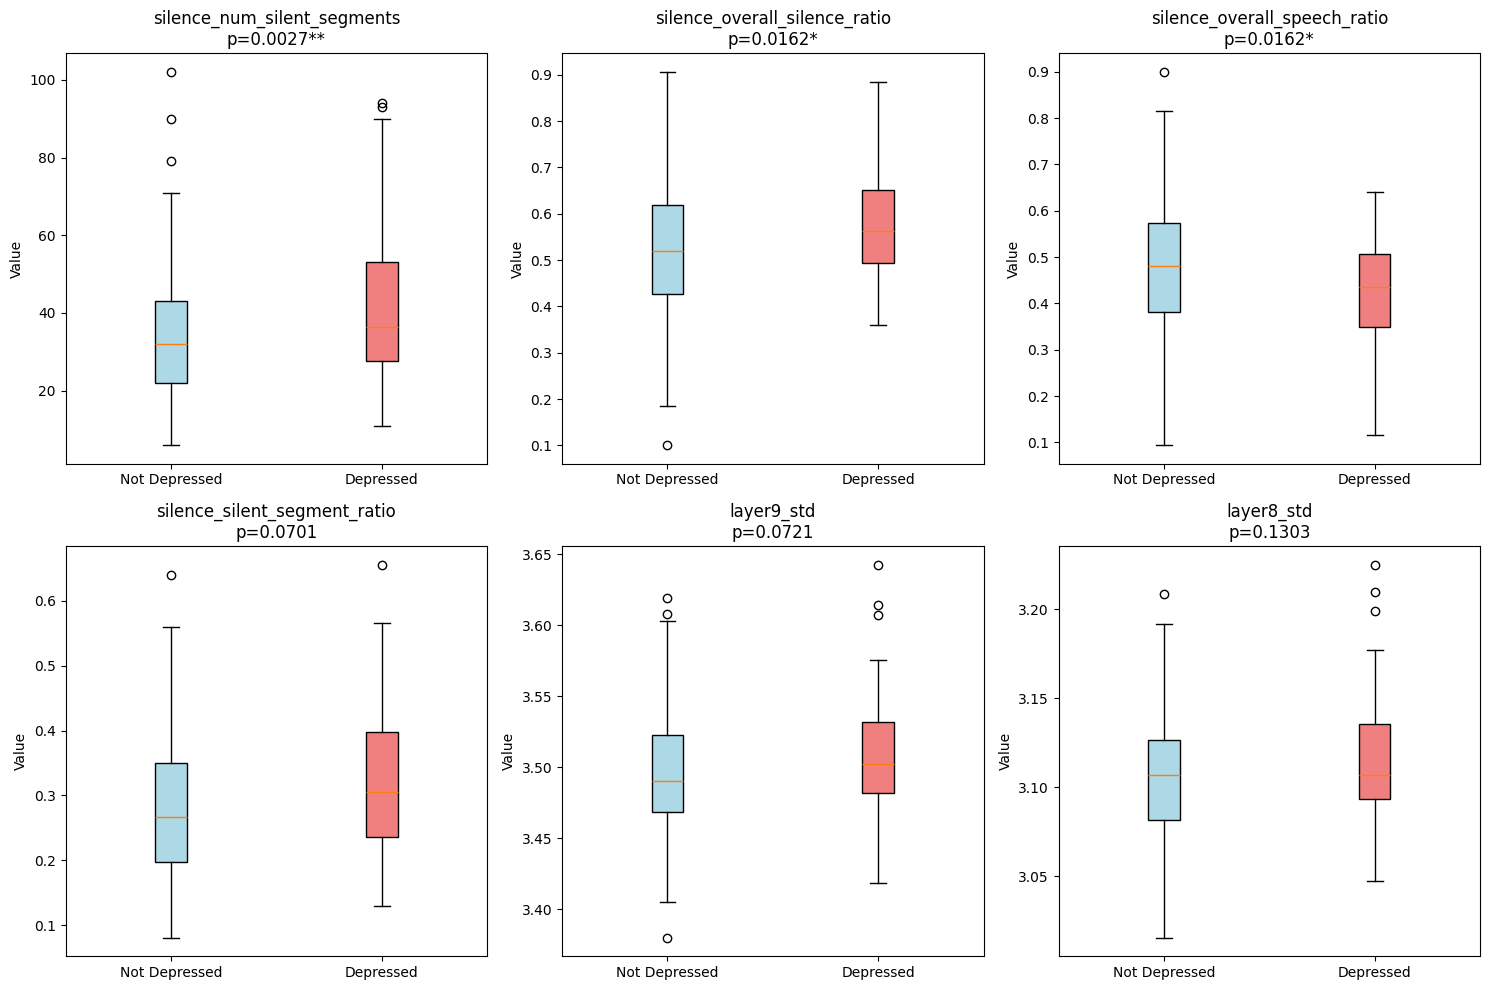


✓ Plot saved to: wavlm_features_boxplots.png


In [ ]:
# ========================================
# חילוץ Features מ-WavLM Embeddings קיימים
# + השוואה סטטיסטית בין קבוצות
# ========================================

import torch
import pandas as pd
import numpy as np
from scipy import stats

# ========================================
# 1. הגדרות ונתיבים
# ========================================

BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"

FOLDERS = {
    'wavlm_embeddings': f"{OUTPUT_BASE}wavlm_embeddings",
    'metadata': f"{OUTPUT_BASE}metadata",
}

# ========================================
# 2. טעינת נתונים
# ========================================

# טעינת WavLM embeddings
print("Loading WavLM embeddings...")
wavlm_checkpoint = torch.load(f"{FOLDERS['wavlm_embeddings']}/wavlm_checkpoint.pt")
wavlm_embeddings = wavlm_checkpoint['embeddings']
print(f"✓ Loaded {len(wavlm_embeddings)} participants")

# בדיקת מבנה
sample_pid = list(wavlm_embeddings.keys())[0]
print(f"Sample structure for participant {sample_pid}:")
print(f"  - embeddings shape: {wavlm_embeddings[sample_pid]['embeddings'].shape}")
print(f"  - mask shape: {wavlm_embeddings[sample_pid]['mask'].shape}")
print(f"  - n_valid: {wavlm_embeddings[sample_pid]['n_valid']}")

# טעינת labels
labels_df = pd.read_csv(f"{BASE_PATH}DAIC-WOZ/metadata/labels_all.csv")
labels_dict = dict(zip(labels_df['Participant_ID'].astype(str), labels_df['PHQ_Binary']))
print(f"✓ Loaded labels for {len(labels_dict)} participants")

# טעינת silence features (אם קיים)
silence_features_path = f"{FOLDERS['metadata']}/participant_speech_features.csv"
silence_df = pd.read_csv(silence_features_path, index_col='participant_id')
silence_df.index = silence_df.index.astype(str)
print(f"✓ Loaded silence features")

# ========================================
# 3. חילוץ Features מה-Embeddings הקיימים
# ========================================

def extract_features_from_saved_embeddings(wavlm_embeddings):
    """
    מחלץ features מה-embeddings השמורים (50, 6, 2048)

    המבנה של כל embedding:
    - 50 סגמנטים (עם padding אם יש פחות)
    - 6 שכבות (layers 4-9)
    - 2048 = 1024 (mean) + 1024 (std)
    """
    results = []

    for pid, data in wavlm_embeddings.items():
        emb = data['embeddings']  # (50, 6, 2048)
        mask = data['mask']       # (50,)
        n_valid = data['n_valid']

        # רק סגמנטים תקינים (לא padding)
        valid_emb = emb[:n_valid]  # (n_valid, 6, 2048)

        if n_valid == 0:
            continue

        # פיצול ל-mean ו-std (כפי שנשמרו)
        emb_means = valid_emb[:, :, :1024]  # (n_valid, 6, 1024) - החלק הראשון
        emb_stds = valid_emb[:, :, 1024:]   # (n_valid, 6, 1024) - החלק השני

        features = {'participant_id': pid, 'n_valid_segments': n_valid}

        # ========================================
        # A. Overall Statistics
        # ========================================

        # ממוצע כללי
        features['overall_mean'] = valid_emb.mean().item()
        features['overall_std'] = valid_emb.std().item()

        # CV - Coefficient of Variation (מנורמל)
        features['cv'] = features['overall_std'] / (abs(features['overall_mean']) + 1e-8)

        # ========================================
        # B. Inter-Segment Variability (שונות בין סגמנטים)
        # ========================================

        # ממוצע כל סגמנט
        segment_means = valid_emb.mean(dim=(1, 2))  # (n_valid,)
        features['inter_segment_mean'] = segment_means.mean().item()
        features['inter_segment_std'] = segment_means.std().item()
        features['inter_segment_range'] = (segment_means.max() - segment_means.min()).item()

        # ========================================
        # C. Trajectory - שינוי מהתחלה לסוף
        # ========================================

        if n_valid >= 10:
            start_segments = valid_emb[:5]
            end_segments = valid_emb[-5:]

            start_mean = start_segments.mean().item()
            end_mean = end_segments.mean().item()

            features['trajectory'] = end_mean - start_mean
            features['trajectory_ratio'] = end_mean / (start_mean + 1e-8)

            # האם יש "נסיגה" לאורך הראיון?
            features['start_mean'] = start_mean
            features['end_mean'] = end_mean
        else:
            features['trajectory'] = 0
            features['trajectory_ratio'] = 1
            features['start_mean'] = valid_emb.mean().item()
            features['end_mean'] = valid_emb.mean().item()

        # ========================================
        # D. Delta Features - שינויים בין סגמנטים עוקבים
        # ========================================

        if n_valid >= 2:
            # הבדלים בין סגמנטים עוקבים
            deltas = valid_emb[1:] - valid_emb[:-1]  # (n_valid-1, 6, 2048)

            features['delta_mean'] = deltas.mean().item()
            features['delta_std'] = deltas.std().item()
            features['delta_abs_mean'] = deltas.abs().mean().item()

            # קצב שינוי מקסימלי
            delta_norms = deltas.norm(dim=(1, 2))  # (n_valid-1,)
            features['delta_max'] = delta_norms.max().item()
            features['delta_min'] = delta_norms.min().item()
        else:
            features['delta_mean'] = 0
            features['delta_std'] = 0
            features['delta_abs_mean'] = 0
            features['delta_max'] = 0
            features['delta_min'] = 0

        # ========================================
        # E. Layer-wise Statistics
        # ========================================

        for layer_idx in range(6):
            layer_num = layer_idx + 4  # layers 4-9
            layer_data = valid_emb[:, layer_idx, :]  # (n_valid, 2048)

            features[f'layer{layer_num}_mean'] = layer_data.mean().item()
            features[f'layer{layer_num}_std'] = layer_data.std().item()

            # שונות בין סגמנטים בשכבה זו
            layer_seg_means = layer_data.mean(dim=1)  # (n_valid,)
            features[f'layer{layer_num}_inter_var'] = layer_seg_means.var().item()

        # ========================================
        # F. Position-based Features
        # ========================================

        # חלוקה ל-3 חלקים
        third = n_valid // 3
        if third >= 1:
            first_third = valid_emb[:third].mean().item()
            middle_third = valid_emb[third:2*third].mean().item()
            last_third = valid_emb[2*third:].mean().item()

            features['first_third_mean'] = first_third
            features['middle_third_mean'] = middle_third
            features['last_third_mean'] = last_third

            # מגמה
            features['trend_first_to_middle'] = middle_third - first_third
            features['trend_middle_to_last'] = last_third - middle_third
            features['trend_overall'] = last_third - first_third
        else:
            features['first_third_mean'] = valid_emb.mean().item()
            features['middle_third_mean'] = valid_emb.mean().item()
            features['last_third_mean'] = valid_emb.mean().item()
            features['trend_first_to_middle'] = 0
            features['trend_middle_to_last'] = 0
            features['trend_overall'] = 0

        # ========================================
        # G. Embedding-specific: Mean vs Std parts
        # ========================================

        # השוואה בין חלק ה-mean לחלק ה-std
        mean_part_avg = emb_means.mean().item()
        std_part_avg = emb_stds.mean().item()

        features['mean_part_avg'] = mean_part_avg
        features['std_part_avg'] = std_part_avg
        features['mean_std_ratio'] = mean_part_avg / (std_part_avg + 1e-8)

        results.append(features)

    return pd.DataFrame(results)

# חילוץ
print("\nExtracting features from saved embeddings...")
wavlm_features_df = extract_features_from_saved_embeddings(wavlm_embeddings)
wavlm_features_df.set_index('participant_id', inplace=True)
print(f"✓ Extracted {len(wavlm_features_df.columns)} features for {len(wavlm_features_df)} participants")

# ========================================
# 4. הוספת Labels ו-Silence Features
# ========================================

# הוספת labels
wavlm_features_df['label'] = wavlm_features_df.index.map(labels_dict)

# הוספת silence features
for col in silence_df.columns:
    wavlm_features_df[f'silence_{col}'] = wavlm_features_df.index.map(silence_df[col])

# הסרת שורות ללא label
wavlm_features_df = wavlm_features_df.dropna(subset=['label'])
wavlm_features_df['label'] = wavlm_features_df['label'].astype(int)

print(f"\nFinal dataset: {len(wavlm_features_df)} participants")
print(f"  - Depressed (1): {(wavlm_features_df['label'] == 1).sum()}")
print(f"  - Not Depressed (0): {(wavlm_features_df['label'] == 0).sum()}")

# ========================================
# 5. השוואה סטטיסטית בין קבוצות
# ========================================

def compare_features_between_groups(df, label_col='label'):
    """
    משווה features בין קבוצות עם t-test
    """
    dep = df[df[label_col] == 1]
    not_dep = df[df[label_col] == 0]

    results = []

    # כל העמודות חוץ מ-label
    feature_cols = [col for col in df.columns if col != label_col]

    for col in feature_cols:
        dep_vals = dep[col].dropna()
        nd_vals = not_dep[col].dropna()

        if len(dep_vals) < 2 or len(nd_vals) < 2:
            continue

        # t-test
        t_stat, p_val = stats.ttest_ind(dep_vals, nd_vals)

        # Cohen's d
        pooled_std = np.sqrt((dep_vals.std()**2 + nd_vals.std()**2) / 2)
        cohens_d = (dep_vals.mean() - nd_vals.mean()) / pooled_std if pooled_std > 0 else 0

        # אחוז הבדל
        diff_pct = ((dep_vals.mean() - nd_vals.mean()) / nd_vals.mean() * 100) if nd_vals.mean() != 0 else 0

        results.append({
            'feature': col,
            'dep_mean': dep_vals.mean(),
            'dep_std': dep_vals.std(),
            'notdep_mean': nd_vals.mean(),
            'notdep_std': nd_vals.std(),
            'diff_pct': diff_pct,
            'cohens_d': cohens_d,
            't_stat': t_stat,
            'p_value': p_val,
            'significant': p_val < 0.05
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value')

    return results_df

# השוואה
print("\n" + "=" * 90)
print("📊 STATISTICAL COMPARISON: Depressed vs Not Depressed")
print("=" * 90)

comparison_df = compare_features_between_groups(wavlm_features_df)

# הצגת תוצאות
print(f"\n{'Feature':<35} {'Dep':>10} {'NotDep':>10} {'Diff%':>8} {'Cohen d':>9} {'p-value':>10}")
print("-" * 90)

for _, row in comparison_df.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    direction = "↑" if row['dep_mean'] > row['notdep_mean'] else "↓"

    print(f"{row['feature']:<35} {row['dep_mean']:>10.4f} {row['notdep_mean']:>10.4f} "
          f"{row['diff_pct']:>+7.1f}% {row['cohens_d']:>+8.3f} {row['p_value']:>9.4f}{sig} {direction}")

# ========================================
# 6. סיכום Features מובהקים
# ========================================

print("\n" + "=" * 90)
print("📋 SIGNIFICANT FEATURES (p < 0.05)")
print("=" * 90)

significant = comparison_df[comparison_df['significant']]

if len(significant) > 0:
    print(f"\nFound {len(significant)} significant features:\n")

    for _, row in significant.iterrows():
        direction = "higher" if row['dep_mean'] > row['notdep_mean'] else "lower"
        effect = "large" if abs(row['cohens_d']) > 0.8 else "medium" if abs(row['cohens_d']) > 0.5 else "small"
        print(f"  • {row['feature']}")
        print(f"    Depressed: {direction} ({row['diff_pct']:+.1f}%), effect size: {effect} (d={row['cohens_d']:.3f})")
        print()
else:
    print("\n❌ No significant features found (p < 0.05)")
    print("\nTop 5 closest to significance:")
    for _, row in comparison_df.head(5).iterrows():
        print(f"  • {row['feature']}: p={row['p_value']:.4f}")

# ========================================
# 7. שמירת התוצאות
# ========================================

# שמירת ה-features
wavlm_features_df.to_csv(f"{FOLDERS['metadata']}/wavlm_extracted_features.csv")
print(f"\n✓ Features saved to: wavlm_extracted_features.csv")

# שמירת ההשוואה
comparison_df.to_csv(f"{FOLDERS['metadata']}/wavlm_features_comparison.csv", index=False)
print(f"✓ Comparison saved to: wavlm_features_comparison.csv")

# ========================================
# 8. ויזואליזציה של Features מובהקים
# ========================================

import matplotlib.pyplot as plt

# Top 6 features (הכי קרובים למובהקות)
top_features = comparison_df.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_features):
    ax = axes[idx]

    dep_vals = wavlm_features_df[wavlm_features_df['label'] == 1][feat]
    nd_vals = wavlm_features_df[wavlm_features_df['label'] == 0][feat]

    # Box plot
    bp = ax.boxplot([nd_vals.dropna(), dep_vals.dropna()],
                     labels=['Not Depressed', 'Depressed'],
                     patch_artist=True)

    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')

    # p-value
    p_val = comparison_df[comparison_df['feature'] == feat]['p_value'].values[0]
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""

    ax.set_title(f"{feat}\np={p_val:.4f}{sig}")
    ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig(f"{FOLDERS['metadata']}/wavlm_features_boxplots.png", dpi=150)
plt.show()

print(f"\n✓ Plot saved to: wavlm_features_boxplots.png")

In [ ]:
!pip install opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 24.4 MB/s eta 0:00:00


In [ ]:
# התקנה (אם צריך)
# !pip install opensmile

import opensmile
import numpy as np

# ==========================================
# פונקציה 1: חילוץ features מקובץ בודד
# ==========================================

def extract_opensmile_features(filepath, smile, target_sr=16000):
    """
    מחלץ OpenSMILE features מקובץ אודיו

    Parameters:
    -----------
    filepath : str - נתיב לקובץ האודיו
    smile : opensmile.Smile - אובייקט OpenSMILE מאותחל
    target_sr : int - sample rate (16000 לעקביות עם WavLM)

    Returns:
    --------
    dict עם features או None אם נכשל
    """
    try:
        # טעינת אודיו עם librosa (לעקביות עם WavLM)
        wav, sr = librosa.load(filepath, sr=target_sr)

        # חילוץ features עם OpenSMILE
        # process_signal מקבל numpy array ו-sample rate
        features_df = smile.process_signal(wav, target_sr)

        # המרה ל-tensor
        features = torch.tensor(features_df.values, dtype=torch.float32)

        # אם יש מספר frames, עושים mean+std pooling (כמו ב-WavLM)
        if len(features.shape) > 1 and features.shape[0] > 1:
            feat_mean = features.mean(dim=0)  # (88,) עבור eGeMAPSv02
            feat_std = features.std(dim=0)    # (88,)
            combined = torch.cat([feat_mean, feat_std])  # (176,)
        else:
            # אם רק frame אחד (functionals) - כבר מצומצם
            combined = features.squeeze()  # (88,)

        return {
            'features': combined,
            'feature_names': list(features_df.columns)
        }

    except Exception as e:
        print(f"Error extracting OpenSMILE from {filepath}: {e}")
        return None


# ==========================================
# אתחול OpenSMILE
# ==========================================

# eGeMAPSv02 - מומלץ למחקר קליני/רגשות (88 features)
# כולל: F0, jitter, shimmer, HNR, formants, spectral, loudness
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals  # סטטיסטיקות על כל הקובץ
)

# אפשרויות אחרות:
# - ComParE_2016: 6,373 features (מקיף מאוד, אבל כבד)
# - eGeMAPSv01b: 88 features (גרסה ישנה יותר)
# - GeMAPSv01b: 62 features (בסיסי יותר)

print(f"✓ OpenSMILE initialized")
print(f"  Feature set: eGeMAPSv02")
print(f"  Number of features: {len(smile.feature_names)}")


# ==========================================
# בדיקה על קובץ אחד
# ==========================================

test_pid = list(selected_segments.keys())[0]
test_file = selected_segments[test_pid][0]['filepath']
test_feat = extract_opensmile_features(test_file, smile)

if test_feat:
    print(f"\n✓ Test extraction successful:")
    print(f"  - Features shape: {test_feat['features'].shape}")
    print(f"  - Sample features: {test_feat['feature_names'][:5]}...")

✓ OpenSMILE initialized
  Feature set: eGeMAPSv02
  Number of features: 88

✓ Test extraction successful:
  - Features shape: torch.Size([88])
  - Sample features: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0']...


In [ ]:
# ==========================================
# פונקציה 2: חילוץ מכל ה-participants עם checkpoint
# ==========================================

print("Extracting OpenSMILE features...")

# הגדרות
OPENSMILE_DIM = len(smile.feature_names)  # 88 עבור eGeMAPSv02
opensmile_save_path = f"{FOLDERS['opensmile_features']}/opensmile_checkpoint.pt"

# יצירת תיקייה אם לא קיימת
os.makedirs(FOLDERS.get('opensmile_features', f"{BASE_PATH}/opensmile_features"), exist_ok=True)

# טעינת checkpoint קיים
if os.path.exists(opensmile_save_path):
    checkpoint = torch.load(opensmile_save_path)
    opensmile_features = checkpoint['features']
    processed_pids = set(checkpoint['processed_pids'])
    print(f"✓ Loaded checkpoint: {len(processed_pids)} participants already done")
else:
    opensmile_features = {}
    processed_pids = set()

# רשימת participants לעיבוד
all_pids = list(selected_segments.keys())
to_process = [pid for pid in all_pids if pid not in processed_pids]
print(f"To process: {len(to_process)} participants")

for i, pid in enumerate(tqdm(to_process, desc="OpenSMILE Extraction")):
    segments = selected_segments[pid]

    features_list = []
    for seg in segments:
        feat = extract_opensmile_features(seg['filepath'], smile)
        if feat is not None:
            features_list.append(feat['features'])

    if len(features_list) == 0:
        processed_pids.add(pid)
        continue

    # Stack כל הסגמנטים
    features_stacked = torch.stack(features_list)  # (n_segments, 88)
    n_segments = features_stacked.shape[0]

    # Padding/Truncation ל-TARGET_SEGMENTS (50)
    if n_segments < TARGET_SEGMENTS:
        pad_size = TARGET_SEGMENTS - n_segments
        padding = torch.zeros(pad_size, OPENSMILE_DIM)
        features_stacked = torch.cat([features_stacked, padding], dim=0)
        mask = torch.cat([torch.ones(n_segments), torch.zeros(pad_size)])
    elif n_segments > TARGET_SEGMENTS:
        features_stacked = features_stacked[:TARGET_SEGMENTS]
        mask = torch.ones(TARGET_SEGMENTS)
    else:
        mask = torch.ones(TARGET_SEGMENTS)

    opensmile_features[pid] = {
        'features': features_stacked,      # (50, 88)
        'mask': mask,                       # (50,)
        'n_valid': min(n_segments, TARGET_SEGMENTS)
    }
    processed_pids.add(pid)

    # שמירה כל 10 participants
    if (i + 1) % 10 == 0:
        torch.save({
            'features': opensmile_features,
            'processed_pids': list(processed_pids)
        }, opensmile_save_path)
        print(f"\n💾 Saved checkpoint: {len(processed_pids)} participants")

# שמירה סופית
torch.save({
    'features': opensmile_features,
    'processed_pids': list(processed_pids),
    'feature_names': smile.feature_names  # שומרים גם את שמות ה-features!
}, opensmile_save_path)

print(f"\n✓ Done! Extracted features for {len(opensmile_features)} participants")
sample_pid = list(opensmile_features.keys())[0]
print(f"Sample shape: {opensmile_features[sample_pid]['features'].shape}")

Extracting OpenSMILE features...


KeyError: 'opensmile_features'

In [ ]:
# הדפסת features רלוונטיים לדיכאון
depression_relevant = [
    'F0semitoneFrom27.5Hz_sma3nz_amean',      # גובה קול ממוצע
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', # שונות בגובה (מונוטוניות)
    'jitterLocal_sma3nz_amean',               # רעד בקול
    'shimmerLocaldB_sma3nz_amean',            # תנודות באמפליטודה
    'HNRdBACF_sma3nz_amean',                  # Harmonics-to-Noise
    'loudness_sma3_amean',                    # עוצמה
    'loudness_sma3_stddevNorm',               # שונות בעוצמה
    'spectralFlux_sma3_amean',                # שינויים ספקטרליים
    'silencesMean',                           # ממוצע אורך שתיקות ⭐
    'voicedSegmentsPerSec'                    # קצב דיבור
]

# מציאת האינדקסים שלהם
for feat in depression_relevant:
    if feat in smile.feature_names:
        idx = smile.feature_names.index(feat)
        print(f"  [{idx:2d}] {feat}")

  [ 0] F0semitoneFrom27.5Hz_sma3nz_amean
  [ 1] F0semitoneFrom27.5Hz_sma3nz_stddevNorm
  [30] jitterLocal_sma3nz_amean
  [32] shimmerLocaldB_sma3nz_amean
  [34] HNRdBACF_sma3nz_amean
  [10] loudness_sma3_amean
  [11] loudness_sma3_stddevNorm
  [20] spectralFlux_sma3_amean


In [ ]:
# ========================================
# 3. OPENSMILE FEATURES ANALYSIS
# ========================================
print("\n\n" + "=" * 80)
print("📊 OPENSMILE FEATURES (eGeMAPSv02)")
print("=" * 80)

# טעינת שמות ה-features
feature_names = smile.feature_names

# קיבוץ features לפי קטגוריות (eGeMAPSv02)
feature_groups = {
    "Pitch (F0)": [f for f in feature_names if 'F0' in f],
    "Jitter": [f for f in feature_names if 'jitter' in f.lower()],
    "Shimmer": [f for f in feature_names if 'shimmer' in f.lower()],
    "HNR (Voice Quality)": [f for f in feature_names if 'HNR' in f],
    "Loudness": [f for f in feature_names if 'loudness' in f.lower()],
    "Formants": [f for f in feature_names if 'formant' in f.lower() or 'F1' in f or 'F2' in f or 'F3' in f],
    "Spectral": [f for f in feature_names if 'spectral' in f.lower() or 'alpha' in f.lower()],
    "Speech Rate": [f for f in feature_names if 'voiced' in f.lower() or 'silence' in f.lower() or 'Rate' in f],
}

# ========================================
# [A] ניתוח כל feature בנפרד
# ========================================
print("\n[A] All Features (sorted by significance):")

results = []

for feat_idx, feat_name in enumerate(feature_names):
    dep_vals = []
    nd_vals = []

    for pid in dep_pids:
        if pid in opensmile_features and pid in selected_segments:
            valid_idx = get_valid_segment_indices(pid, selected_segments[pid])
            if len(valid_idx) > 0:
                feats = opensmile_features[pid]['features'].numpy()
                dep_vals.append(np.mean(feats[valid_idx, feat_idx]))

    for pid in not_dep_pids:
        if pid in opensmile_features and pid in selected_segments:
            valid_idx = get_valid_segment_indices(pid, selected_segments[pid])
            if len(valid_idx) > 0:
                feats = opensmile_features[pid]['features'].numpy()
                nd_vals.append(np.mean(feats[valid_idx, feat_idx]))

    if len(dep_vals) >= 2 and len(nd_vals) >= 2:
        t_stat, p_val = stats.ttest_ind(dep_vals, nd_vals)
        d_mean = np.mean(dep_vals)
        nd_mean = np.mean(nd_vals)

        # Cohen's d (effect size)
        pooled_std = np.sqrt((np.std(dep_vals)**2 + np.std(nd_vals)**2) / 2)
        cohens_d = (d_mean - nd_mean) / pooled_std if pooled_std > 0 else 0

        results.append({
            'feature': feat_name,
            'idx': feat_idx,
            'dep_mean': d_mean,
            'nd_mean': nd_mean,
            'p_value': p_val,
            'cohens_d': cohens_d,
            'direction': 'higher' if d_mean > nd_mean else 'lower'
        })

# מיון לפי p-value
results_sorted = sorted(results, key=lambda x: x['p_value'])

# הדפסת Top 20 הכי משמעותיים
print(f"\n{'Feature':<45} {'Dep':>10} {'NotDep':>10} {'Cohen d':>8} {'p-value':>10}")
print("-" * 90)

significant_features = []
for r in results_sorted[:20]:
    sig = "***" if r['p_value'] < 0.001 else "**" if r['p_value'] < 0.01 else "*" if r['p_value'] < 0.05 else ""
    direction = "↑" if r['direction'] == 'higher' else "↓"
    print(f"{r['feature']:<45} {r['dep_mean']:>10.4f} {r['nd_mean']:>10.4f} {r['cohens_d']:>+7.3f} {r['p_value']:>9.4f}{sig} {direction}")

    if r['p_value'] < 0.05:
        significant_features.append(r)

# ========================================
# [B] ניתוח לפי קטגוריות
# ========================================
print("\n\n[B] By Category (significant features only):")

for group_name, group_features in feature_groups.items():
    group_sig = [r for r in results if r['feature'] in group_features and r['p_value'] < 0.05]

    if len(group_sig) > 0:
        print(f"\n  📌 {group_name}: {len(group_sig)}/{len(group_features)} significant")
        for r in sorted(group_sig, key=lambda x: x['p_value']):
            sig = "***" if r['p_value'] < 0.001 else "**" if r['p_value'] < 0.01 else "*"
            direction = "↑ higher in depressed" if r['direction'] == 'higher' else "↓ lower in depressed"
            print(f"      {r['feature']:<40} p={r['p_value']:.4f}{sig}  {direction}")
    else:
        print(f"\n  ○ {group_name}: No significant differences")

# ========================================
# [C] Features הכי דיסקרימינטיביים
# ========================================
print("\n\n[C] Most Discriminative Features (|Cohen's d| > 0.3):")

high_effect = [r for r in results if abs(r['cohens_d']) > 0.3]
high_effect_sorted = sorted(high_effect, key=lambda x: abs(x['cohens_d']), reverse=True)

for r in high_effect_sorted[:10]:
    effect_size = "large" if abs(r['cohens_d']) > 0.8 else "medium" if abs(r['cohens_d']) > 0.5 else "small"
    direction = "↑" if r['direction'] == 'higher' else "↓"
    print(f"  {direction} {r['feature']:<45} d={r['cohens_d']:+.3f} ({effect_size})")

# ========================================
# [D] סיכום קליני
# ========================================
print("\n\n" + "=" * 80)
print("📋 CLINICAL SUMMARY")
print("=" * 80)

print(f"\nTotal significant features: {len(significant_features)}/{len(feature_names)}")

# ספירה לפי כיוון
higher_in_dep = [r for r in significant_features if r['direction'] == 'higher']
lower_in_dep = [r for r in significant_features if r['direction'] == 'lower']

print(f"  ↑ Higher in depressed: {len(higher_in_dep)}")
print(f"  ↓ Lower in depressed: {len(lower_in_dep)}")

# פרשנות קלינית
print("\n🔬 Clinical Interpretation:")
clinical_findings = []

# בדיקת F0 (pitch)
f0_results = [r for r in results if 'F0' in r['feature'] and r['p_value'] < 0.05]
if f0_results:
    clinical_findings.append("- Pitch (F0): " + ", ".join([f"{r['feature'].split('_')[2]} {r['direction']}" for r in f0_results[:3]]))

# בדיקת variability
var_results = [r for r in results if 'stddev' in r['feature'].lower() and r['p_value'] < 0.05]
if var_results:
    clinical_findings.append(f"- Reduced variability: {len(var_results)} features show lower variance (monotone speech)")

# בדיקת שתיקות
silence_results = [r for r in results if 'silence' in r['feature'].lower() and r['p_value'] < 0.05]
if silence_results:
    clinical_findings.append("- Silence patterns: " + ", ".join([f"{r['feature']} {r['direction']}" for r in silence_results]))

for finding in clinical_findings:
    print(f"  {finding}")



📊 OPENSMILE FEATURES (eGeMAPSv02)

[A] All Features (sorted by significance):


NameError: name 'dep_pids' is not defined

Loading Labels...
✓ Loaded labels: 189 participants
  Columns: ['Participant_ID', 'PHQ_Binary', 'PHQ_Score', 'split']
  Label column: PHQ_Binary
  Depressed: 56, Not Depressed: 133

Loading Silence Features...
✓ Loaded silence features: 189 participants
  Features: ['num_segments', 'num_silent_segments', 'silent_segment_ratio', 'overall_speech_ratio', 'overall_silence_ratio']

Loading COVAREP Features...
✓ Found COVAREP directory: /content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/RAW_DATA/covarep_features/
  Contains 189 files
  Sample file: 300_COVAREP.csv
  Shape: (5, 74)
  Columns: 74


Loading covarep: 100%|██████████| 189/189 [09:18<00:00,  2.95s/it]


✓ Loaded COVAREP for 189 participants

Loading Formant Features...
✓ Found Formant directory: /content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/RAW_DATA/formant_features/
  Contains 189 files


Loading formant: 100%|██████████| 189/189 [01:37<00:00,  1.93it/s]


✓ Loaded Formants for 189 participants

Creating Combined Dataset...
✓ Combined dataset: 189 participants, 956 features
  Depressed: 56
  Not Depressed: 133
✓ Saved to: combined_acoustic_features.csv

Running Statistical Analysis (T-Tests)...

TOP 30 FEATURES BY P-VALUE

Feature                                       Dep          NotDep       Cohen d    p-value     
------------------------------------------------------------------------------------------
cov_MCEP_11_q75                               0.1074       0.1201       -0.530     0.0011    ** ↓
cov_HMPDM_10_kurtosis                         13.6099      4.5740       +0.421     0.0012    ** ↑
cov_MCEP_11_median                            0.0334       0.0440       -0.491     0.0022    ** ↓
silence_num_silent_segments                   42.8750      34.0451      +0.455     0.0027    ** ↑
cov_MCEP_11_mean                              0.0317       0.0440       -0.479     0.0033    ** ↓
cov_MCEP_6_min                                -1.05

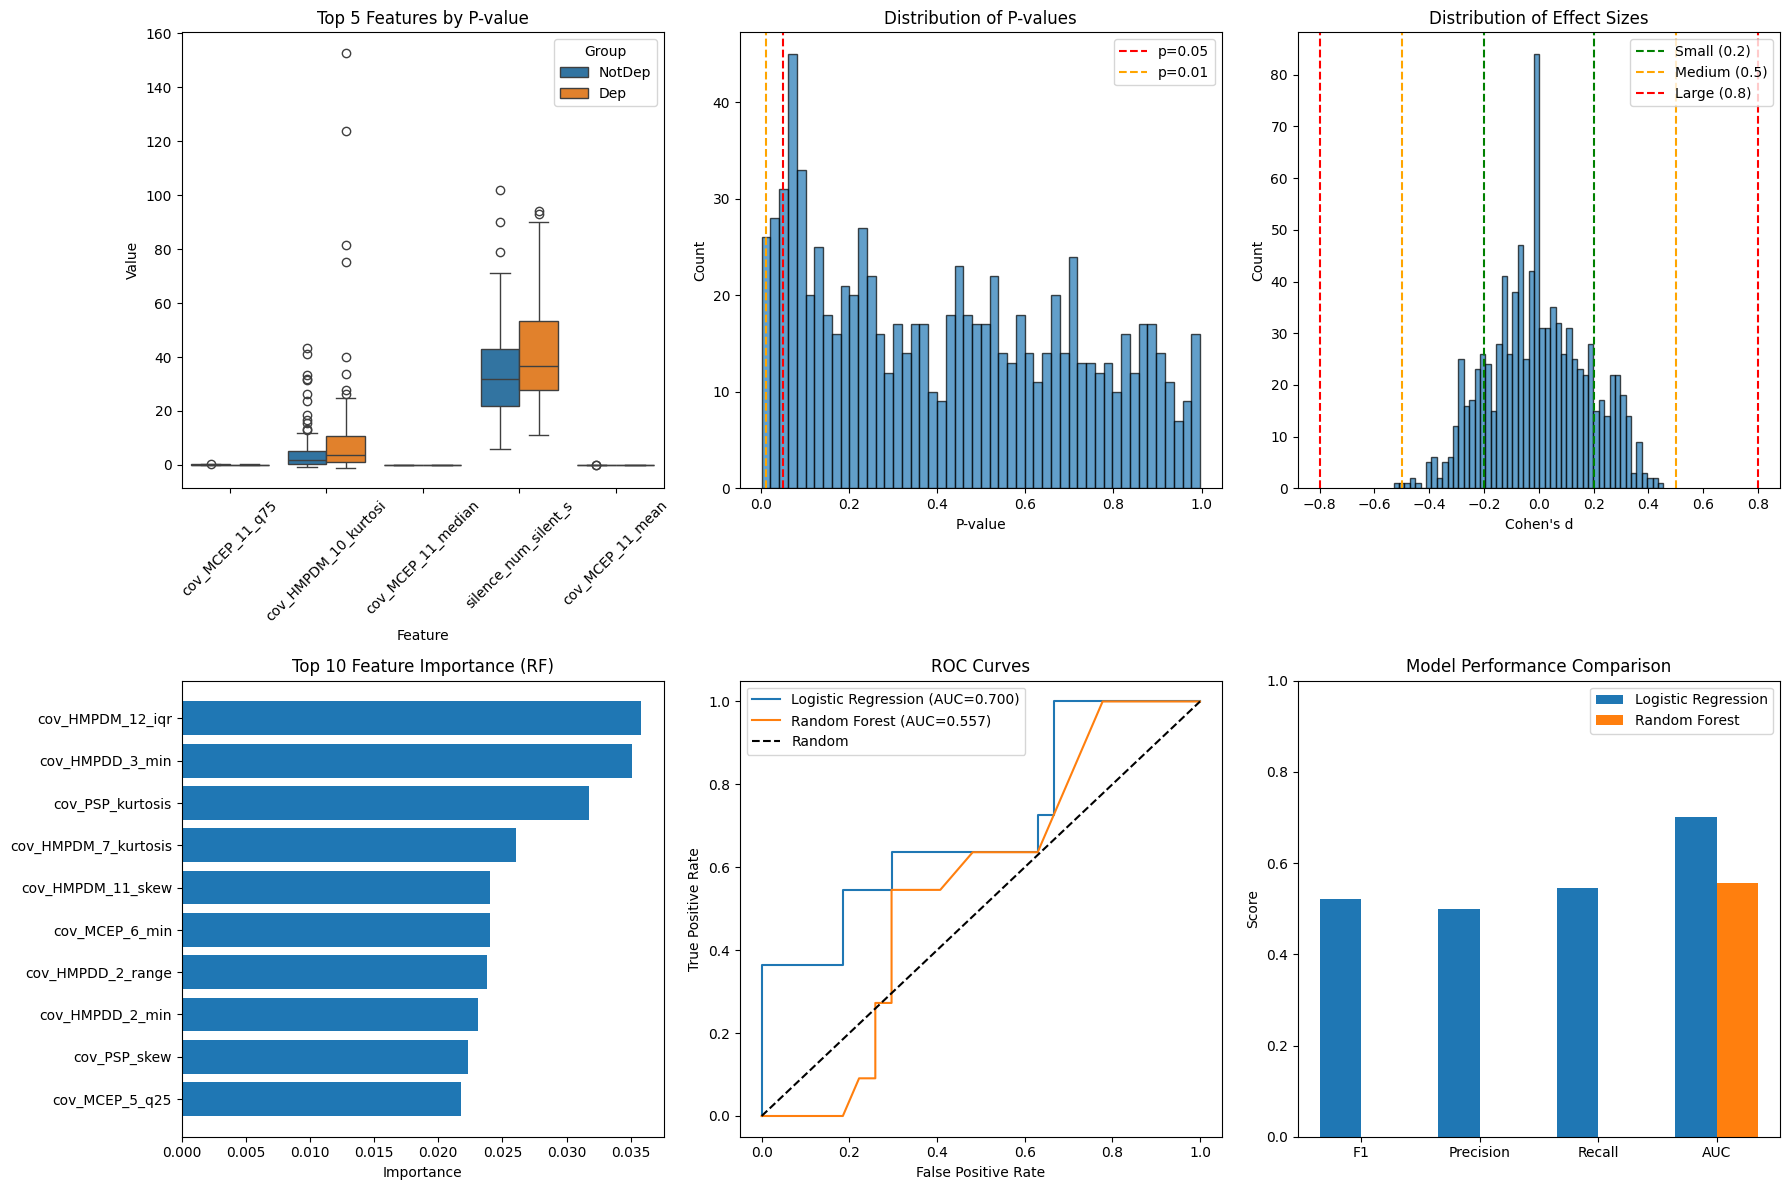

✓ Saved visualizations to: analysis_visualizations.png

FINAL SUMMARY

📊 Dataset:
   - Participants: 189
   - Depressed: 56
   - Not Depressed: 133
   - Total features extracted: 955

📈 Statistical Analysis:
   - Features tested: 945
   - Significant (p<0.05): 68
   - Significant (p<0.01): 11
   - Significant after Bonferroni: 0

🎯 Model Performance:

   Logistic Regression:
      CV F1: 0.368 (+/- 0.096)
      Test F1: 0.522
      Test AUC: 0.700

   Random Forest:
      CV F1: 0.272 (+/- 0.160)
      Test F1: 0.000
      Test AUC: 0.557


📁 Output Files:
   - /content/drive/MyDrive/try/metadata/combined_acoustic_features.csv
   - /content/drive/MyDrive/try/results/statistical_analysis_results.csv
   - /content/drive/MyDrive/try/results/analysis_visualizations.png

✓ Best model (Logistic Regression) saved to: best_model.pkl

ANALYSIS COMPLETE!


In [ ]:
# ========================================
# COVAREP & Formant Analysis Pipeline
# ניתוח מאפיינים אקוסטיים לזיהוי דיכאון
# ========================================

import os
import numpy as np
import pandas as pd
import torch
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_auc_score, roc_curve,
                             precision_score, recall_score, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. הגדרות ונתיבים
# ========================================

# עדכני את הנתיבים בהתאם למבנה שלך
BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"

# נתיבים אפשריים ל-COVAREP (עדכני בהתאם)
POSSIBLE_COVAREP_PATHS = [
    f"{BASE_PATH}DAIC-WOZ/RAW_DATA/covarep_features/"
]

POSSIBLE_FORMANT_PATHS = [
    f"{BASE_PATH}DAIC-WOZ/RAW_DATA/formant_features/"
]

FOLDERS = {
    'metadata': f"{OUTPUT_BASE}metadata",
    'models': f"{OUTPUT_BASE}models",
    'results': f"{OUTPUT_BASE}results",
}

# יצירת תיקיות
for folder in FOLDERS.values():
    os.makedirs(folder, exist_ok=True)

# ========================================
# 2. פונקציות עזר למציאת קבצים
# ========================================

def find_feature_directory(possible_paths, feature_name):
    """מוצא את התיקייה הנכונה"""
    for path in possible_paths:
        if os.path.exists(path):
            files = os.listdir(path)
            if len(files) > 0:
                print(f"✓ Found {feature_name} directory: {path}")
                print(f"  Contains {len(files)} files")
                return path
    print(f"✗ Could not find {feature_name} directory")
    print(f"  Searched in: {possible_paths}")
    return None

def get_participant_id_from_filename(filename):
    """מחלץ participant ID משם קובץ"""
    # מנסה פורמטים שונים: 492_COVAREP.csv, 492.csv, P492_COVAREP.csv
    name = os.path.splitext(filename)[0]

    # הסרת סיומות נפוצות
    for suffix in ['_COVAREP', '_FORMANT', '_covarep', '_formant', '_P', 'P_']:
        name = name.replace(suffix, '')

    # חילוץ מספרים
    digits = ''.join(filter(str.isdigit, name))
    return digits if digits else None

# ========================================
# 3. טעינת Labels
# ========================================

print("=" * 60)
print("Loading Labels...")
print("=" * 60)

labels_path = f"{BASE_PATH}DAIC-WOZ/metadata/labels_all.csv"
if not os.path.exists(labels_path):
    # נסה נתיבים חלופיים
    alt_paths = [
        f"{BASE_PATH}labels_all.csv",
        f"{BASE_PATH}DAIC-WOZ/labels.csv",
        f"{OUTPUT_BASE}metadata/labels_all.csv"
    ]
    for alt in alt_paths:
        if os.path.exists(alt):
            labels_path = alt
            break

labels_df = pd.read_csv(labels_path)
print(f"✓ Loaded labels: {len(labels_df)} participants")
print(f"  Columns: {list(labels_df.columns)}")

# יצירת מילון labels
if 'Participant_ID' in labels_df.columns:
    pid_col = 'Participant_ID'
elif 'participant_id' in labels_df.columns:
    pid_col = 'participant_id'
else:
    pid_col = labels_df.columns[0]

if 'PHQ_Binary' in labels_df.columns:
    label_col = 'PHQ_Binary'
elif 'PHQ8_Binary' in labels_df.columns:
    label_col = 'PHQ8_Binary'
elif 'label' in labels_df.columns:
    label_col = 'label'
else:
    label_col = labels_df.columns[-1]

labels_dict = dict(zip(labels_df[pid_col].astype(str), labels_df[label_col]))
print(f"  Label column: {label_col}")
print(f"  Depressed: {sum(labels_df[label_col] == 1)}, Not Depressed: {sum(labels_df[label_col] == 0)}")

# ========================================
# 4. טעינת Silence Features (אם קיים)
# ========================================

print("\n" + "=" * 60)
print("Loading Silence Features...")
print("=" * 60)

silence_path = f"{FOLDERS['metadata']}/participant_speech_features.csv"
if os.path.exists(silence_path):
    silence_df = pd.read_csv(silence_path)
    if 'participant_id' in silence_df.columns:
        silence_df.set_index('participant_id', inplace=True)
    silence_df.index = silence_df.index.astype(str)
    print(f"✓ Loaded silence features: {len(silence_df)} participants")
    print(f"  Features: {list(silence_df.columns)}")
    HAS_SILENCE = True
else:
    print("✗ Silence features not found - will continue without them")
    HAS_SILENCE = False
    silence_df = None

# ========================================
# 5. הגדרת COVAREP Features
# ========================================

# COVAREP feature names (74 features standard)
COVAREP_FEATURES = [
    'F0',           # Fundamental frequency
    'VUV',          # Voiced/Unvoiced
    'NAQ',          # Normalized Amplitude Quotient
    'QOQ',          # Quasi-Open Quotient
    'H1H2',         # H1-H2 (spectral tilt)
    'PSP',          # Parabolic Spectral Parameter
    'MDQ',          # Maxima Dispersion Quotient
    'peakSlope',    # Peak Slope
    'Rd',           # Rd parameter
    'Rd_conf',      # Rd confidence
    'creak',        # Creak probability
    'MCEP_0', 'MCEP_1', 'MCEP_2', 'MCEP_3', 'MCEP_4',
    'MCEP_5', 'MCEP_6', 'MCEP_7', 'MCEP_8', 'MCEP_9',
    'MCEP_10', 'MCEP_11', 'MCEP_12', 'MCEP_13', 'MCEP_14',
    'MCEP_15', 'MCEP_16', 'MCEP_17', 'MCEP_18', 'MCEP_19',
    'MCEP_20', 'MCEP_21', 'MCEP_22', 'MCEP_23', 'MCEP_24',
    'HMPDM_0', 'HMPDM_1', 'HMPDM_2', 'HMPDM_3', 'HMPDM_4',
    'HMPDM_5', 'HMPDM_6', 'HMPDM_7', 'HMPDM_8', 'HMPDM_9',
    'HMPDM_10', 'HMPDM_11', 'HMPDM_12', 'HMPDM_13', 'HMPDM_14',
    'HMPDM_15', 'HMPDM_16', 'HMPDM_17', 'HMPDM_18', 'HMPDM_19',
    'HMPDM_20', 'HMPDM_21', 'HMPDM_22', 'HMPDM_23', 'HMPDM_24',
    'HMPDD_0', 'HMPDD_1', 'HMPDD_2', 'HMPDD_3', 'HMPDD_4',
    'HMPDD_5', 'HMPDD_6', 'HMPDD_7', 'HMPDD_8', 'HMPDD_9',
    'HMPDD_10', 'HMPDD_11', 'HMPDD_12'
]

FORMANT_FEATURES = ['F1', 'F2', 'F3', 'F4', 'F5']

# ========================================
# 6. פונקציות לטעינה ואגרגציה
# ========================================

def load_and_aggregate_features(filepath, feature_names=None, feature_type='covarep'):
    """
    טוען קובץ features ומאגרג לרמת participant
    שומר על variance ומידע סטטיסטי נוסף
    """
    try:
        # טעינה
        df = pd.read_csv(filepath, header=None)

        # אם אין שמות עמודות, ניתן שמות גנריים
        if feature_names and len(feature_names) == df.shape[1]:
            df.columns = feature_names
        elif feature_type == 'formant' and df.shape[1] == 5:
            df.columns = FORMANT_FEATURES
        else:
            df.columns = [f'{feature_type}_{i}' for i in range(df.shape[1])]

        # הסרת שורות עם NaN או inf
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()

        if len(df) == 0:
            return None

        # אגרגציה - שמירה על מידע מקסימלי
        aggregated = {}

        for col in df.columns:
            values = df[col].values

            # סטטיסטיקות בסיסיות
            aggregated[f'{col}_mean'] = np.mean(values)
            aggregated[f'{col}_std'] = np.std(values)
            aggregated[f'{col}_median'] = np.median(values)

            # טווח ושונות
            aggregated[f'{col}_min'] = np.min(values)
            aggregated[f'{col}_max'] = np.max(values)
            aggregated[f'{col}_range'] = np.max(values) - np.min(values)

            # אחוזונים
            aggregated[f'{col}_q25'] = np.percentile(values, 25)
            aggregated[f'{col}_q75'] = np.percentile(values, 75)
            aggregated[f'{col}_iqr'] = aggregated[f'{col}_q75'] - aggregated[f'{col}_q25']

            # מדדים נוספים
            aggregated[f'{col}_skew'] = stats.skew(values) if len(values) > 2 else 0
            aggregated[f'{col}_kurtosis'] = stats.kurtosis(values) if len(values) > 3 else 0

            # Coefficient of Variation (מנורמל)
            if aggregated[f'{col}_mean'] != 0:
                aggregated[f'{col}_cv'] = aggregated[f'{col}_std'] / abs(aggregated[f'{col}_mean'])
            else:
                aggregated[f'{col}_cv'] = 0

        aggregated['n_frames'] = len(df)

        return aggregated

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def load_all_features(directory, feature_names, feature_type):
    """טוען את כל הקבצים מתיקייה"""
    all_features = {}

    if directory is None:
        return all_features

    files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    for filename in tqdm(files, desc=f"Loading {feature_type}"):
        pid = get_participant_id_from_filename(filename)
        if pid is None:
            continue

        filepath = os.path.join(directory, filename)
        features = load_and_aggregate_features(filepath, feature_names, feature_type)

        if features is not None:
            all_features[pid] = features

    return all_features

# ========================================
# 7. טעינת COVAREP ו-Formants
# ========================================

print("\n" + "=" * 60)
print("Loading COVAREP Features...")
print("=" * 60)

covarep_dir = find_feature_directory(POSSIBLE_COVAREP_PATHS, "COVAREP")

if covarep_dir:
    # בדיקת מבנה קובץ לדוגמה
    sample_file = [f for f in os.listdir(covarep_dir) if f.endswith('.csv')][0]
    sample_df = pd.read_csv(os.path.join(covarep_dir, sample_file), header=None, nrows=5)
    print(f"  Sample file: {sample_file}")
    print(f"  Shape: {sample_df.shape}")
    print(f"  Columns: {sample_df.shape[1]}")

    # התאמת שמות features למספר העמודות
    if sample_df.shape[1] == 74:
        feature_names = COVAREP_FEATURES
    else:
        feature_names = [f'covarep_{i}' for i in range(sample_df.shape[1])]

    covarep_features = load_all_features(covarep_dir, feature_names, 'covarep')
    print(f"✓ Loaded COVAREP for {len(covarep_features)} participants")
else:
    covarep_features = {}
    print("✗ COVAREP not loaded")

print("\n" + "=" * 60)
print("Loading Formant Features...")
print("=" * 60)

formant_dir = find_feature_directory(POSSIBLE_FORMANT_PATHS, "Formant")

if formant_dir:
    formant_features = load_all_features(formant_dir, FORMANT_FEATURES, 'formant')
    print(f"✓ Loaded Formants for {len(formant_features)} participants")
else:
    formant_features = {}
    print("✗ Formants not loaded")

# ========================================
# 8. יצירת DataFrame מאוחד
# ========================================

print("\n" + "=" * 60)
print("Creating Combined Dataset...")
print("=" * 60)

# איחוד כל ה-features
all_data = {}

# COVAREP
for pid, features in covarep_features.items():
    if pid not in all_data:
        all_data[pid] = {}
    for k, v in features.items():
        all_data[pid][f'cov_{k}'] = v

# Formants
for pid, features in formant_features.items():
    if pid not in all_data:
        all_data[pid] = {}
    for k, v in features.items():
        all_data[pid][f'form_{k}'] = v

# Silence features
if HAS_SILENCE:
    for pid in silence_df.index:
        if pid in all_data:
            for col in silence_df.columns:
                all_data[pid][f'silence_{col}'] = silence_df.loc[pid, col]

# יצירת DataFrame
features_df = pd.DataFrame.from_dict(all_data, orient='index')
features_df.index.name = 'participant_id'

# הוספת labels
features_df['label'] = features_df.index.map(labels_dict)
features_df = features_df.dropna(subset=['label'])
features_df['label'] = features_df['label'].astype(int)

print(f"✓ Combined dataset: {len(features_df)} participants, {len(features_df.columns)} features")
print(f"  Depressed: {(features_df['label'] == 1).sum()}")
print(f"  Not Depressed: {(features_df['label'] == 0).sum()}")

# שמירה
features_df.to_csv(f"{FOLDERS['metadata']}/combined_acoustic_features.csv")
print(f"✓ Saved to: combined_acoustic_features.csv")

# ========================================
# 9. ניתוח סטטיסטי - T-Tests
# ========================================

print("\n" + "=" * 60)
print("Running Statistical Analysis (T-Tests)...")
print("=" * 60)

def run_statistical_analysis(df, label_col='label'):
    """מריץ t-test על כל feature"""

    dep = df[df[label_col] == 1]
    not_dep = df[df[label_col] == 0]

    results = []
    feature_cols = [c for c in df.columns if c != label_col]

    for col in feature_cols:
        dep_vals = dep[col].dropna()
        nd_vals = not_dep[col].dropna()

        if len(dep_vals) < 2 or len(nd_vals) < 2:
            continue

        # t-test
        t_stat, p_val = stats.ttest_ind(dep_vals, nd_vals)

        # Cohen's d
        pooled_std = np.sqrt((dep_vals.std()**2 + nd_vals.std()**2) / 2)
        cohens_d = (dep_vals.mean() - nd_vals.mean()) / pooled_std if pooled_std > 0 else 0

        # אחוז הבדל
        if nd_vals.mean() != 0:
            diff_pct = (dep_vals.mean() - nd_vals.mean()) / abs(nd_vals.mean()) * 100
        else:
            diff_pct = 0

        results.append({
            'feature': col,
            'dep_mean': dep_vals.mean(),
            'dep_std': dep_vals.std(),
            'notdep_mean': nd_vals.mean(),
            'notdep_std': nd_vals.std(),
            'diff_pct': diff_pct,
            'cohens_d': cohens_d,
            't_stat': t_stat,
            'p_value': p_val,
            'significant_05': p_val < 0.05,
            'significant_01': p_val < 0.01,
            'significant_001': p_val < 0.001
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value')

    # Bonferroni correction
    n_tests = len(results_df)
    results_df['p_bonferroni'] = results_df['p_value'] * n_tests
    results_df['significant_bonferroni'] = results_df['p_bonferroni'] < 0.05

    return results_df

# הרצת ניתוח
stats_results = run_statistical_analysis(features_df)

# הצגת תוצאות
print(f"\n{'='*90}")
print("TOP 30 FEATURES BY P-VALUE")
print(f"{'='*90}")
print(f"\n{'Feature':<45} {'Dep':<12} {'NotDep':<12} {'Cohen d':<10} {'p-value':<12}")
print("-" * 90)

for _, row in stats_results.head(30).iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    direction = "↑" if row['dep_mean'] > row['notdep_mean'] else "↓"

    feature_name = row['feature'][:43] if len(row['feature']) > 43 else row['feature']
    print(f"{feature_name:<45} {row['dep_mean']:<12.4f} {row['notdep_mean']:<12.4f} "
          f"{row['cohens_d']:<+10.3f} {row['p_value']:<10.4f}{sig} {direction}")

# סיכום
print(f"\n{'='*90}")
print("SUMMARY")
print(f"{'='*90}")
n_sig_05 = stats_results['significant_05'].sum()
n_sig_01 = stats_results['significant_01'].sum()
n_sig_001 = stats_results['significant_001'].sum()
n_sig_bonf = stats_results['significant_bonferroni'].sum()

print(f"Total features tested: {len(stats_results)}")
print(f"Significant at p<0.05:  {n_sig_05} ({100*n_sig_05/len(stats_results):.1f}%)")
print(f"Significant at p<0.01:  {n_sig_01} ({100*n_sig_01/len(stats_results):.1f}%)")
print(f"Significant at p<0.001: {n_sig_001} ({100*n_sig_001/len(stats_results):.1f}%)")
print(f"Significant after Bonferroni: {n_sig_bonf}")

# שמירת תוצאות
stats_results.to_csv(f"{FOLDERS['results']}/statistical_analysis_results.csv", index=False)
print(f"\n✓ Results saved to: statistical_analysis_results.csv")

# ========================================
# 10. בחירת Features מובהקים
# ========================================

print("\n" + "=" * 60)
print("Selecting Significant Features...")
print("=" * 60)

# בחירה לפי p-value
significant_features = stats_results[stats_results['p_value'] < 0.05]['feature'].tolist()
print(f"Features with p<0.05: {len(significant_features)}")

# אם אין מספיק - לקחת את ה-top features
MIN_FEATURES = 10
if len(significant_features) < MIN_FEATURES:
    print(f"Adding top features to reach minimum of {MIN_FEATURES}")
    top_features = stats_results.head(MIN_FEATURES)['feature'].tolist()
    significant_features = list(set(significant_features + top_features))

# להוסיף silence features אם קיימים
silence_cols = [c for c in features_df.columns if 'silence' in c.lower()]
for col in silence_cols:
    if col not in significant_features:
        significant_features.append(col)

print(f"Total features selected: {len(significant_features)}")

# הצגת ה-features שנבחרו
print("\nSelected features:")
for i, feat in enumerate(significant_features[:20], 1):
    p_val = stats_results[stats_results['feature'] == feat]['p_value'].values
    p_str = f"p={p_val[0]:.4f}" if len(p_val) > 0 else ""
    print(f"  {i}. {feat} {p_str}")
if len(significant_features) > 20:
    print(f"  ... and {len(significant_features) - 20} more")

# ========================================
# 11. בניית מודל
# ========================================

print("\n" + "=" * 60)
print("Building Classification Model...")
print("=" * 60)

# הכנת נתונים
X = features_df[significant_features].copy()
y = features_df['label'].copy()

# טיפול ב-NaN ו-inf
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# חלוקה לtrain/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# נרמול
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# 12. אימון והערכת מודלים
# ========================================

print("\n" + "-" * 60)
print("Training Models...")
print("-" * 60)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
}

results_summary = []

for name, model in models.items():
    print(f"\n{name}:")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    print(f"  CV F1 scores: {cv_scores}")
    print(f"  CV F1 mean: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

    # אימון על כל ה-train
    model.fit(X_train_scaled, y_train)

    # חיזוי
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # מדדים
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"  Test Accuracy:  {acc:.3f}")
    print(f"  Test F1:        {f1:.3f}")
    print(f"  Test Precision: {precision:.3f}")
    print(f"  Test Recall:    {recall:.3f}")
    print(f"  Test AUC:       {auc:.3f}")

    results_summary.append({
        'model': name,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'test_accuracy': acc,
        'test_f1': f1,
        'test_precision': precision,
        'test_recall': recall,
        'test_auc': auc
    })

    # Confusion Matrix
    print(f"\n  Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"    TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"    FN={cm[1,0]}, TP={cm[1,1]}")

# ========================================
# 13. Feature Importance
# ========================================

print("\n" + "=" * 60)
print("Feature Importance Analysis...")
print("=" * 60)

# מ-Random Forest
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': significant_features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 15 Important Features (Random Forest):")
for i, row in importance_df.head(15).iterrows():
    print(f"  {row['feature']:<45} {row['importance']:.4f}")

# מ-Logistic Regression (coefficients)
lr_model = models['Logistic Regression']
coef_df = pd.DataFrame({
    'feature': significant_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 15 Features by Coefficient (Logistic Regression):")
for i, row in coef_df.head(15).iterrows():
    direction = "+" if row['coefficient'] > 0 else "-"
    print(f"  {row['feature']:<45} {direction}{abs(row['coefficient']):.4f}")

# ========================================
# 14. ויזואליזציה
# ========================================

print("\n" + "=" * 60)
print("Creating Visualizations...")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Top Features Boxplot
ax1 = axes[0, 0]
top_5_features = stats_results.head(5)['feature'].tolist()
plot_data = []
for feat in top_5_features:
    for label in [0, 1]:
        vals = features_df[features_df['label'] == label][feat].dropna()
        for v in vals:
            plot_data.append({'Feature': feat[:20], 'Value': v, 'Group': 'Dep' if label == 1 else 'NotDep'})

if plot_data:
    plot_df = pd.DataFrame(plot_data)
    sns.boxplot(data=plot_df, x='Feature', y='Value', hue='Group', ax=ax1)
    ax1.set_title('Top 5 Features by P-value')
    ax1.tick_params(axis='x', rotation=45)

# 2. P-value Distribution
ax2 = axes[0, 1]
ax2.hist(stats_results['p_value'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
ax2.axvline(x=0.01, color='orange', linestyle='--', label='p=0.01')
ax2.set_xlabel('P-value')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of P-values')
ax2.legend()

# 3. Cohen's d Distribution
ax3 = axes[0, 2]
ax3.hist(stats_results['cohens_d'].dropna(), bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0.2, color='green', linestyle='--', label='Small (0.2)')
ax3.axvline(x=0.5, color='orange', linestyle='--', label='Medium (0.5)')
ax3.axvline(x=0.8, color='red', linestyle='--', label='Large (0.8)')
ax3.axvline(x=-0.2, color='green', linestyle='--')
ax3.axvline(x=-0.5, color='orange', linestyle='--')
ax3.axvline(x=-0.8, color='red', linestyle='--')
ax3.set_xlabel("Cohen's d")
ax3.set_ylabel('Count')
ax3.set_title("Distribution of Effect Sizes")
ax3.legend()

# 4. Feature Importance (RF)
ax4 = axes[1, 0]
top_10_imp = importance_df.head(10)
ax4.barh(range(len(top_10_imp)), top_10_imp['importance'].values)
ax4.set_yticks(range(len(top_10_imp)))
ax4.set_yticklabels([f[:25] for f in top_10_imp['feature'].values])
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Feature Importance (RF)')
ax4.invert_yaxis()

# 5. ROC Curves
ax5 = axes[1, 1]
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax5.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
ax5.plot([0, 1], [0, 1], 'k--', label='Random')
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.set_title('ROC Curves')
ax5.legend()

# 6. Model Comparison
ax6 = axes[1, 2]
results_df = pd.DataFrame(results_summary)
metrics = ['test_f1', 'test_precision', 'test_recall', 'test_auc']
x = np.arange(len(metrics))
width = 0.35

for i, (_, row) in enumerate(results_df.iterrows()):
    offset = width * (i - 0.5)
    ax6.bar(x + offset, [row[m] for m in metrics], width, label=row['model'])

ax6.set_ylabel('Score')
ax6.set_title('Model Performance Comparison')
ax6.set_xticks(x)
ax6.set_xticklabels(['F1', 'Precision', 'Recall', 'AUC'])
ax6.legend()
ax6.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(f"{FOLDERS['results']}/analysis_visualizations.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualizations to: analysis_visualizations.png")

# ========================================
# 15. סיכום סופי
# ========================================

print("\n" + "=" * 90)
print("FINAL SUMMARY")
print("=" * 90)

print(f"""
📊 Dataset:
   - Participants: {len(features_df)}
   - Depressed: {(features_df['label'] == 1).sum()}
   - Not Depressed: {(features_df['label'] == 0).sum()}
   - Total features extracted: {len(features_df.columns) - 1}

📈 Statistical Analysis:
   - Features tested: {len(stats_results)}
   - Significant (p<0.05): {n_sig_05}
   - Significant (p<0.01): {n_sig_01}
   - Significant after Bonferroni: {n_sig_bonf}

🎯 Model Performance:
""")

for _, row in results_df.iterrows():
    print(f"   {row['model']}:")
    print(f"      CV F1: {row['cv_f1_mean']:.3f} (+/- {row['cv_f1_std']:.3f})")
    print(f"      Test F1: {row['test_f1']:.3f}")
    print(f"      Test AUC: {row['test_auc']:.3f}")
    print()

print(f"""
📁 Output Files:
   - {FOLDERS['metadata']}/combined_acoustic_features.csv
   - {FOLDERS['results']}/statistical_analysis_results.csv
   - {FOLDERS['results']}/analysis_visualizations.png
""")

# ========================================
# 16. שמירת המודל הטוב ביותר
# ========================================

best_model_name = results_df.loc[results_df['test_f1'].idxmax(), 'model']
best_model = models[best_model_name]

import pickle
model_data = {
    'model': best_model,
    'scaler': scaler,
    'features': significant_features,
    'results': results_df.to_dict(),
    'stats_summary': {
        'n_significant_05': n_sig_05,
        'n_significant_01': n_sig_01,
        'top_features': stats_results.head(10)['feature'].tolist()
    }
}

with open(f"{FOLDERS['models']}/best_model.pkl", 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Best model ({best_model_name}) saved to: best_model.pkl")
print("\n" + "=" * 90)
print("ANALYSIS COMPLETE!")
print("=" * 90)

🎯 FOCUSED MODEL: Silence + COVAREP + Formants

✓ Loaded data: 189 participants
  Depressed: 56
  Not Depressed: 133

📊 EVALUATING FEATURE CONFIGURATIONS

──────────────────────────────────────────────────────────────────────
📌 Config: silence_only
──────────────────────────────────────────────────────────────────────
  Features: 4

  Best model: LogisticRegression
  CV F1:      0.414 (+/- 0.099)
  CV AUC:     0.579 (+/- 0.070)
  Test F1:    0.519
  Test AUC:   0.714
  Confusion:  TP=7, TN=18, FP=9, FN=4

──────────────────────────────────────────────────────────────────────
📌 Config: silence_f0
──────────────────────────────────────────────────────────────────────
  Features: 8

  Best model: LogisticRegression
  CV F1:      0.488 (+/- 0.099)
  CV AUC:     0.633 (+/- 0.080)
  Test F1:    0.519
  Test AUC:   0.677
  Confusion:  TP=7, TN=18, FP=9, FN=4

──────────────────────────────────────────────────────────────────────
📌 Config: silence_f0_voiceQ
─────────────────────────────────────

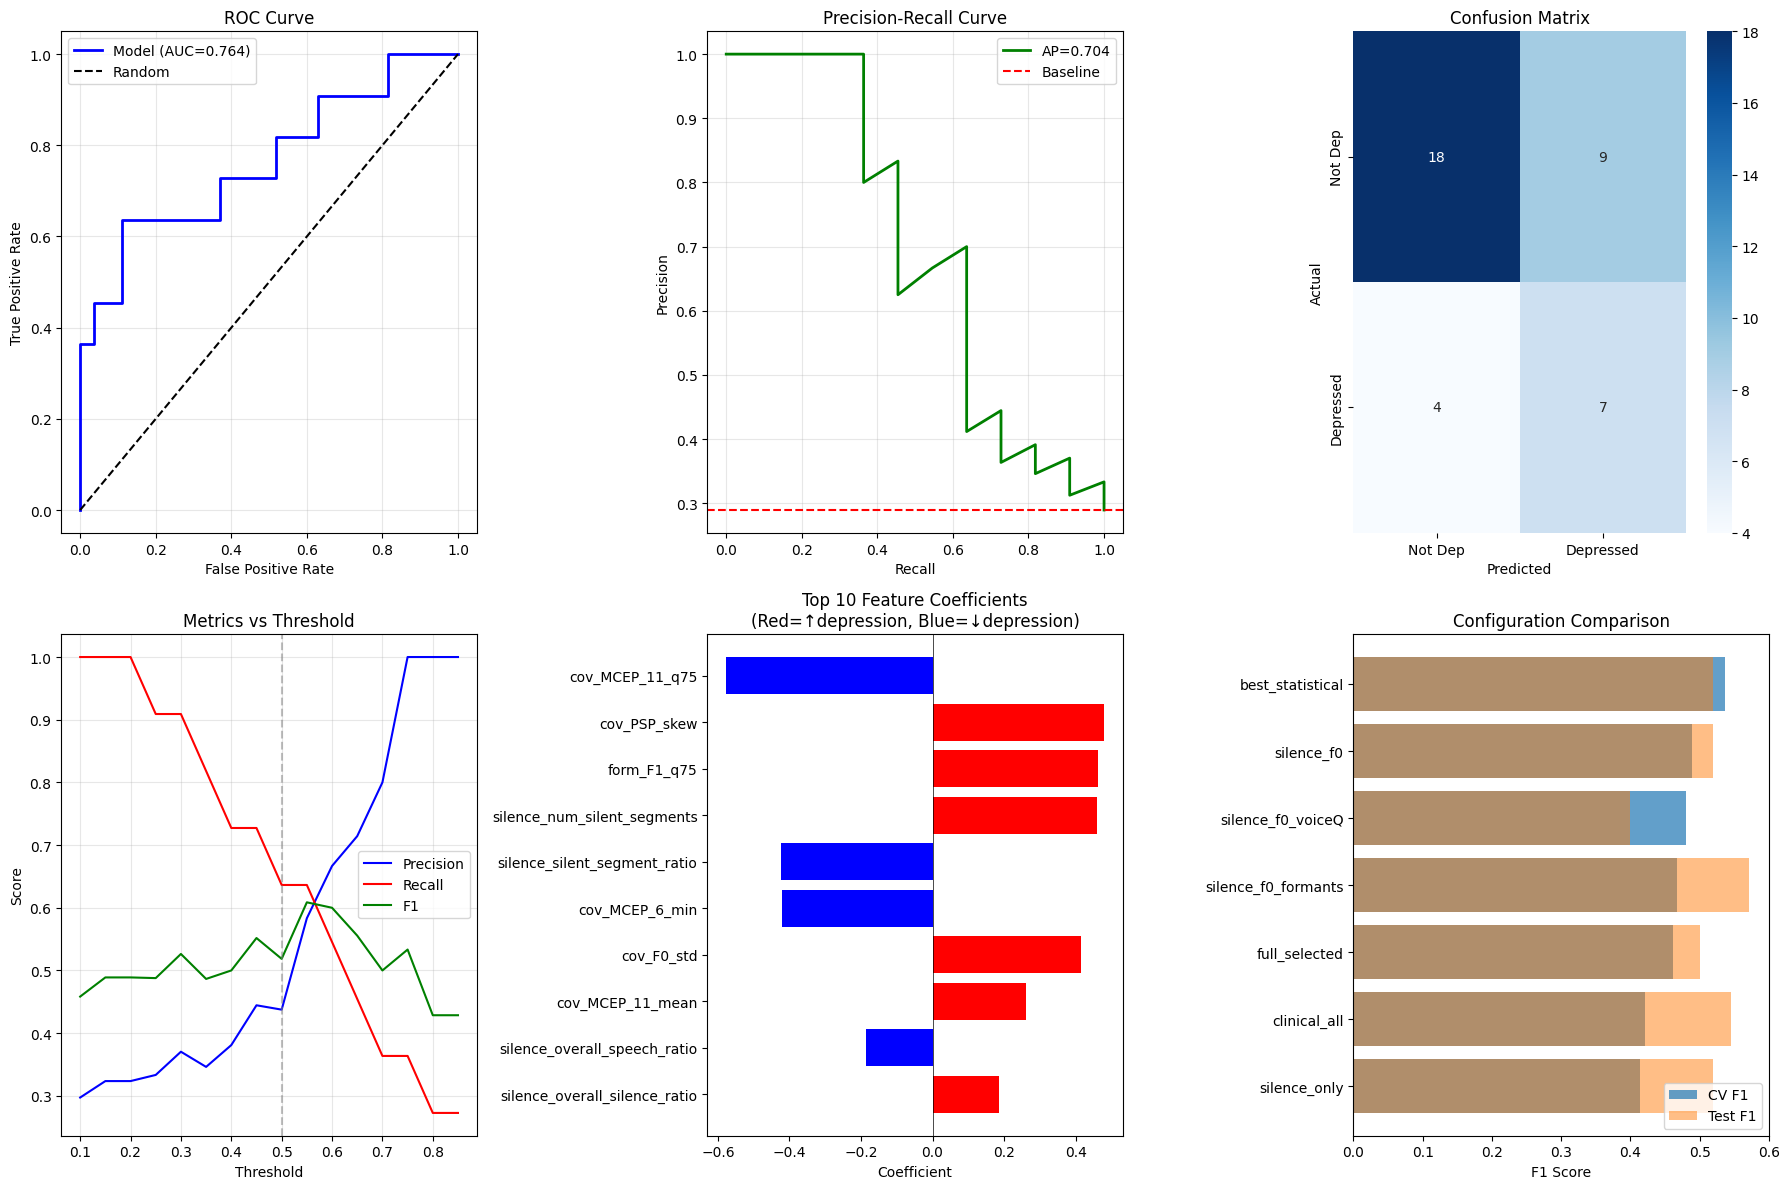

✓ Saved: focused_model_analysis.png

💾 SAVING FINAL MODEL
✓ Model saved to: focused_depression_model.pkl
✓ Results saved to: focused_model_results.csv

🎯 FINAL SUMMARY

✅ ANALYSIS COMPLETE!


In [ ]:
# ========================================
# FOCUSED MODEL: Silence + COVAREP + Formants
# מודל ממוקד עם features נבחרים
# ========================================

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_auc_score, roc_curve,
                             precision_score, recall_score, accuracy_score,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. טעינת הנתונים המאוחדים
# ========================================

print("=" * 70)
print("🎯 FOCUSED MODEL: Silence + COVAREP + Formants")
print("=" * 70)

# טעינת הקובץ שנוצר בשלב הקודם
OUTPUT_BASE = "/content/drive/MyDrive/try/"
features_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)

print(f"\n✓ Loaded data: {len(features_df)} participants")
print(f"  Depressed: {(features_df['label'] == 1).sum()}")
print(f"  Not Depressed: {(features_df['label'] == 0).sum()}")

# ========================================
# 2. הגדרת Features נבחרים - קליניים ומובהקים
# ========================================

# קבוצה 1: Silence Features (הכי חזקים!)
SILENCE_FEATURES = [
    'silence_num_silent_segments',      # p=0.0027**
    'silence_overall_silence_ratio',    # p=0.0162*
    'silence_overall_speech_ratio',     # p=0.0162*
    'silence_silent_segment_ratio',     # p=0.0701 (קרוב)
]

# קבוצה 2: F0 - Pitch (קריטי קלינית לדיכאון)
F0_FEATURES = [
    'cov_F0_std',                        # p=0.0107* - שונות בגובה הקול
    'cov_F0_mean',                       # ממוצע pitch
    'cov_F0_median',                     # coefficient=-1.04 ב-LR
    'cov_F0_cv',                         # מונוטוניות
]

# קבוצה 3: Voice Quality
VOICE_QUALITY_FEATURES = [
    'cov_H1H2_mean',                     # p=0.0196* - spectral tilt
    'cov_H1H2_std',                      # שונות ב-voice quality
    'cov_NAQ_mean',                      # Normalized Amplitude Quotient
    'cov_QOQ_mean',                      # Quasi-Open Quotient
]

# קבוצה 4: Formant F1 (הכי מובהק מהפורמנטים)
FORMANT_FEATURES = [
    'form_F1_median',                    # p=0.0143*
    'form_F1_q75',                       # p=0.0085**
    'form_F1_iqr',                       # p=0.0133*
    'form_F1_std',                       # שונות
]

# קבוצה 5: Top COVAREP (הכי מובהקים)
TOP_COVAREP_FEATURES = [
    'cov_MCEP_11_q75',                   # p=0.0011**
    'cov_MCEP_11_mean',                  # p=0.0033**
    'cov_MCEP_6_min',                    # p=0.0036**
    'cov_PSP_skew',                      # p=0.0097**
]

# ========================================
# 3. יצירת קונפיגורציות שונות לבדיקה
# ========================================

FEATURE_CONFIGS = {
    'silence_only': SILENCE_FEATURES,

    'silence_f0': SILENCE_FEATURES + F0_FEATURES,

    'silence_f0_voiceQ': SILENCE_FEATURES + F0_FEATURES + VOICE_QUALITY_FEATURES,

    'silence_f0_formants': SILENCE_FEATURES + F0_FEATURES + FORMANT_FEATURES,

    'clinical_all': SILENCE_FEATURES + F0_FEATURES + VOICE_QUALITY_FEATURES + FORMANT_FEATURES,

    'best_statistical': SILENCE_FEATURES + TOP_COVAREP_FEATURES + ['form_F1_q75', 'cov_F0_std'],

    'full_selected': (SILENCE_FEATURES + F0_FEATURES + VOICE_QUALITY_FEATURES +
                      FORMANT_FEATURES + TOP_COVAREP_FEATURES),
}

# ========================================
# 4. פונקציה לבדיקת features זמינים
# ========================================

def get_available_features(feature_list, df):
    """מחזיר רק features שקיימים ב-DataFrame"""
    available = [f for f in feature_list if f in df.columns]
    missing = [f for f in feature_list if f not in df.columns]
    if missing:
        print(f"  ⚠ Missing features: {missing}")
    return available

# ========================================
# 5. פונקציית אימון והערכה
# ========================================

def evaluate_model(X, y, model, model_name, n_splits=5):
    """מעריך מודל עם cross-validation ו-test set"""

    # חלוקה
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # נרמול
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_auc = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

    # אימון סופי
    model.fit(X_train_scaled, y_train)

    # חיזוי
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # מדדים
    results = {
        'model': model_name,
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std(),
        'cv_auc_mean': cv_auc.mean(),
        'cv_auc_std': cv_auc.std(),
        'test_f1': f1_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred, zero_division=0),
        'test_recall': recall_score(y_test, y_pred, zero_division=0),
        'test_auc': roc_auc_score(y_test, y_prob),
        'test_accuracy': accuracy_score(y_test, y_pred),
    }

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results['TN'], results['FP'] = cm[0, 0], cm[0, 1]
    results['FN'], results['TP'] = cm[1, 0], cm[1, 1]

    return results, model, scaler, (X_test_scaled, y_test, y_prob)

# ========================================
# 6. הרצת כל הקונפיגורציות
# ========================================

print("\n" + "=" * 70)
print("📊 EVALUATING FEATURE CONFIGURATIONS")
print("=" * 70)

all_results = []

for config_name, feature_list in FEATURE_CONFIGS.items():
    print(f"\n{'─' * 70}")
    print(f"📌 Config: {config_name}")
    print(f"{'─' * 70}")

    # בדיקת features זמינים
    available_features = get_available_features(feature_list, features_df)

    if len(available_features) < 2:
        print(f"  ⚠ Not enough features available, skipping")
        continue

    print(f"  Features: {len(available_features)}")

    # הכנת נתונים
    X = features_df[available_features].copy()
    y = features_df['label'].copy()

    # טיפול ב-NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    # מודלים לבדיקה
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
        'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    }

    config_results = []

    for model_name, model in models.items():
        try:
            results, trained_model, scaler, test_data = evaluate_model(X, y, model, model_name)
            results['config'] = config_name
            results['n_features'] = len(available_features)
            config_results.append(results)
            all_results.append(results)
        except Exception as e:
            print(f"  ⚠ Error with {model_name}: {e}")

    # הצגת תוצאות לקונפיגורציה
    if config_results:
        config_df = pd.DataFrame(config_results)
        best_idx = config_df['cv_f1_mean'].idxmax()
        best = config_df.loc[best_idx]

        print(f"\n  Best model: {best['model']}")
        print(f"  CV F1:      {best['cv_f1_mean']:.3f} (+/- {best['cv_f1_std']:.3f})")
        print(f"  CV AUC:     {best['cv_auc_mean']:.3f} (+/- {best['cv_auc_std']:.3f})")
        print(f"  Test F1:    {best['test_f1']:.3f}")
        print(f"  Test AUC:   {best['test_auc']:.3f}")
        print(f"  Confusion:  TP={best['TP']:.0f}, TN={best['TN']:.0f}, FP={best['FP']:.0f}, FN={best['FN']:.0f}")

# ========================================
# 7. סיכום כל התוצאות
# ========================================

print("\n" + "=" * 70)
print("📋 SUMMARY: ALL CONFIGURATIONS")
print("=" * 70)

results_df = pd.DataFrame(all_results)

# מיון לפי CV F1
results_df_sorted = results_df.sort_values('cv_f1_mean', ascending=False)

print(f"\n{'Config':<25} {'Model':<20} {'#Feat':>6} {'CV F1':>8} {'Test F1':>8} {'AUC':>8}")
print("-" * 80)

for _, row in results_df_sorted.head(15).iterrows():
    print(f"{row['config']:<25} {row['model']:<20} {row['n_features']:>6} "
          f"{row['cv_f1_mean']:>8.3f} {row['test_f1']:>8.3f} {row['test_auc']:>8.3f}")

# ========================================
# 8. הקונפיגורציה הטובה ביותר
# ========================================

print("\n" + "=" * 70)
print("🏆 BEST CONFIGURATION")
print("=" * 70)

best_overall = results_df_sorted.iloc[0]

print(f"""
Configuration: {best_overall['config']}
Model:         {best_overall['model']}
Features:      {best_overall['n_features']}

Performance:
  CV F1:       {best_overall['cv_f1_mean']:.3f} (+/- {best_overall['cv_f1_std']:.3f})
  CV AUC:      {best_overall['cv_auc_mean']:.3f} (+/- {best_overall['cv_auc_std']:.3f})
  Test F1:     {best_overall['test_f1']:.3f}
  Test Prec:   {best_overall['test_precision']:.3f}
  Test Recall: {best_overall['test_recall']:.3f}
  Test AUC:    {best_overall['test_auc']:.3f}

Confusion Matrix:
  TP={best_overall['TP']:.0f} (correctly identified depressed)
  TN={best_overall['TN']:.0f} (correctly identified not depressed)
  FP={best_overall['FP']:.0f} (false alarms)
  FN={best_overall['FN']:.0f} (missed cases)
""")

# ========================================
# 9. אימון המודל הסופי
# ========================================

print("\n" + "=" * 70)
print("🔧 TRAINING FINAL MODEL")
print("=" * 70)

# בחירת הקונפיגורציה הטובה ביותר
best_config = best_overall['config']
best_model_name = best_overall['model']

# Features
final_features = get_available_features(FEATURE_CONFIGS[best_config], features_df)
print(f"\nFinal features ({len(final_features)}):")
for i, f in enumerate(final_features, 1):
    print(f"  {i}. {f}")

# הכנת נתונים
X_final = features_df[final_features].copy()
y_final = features_df['label'].copy()
X_final = X_final.replace([np.inf, -np.inf], np.nan).fillna(X_final.median())

# חלוקה
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# נרמול
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)

# מודל
if best_model_name == 'LogisticRegression':
    final_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
elif best_model_name == 'RandomForest':
    final_model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
elif best_model_name == 'GradientBoosting':
    final_model = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
else:
    final_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

final_model.fit(X_train_scaled, y_train)

# חיזוי
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n✓ Final model trained: {best_model_name}")

# ========================================
# 10. Feature Importance / Coefficients
# ========================================

print("\n" + "=" * 70)
print("📈 FEATURE IMPORTANCE")
print("=" * 70)

if hasattr(final_model, 'coef_'):
    # Logistic Regression
    coef_df = pd.DataFrame({
        'feature': final_features,
        'coefficient': final_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)

    print("\nLogistic Regression Coefficients:")
    print(f"{'Feature':<40} {'Coef':>10} {'Direction':<20}")
    print("-" * 70)
    for _, row in coef_df.iterrows():
        direction = "→ Higher = MORE depressed" if row['coefficient'] > 0 else "→ Higher = LESS depressed"
        print(f"{row['feature']:<40} {row['coefficient']:>+10.4f} {direction}")

elif hasattr(final_model, 'feature_importances_'):
    # Tree-based
    imp_df = pd.DataFrame({
        'feature': final_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importances:")
    for _, row in imp_df.iterrows():
        print(f"  {row['feature']:<40} {row['importance']:.4f}")

# ========================================
# 11. Threshold Optimization (for Screening)
# ========================================

print("\n" + "=" * 70)
print("🎚️ THRESHOLD OPTIMIZATION (For Screening)")
print("=" * 70)

print("\nFor SCREENING, we want HIGH RECALL (catch all depressed)")
print("Willing to accept more false positives\n")

# חישוב מדדים בסף שונים
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)

    if sum(y_pred_thresh) == 0 or sum(y_pred_thresh) == len(y_pred_thresh):
        continue

    threshold_results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'recall': recall_score(y_test, y_pred_thresh, zero_division=0),
        'f1': f1_score(y_test, y_pred_thresh, zero_division=0),
        'specificity': (y_test[y_pred_thresh == 0] == 0).mean() if sum(y_pred_thresh == 0) > 0 else 0,
    })

thresh_df = pd.DataFrame(threshold_results)

# מציאת סף אופטימלי לסקירה (recall >= 0.8)
screening_thresh = thresh_df[thresh_df['recall'] >= 0.8]
if len(screening_thresh) > 0:
    best_screening = screening_thresh.loc[screening_thresh['precision'].idxmax()]
    print(f"Optimal threshold for SCREENING (recall ≥ 0.8):")
    print(f"  Threshold:   {best_screening['threshold']:.2f}")
    print(f"  Recall:      {best_screening['recall']:.3f} (sensitivity)")
    print(f"  Precision:   {best_screening['precision']:.3f}")
    print(f"  F1:          {best_screening['f1']:.3f}")
else:
    print("Could not find threshold with recall >= 0.8")

# מציאת סף אופטימלי ל-F1
best_f1_idx = thresh_df['f1'].idxmax()
best_f1_thresh = thresh_df.loc[best_f1_idx]
print(f"\nOptimal threshold for F1:")
print(f"  Threshold:   {best_f1_thresh['threshold']:.2f}")
print(f"  F1:          {best_f1_thresh['f1']:.3f}")
print(f"  Recall:      {best_f1_thresh['recall']:.3f}")
print(f"  Precision:   {best_f1_thresh['precision']:.3f}")

# ========================================
# 12. ויזואליזציה
# ========================================

print("\n" + "=" * 70)
print("📊 CREATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC Curve
ax1 = axes[0, 0]
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'Model (AUC={roc_auc_score(y_test, y_prob):.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curve
ax2 = axes[0, 1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
ax2.plot(recall_curve, precision_curve, 'g-', linewidth=2, label=f'AP={ap:.3f}')
ax2.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', label='Baseline')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax3 = axes[0, 2]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Not Dep', 'Depressed'],
            yticklabels=['Not Dep', 'Depressed'])
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title('Confusion Matrix')

# 4. Threshold vs Metrics
ax4 = axes[1, 0]
ax4.plot(thresh_df['threshold'], thresh_df['precision'], 'b-', label='Precision')
ax4.plot(thresh_df['threshold'], thresh_df['recall'], 'r-', label='Recall')
ax4.plot(thresh_df['threshold'], thresh_df['f1'], 'g-', label='F1')
ax4.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Threshold')
ax4.set_ylabel('Score')
ax4.set_title('Metrics vs Threshold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Feature Coefficients
ax5 = axes[1, 1]
if hasattr(final_model, 'coef_'):
    coef_sorted = coef_df.head(10)
    colors = ['red' if c > 0 else 'blue' for c in coef_sorted['coefficient']]
    ax5.barh(range(len(coef_sorted)), coef_sorted['coefficient'].values, color=colors)
    ax5.set_yticks(range(len(coef_sorted)))
    ax5.set_yticklabels([f[:30] for f in coef_sorted['feature'].values])
    ax5.set_xlabel('Coefficient')
    ax5.set_title('Top 10 Feature Coefficients\n(Red=↑depression, Blue=↓depression)')
    ax5.axvline(x=0, color='black', linewidth=0.5)
ax5.invert_yaxis()

# 6. Configuration Comparison
ax6 = axes[1, 2]
config_summary = results_df.groupby('config').agg({
    'cv_f1_mean': 'max',
    'test_f1': 'max',
    'test_auc': 'max'
}).sort_values('cv_f1_mean', ascending=True)

y_pos = range(len(config_summary))
ax6.barh(y_pos, config_summary['cv_f1_mean'], alpha=0.7, label='CV F1')
ax6.barh(y_pos, config_summary['test_f1'], alpha=0.5, label='Test F1')
ax6.set_yticks(y_pos)
ax6.set_yticklabels(config_summary.index)
ax6.set_xlabel('F1 Score')
ax6.set_title('Configuration Comparison')
ax6.legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_BASE}results/focused_model_analysis.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: focused_model_analysis.png")

# ========================================
# 13. שמירת המודל הסופי
# ========================================

print("\n" + "=" * 70)
print("💾 SAVING FINAL MODEL")
print("=" * 70)

import pickle

model_package = {
    'model': final_model,
    'scaler': final_scaler,
    'features': final_features,
    'config': best_config,
    'performance': {
        'cv_f1': best_overall['cv_f1_mean'],
        'test_f1': best_overall['test_f1'],
        'test_auc': best_overall['test_auc'],
        'test_recall': best_overall['test_recall'],
        'test_precision': best_overall['test_precision'],
    },
    'threshold_default': 0.5,
    'threshold_screening': best_screening['threshold'] if len(screening_thresh) > 0 else 0.3,
}

with open(f"{OUTPUT_BASE}models/focused_depression_model.pkl", 'wb') as f:
    pickle.dump(model_package, f)

print(f"✓ Model saved to: focused_depression_model.pkl")

# שמירת תוצאות
results_df.to_csv(f"{OUTPUT_BASE}results/focused_model_results.csv", index=False)
print(f"✓ Results saved to: focused_model_results.csv")

# ========================================
# 14. סיכום סופי
# ========================================

print("\n" + "=" * 70)
print("🎯 FINAL SUMMARY")
print("=" * 70)


print("\n✅ ANALYSIS COMPLETE!")

🚀 DEPLOYABLE MODEL - Extractable Features Only

📂 Loading combined features...
✓ Loaded: 189 participants, 956 features
  Depressed: 56
  Not Depressed: 133

📋 DEFINING EXTRACTABLE FEATURES

Extractable feature groups:
  Silence:       5 features
  F0 (Pitch):    10 features
  Formant F1:    7 features
  Voice Quality: 8 features
  ─────────────────────────────
  TOTAL:         30 features

🔍 CHECKING FEATURE AVAILABILITY

Silence:       5/5 available
F0:            10/10 available
Formant F1:    7/7 available
Voice Quality: 8/8 available

✓ Total available: 30 features

🏋️ TRAINING MODELS

────────────────────────────────────────────────────────────
📌 Config: silence_only (5 features)
────────────────────────────────────────────────────────────

  Best: LogisticRegression
  CV F1:   0.328 (+/- 0.071)
  Test F1: 0.692, AUC: 0.781

────────────────────────────────────────────────────────────
📌 Config: silence_f0 (15 features)
────────────────────────────────────────────────────────────


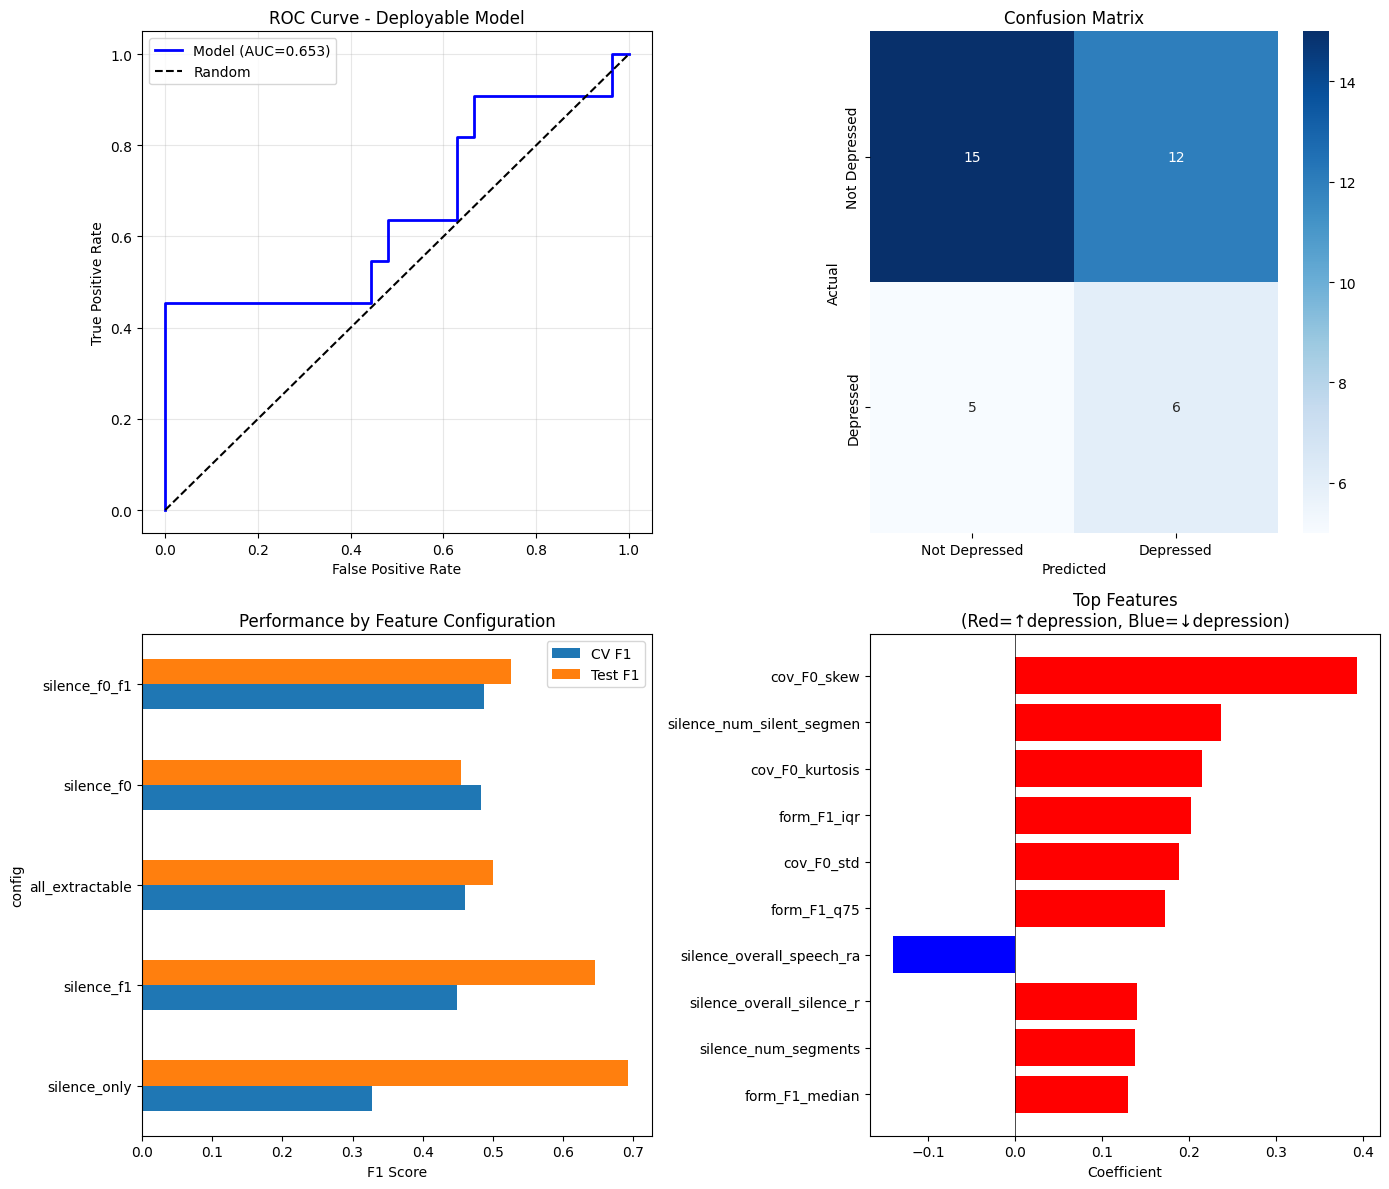

✓ Saved: deployable_model_results.png

💾 SAVING DEPLOYABLE MODEL
✓ Model saved to: /content/drive/MyDrive/try/models/deployable_depression_model.pkl
✓ Results saved to: deployable_model_comparison.csv

✅ FINAL SUMMARY - DEPLOYABLE MODEL

╔══════════════════════════════════════════════════════════════════════╗
║  DEPRESSION SCREENING - DEPLOYABLE MODEL                             ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  ✅ Uses ONLY features that can be extracted from new recordings     ║
║  ✅ No COVAREP installation required                                 ║
║  ✅ Ready for deployment                                             ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  CONFIGURATION                                                       ║
╠══════════════════════════════════

In [ ]:
# ========================================
# DEPLOYABLE MODEL - Only Extractable Features
# מודל שמיש - רק features שאפשר לחלץ בעצמך
# ========================================

"""
מודל זה משתמש רק ב-features שניתן לחלץ מהקלטה חדשה:
✅ Silence - VAD / RMS
✅ F0 (Pitch) - Parselmouth / Librosa
✅ Formants F1 - Parselmouth
✅ H1H2, Voice Quality - OpenSMILE

❌ לא משתמש ב-MCEP, HMPDM, HMPDD (דורשים COVAREP)
"""

import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (f1_score, roc_auc_score, roc_curve,
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. הגדרות
# ========================================

OUTPUT_BASE = "/content/drive/MyDrive/try/"

print("=" * 70)
print("🚀 DEPLOYABLE MODEL - Extractable Features Only")
print("=" * 70)

# ========================================
# 2. טעינת הנתונים המאוחדים
# ========================================

print("\n📂 Loading combined features...")

features_path = f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv"
features_df = pd.read_csv(features_path, index_col=0)

print(f"✓ Loaded: {len(features_df)} participants, {len(features_df.columns)} features")
print(f"  Depressed: {(features_df['label'] == 1).sum()}")
print(f"  Not Depressed: {(features_df['label'] == 0).sum()}")

# ========================================
# 3. הגדרת Features ניתנים לחילוץ
# ========================================

print("\n" + "=" * 70)
print("📋 DEFINING EXTRACTABLE FEATURES")
print("=" * 70)

# קבוצה 1: Silence Features ✅ (VAD / RMS)
SILENCE_FEATURES = [
    'silence_num_silent_segments',       # p=0.0027** - הכי חזק!
    'silence_overall_silence_ratio',     # p=0.0162*
    'silence_overall_speech_ratio',      # p=0.0162*
    'silence_silent_segment_ratio',      # p=0.0701
    'silence_num_segments',              # מספר סגמנטים כולל
]

# קבוצה 2: F0 Features ✅ (Parselmouth / Librosa pyin)
F0_FEATURES = [
    'cov_F0_mean',
    'cov_F0_std',                         # p=0.0107*
    'cov_F0_median',
    'cov_F0_cv',                          # coefficient of variation
    'cov_F0_range',
    'cov_F0_q25',
    'cov_F0_q75',
    'cov_F0_iqr',
    'cov_F0_skew',
    'cov_F0_kurtosis',
]

# קבוצה 3: Formant F1 Features ✅ (Parselmouth)
# F1 הראה את ההבדלים המובהקים ביותר מבין הפורמנטים
FORMANT_F1_FEATURES = [
    'form_F1_mean',
    'form_F1_std',
    'form_F1_median',                     # p=0.0143*
    'form_F1_q25',
    'form_F1_q75',                         # p=0.0085**
    'form_F1_iqr',                         # p=0.0133*
    'form_F1_skew',                        # p=0.0125*
]

# קבוצה 4: Voice Quality ✅ (OpenSMILE eGeMAPSv02)
# H1H2 היה מובהק, והשאר ניתנים לחילוץ עם OpenSMILE
VOICE_QUALITY_FEATURES = [
    'cov_H1H2_mean',                       # p=0.0196*
    'cov_H1H2_std',
    'cov_NAQ_mean',                        # ניתן לקירוב עם OpenSMILE
    'cov_NAQ_std',
    'cov_QOQ_mean',                        # ניתן לקירוב עם OpenSMILE
    'cov_QOQ_std',
    'cov_VUV_mean',                        # Voiced/Unvoiced ratio
    'cov_VUV_std',
]

# כל ה-features הניתנים לחילוץ
ALL_EXTRACTABLE = SILENCE_FEATURES + F0_FEATURES + FORMANT_F1_FEATURES + VOICE_QUALITY_FEATURES

print(f"\nExtractable feature groups:")
print(f"  Silence:       {len(SILENCE_FEATURES)} features")
print(f"  F0 (Pitch):    {len(F0_FEATURES)} features")
print(f"  Formant F1:    {len(FORMANT_F1_FEATURES)} features")
print(f"  Voice Quality: {len(VOICE_QUALITY_FEATURES)} features")
print(f"  ─────────────────────────────")
print(f"  TOTAL:         {len(ALL_EXTRACTABLE)} features")

# ========================================
# 4. בדיקת זמינות Features
# ========================================

def get_available_features(feature_list, df):
    """מחזיר רק features שקיימים ב-DataFrame"""
    available = [f for f in feature_list if f in df.columns]
    missing = [f for f in feature_list if f not in df.columns]
    return available, missing

print("\n" + "=" * 70)
print("🔍 CHECKING FEATURE AVAILABILITY")
print("=" * 70)

available_silence, missing_silence = get_available_features(SILENCE_FEATURES, features_df)
available_f0, missing_f0 = get_available_features(F0_FEATURES, features_df)
available_f1, missing_f1 = get_available_features(FORMANT_F1_FEATURES, features_df)
available_vq, missing_vq = get_available_features(VOICE_QUALITY_FEATURES, features_df)

print(f"\nSilence:       {len(available_silence)}/{len(SILENCE_FEATURES)} available")
if missing_silence:
    print(f"  Missing: {missing_silence}")

print(f"F0:            {len(available_f0)}/{len(F0_FEATURES)} available")
if missing_f0:
    print(f"  Missing: {missing_f0}")

print(f"Formant F1:    {len(available_f1)}/{len(FORMANT_F1_FEATURES)} available")
if missing_f1:
    print(f"  Missing: {missing_f1}")

print(f"Voice Quality: {len(available_vq)}/{len(VOICE_QUALITY_FEATURES)} available")
if missing_vq:
    print(f"  Missing: {missing_vq}")

# כל ה-features הזמינים
AVAILABLE_FEATURES = available_silence + available_f0 + available_f1 + available_vq
print(f"\n✓ Total available: {len(AVAILABLE_FEATURES)} features")

# ========================================
# 5. קונפיגורציות לבדיקה
# ========================================

CONFIGS = {
    'silence_only': available_silence,
    'silence_f0': available_silence + available_f0,
    'silence_f1': available_silence + available_f1,
    'silence_f0_f1': available_silence + available_f0 + available_f1,
    'all_extractable': AVAILABLE_FEATURES,
}

# ========================================
# 6. פונקציית אימון והערכה
# ========================================

def train_and_evaluate(X, y, model, model_name, n_splits=5):
    """אימון והערכה עם cross-validation"""

    # חלוקה
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # נרמול
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_auc = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

    # אימון סופי
    model.fit(X_train_scaled, y_train)

    # חיזוי
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # מדדים
    results = {
        'model': model_name,
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std(),
        'cv_auc_mean': cv_auc.mean(),
        'test_f1': f1_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred, zero_division=0),
        'test_recall': recall_score(y_test, y_pred, zero_division=0),
        'test_auc': roc_auc_score(y_test, y_prob),
        'test_accuracy': accuracy_score(y_test, y_pred),
    }

    cm = confusion_matrix(y_test, y_pred)
    results['TP'] = cm[1, 1]
    results['TN'] = cm[0, 0]
    results['FP'] = cm[0, 1]
    results['FN'] = cm[1, 0]

    return results, model, scaler, (X_test_scaled, y_test, y_prob)

# ========================================
# 7. הרצת כל הקונפיגורציות
# ========================================

print("\n" + "=" * 70)
print("🏋️ TRAINING MODELS")
print("=" * 70)

all_results = []

for config_name, feature_list in CONFIGS.items():
    if len(feature_list) == 0:
        print(f"\n⚠ {config_name}: No features available, skipping")
        continue

    print(f"\n{'─' * 60}")
    print(f"📌 Config: {config_name} ({len(feature_list)} features)")
    print(f"{'─' * 60}")

    # הכנת נתונים
    X = features_df[feature_list].copy()
    y = features_df['label'].copy()

    # טיפול ב-NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    # מודלים
    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=42),
        'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True, C=0.5, random_state=42),
    }

    best_f1 = 0
    best_model_name = None

    for model_name, model in models.items():
        try:
            results, trained_model, scaler, test_data = train_and_evaluate(X, y, model, model_name)
            results['config'] = config_name
            results['n_features'] = len(feature_list)
            all_results.append(results)

            if results['cv_f1_mean'] > best_f1:
                best_f1 = results['cv_f1_mean']
                best_model_name = model_name

        except Exception as e:
            print(f"  ⚠ {model_name} failed: {e}")

    if best_model_name:
        best_result = [r for r in all_results if r['config'] == config_name and r['model'] == best_model_name][0]
        print(f"\n  Best: {best_model_name}")
        print(f"  CV F1:   {best_result['cv_f1_mean']:.3f} (+/- {best_result['cv_f1_std']:.3f})")
        print(f"  Test F1: {best_result['test_f1']:.3f}, AUC: {best_result['test_auc']:.3f}")

# ========================================
# 8. סיכום תוצאות
# ========================================

print("\n" + "=" * 70)
print("📊 RESULTS SUMMARY")
print("=" * 70)

results_df = pd.DataFrame(all_results)

# הצגה לפי config
print(f"\n{'Config':<20} {'Model':<20} {'#Feat':>6} {'CV F1':>8} {'Test F1':>8} {'AUC':>8}")
print("─" * 75)

# מיון לפי CV F1
results_sorted = results_df.sort_values('cv_f1_mean', ascending=False)

for _, row in results_sorted.head(15).iterrows():
    print(f"{row['config']:<20} {row['model']:<20} {row['n_features']:>6} "
          f"{row['cv_f1_mean']:>8.3f} {row['test_f1']:>8.3f} {row['test_auc']:>8.3f}")

# ========================================
# 9. המודל הטוב ביותר
# ========================================

print("\n" + "=" * 70)
print("🏆 BEST DEPLOYABLE MODEL")
print("=" * 70)

best_row = results_sorted.iloc[0]
best_config = best_row['config']
best_model_type = best_row['model']

print(f"""
Configuration: {best_config}
Model:         {best_model_type}
Features:      {best_row['n_features']}

Performance:
  CV F1:       {best_row['cv_f1_mean']:.3f} (+/- {best_row['cv_f1_std']:.3f})
  Test F1:     {best_row['test_f1']:.3f}
  Test AUC:    {best_row['test_auc']:.3f}
  Precision:   {best_row['test_precision']:.3f}
  Recall:      {best_row['test_recall']:.3f}

Confusion Matrix:
  TP={best_row['TP']:.0f}, TN={best_row['TN']:.0f}, FP={best_row['FP']:.0f}, FN={best_row['FN']:.0f}
""")

# ========================================
# 10. אימון המודל הסופי
# ========================================

print("\n" + "=" * 70)
print("🔧 TRAINING FINAL DEPLOYABLE MODEL")
print("=" * 70)

# Features
final_features = CONFIGS[best_config]
print(f"\nFinal features ({len(final_features)}):")
for i, f in enumerate(final_features, 1):
    print(f"  {i:2}. {f}")

# נתונים
X_final = features_df[final_features].copy()
y_final = features_df['label'].copy()
X_final = X_final.replace([np.inf, -np.inf], np.nan).fillna(X_final.median())

# חלוקה
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# נרמול
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)

# מודל
if best_model_type == 'LogisticRegression':
    final_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1, random_state=42)
elif best_model_type == 'RandomForest':
    final_model = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight='balanced', random_state=42)
elif best_model_type == 'GradientBoosting':
    final_model = GradientBoostingClassifier(n_estimators=50, max_depth=2, random_state=42)
else:
    final_model = SVC(kernel='rbf', class_weight='balanced', probability=True, C=0.5, random_state=42)

final_model.fit(X_train_scaled, y_train)

# חיזוי
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n✓ Model trained: {best_model_type}")

# ========================================
# 11. Feature Importance
# ========================================

print("\n" + "=" * 70)
print("📈 FEATURE IMPORTANCE")
print("=" * 70)

if hasattr(final_model, 'coef_'):
    coef_df = pd.DataFrame({
        'feature': final_features,
        'coefficient': final_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)

    print("\nLogistic Regression Coefficients:")
    print(f"{'Feature':<35} {'Coef':>10} {'Interpretation':<30}")
    print("─" * 75)

    for _, row in coef_df.iterrows():
        direction = "↑ more depression" if row['coefficient'] > 0 else "↓ less depression"
        print(f"{row['feature']:<35} {row['coefficient']:>+10.4f} {direction}")

elif hasattr(final_model, 'feature_importances_'):
    imp_df = pd.DataFrame({
        'feature': final_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importances:")
    for _, row in imp_df.iterrows():
        print(f"  {row['feature']:<35} {row['importance']:.4f}")

# ========================================
# 12. Threshold Optimization
# ========================================

print("\n" + "=" * 70)
print("🎚️ THRESHOLD OPTIMIZATION")
print("=" * 70)

thresholds = np.arange(0.2, 0.8, 0.05)
thresh_results = []

for thresh in thresholds:
    y_pred_t = (y_prob >= thresh).astype(int)
    if sum(y_pred_t) == 0 or sum(y_pred_t) == len(y_pred_t):
        continue

    thresh_results.append({
        'threshold': thresh,
        'f1': f1_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t, zero_division=0),
    })

thresh_df = pd.DataFrame(thresh_results)

# סף אופטימלי ל-F1
best_f1_thresh = thresh_df.loc[thresh_df['f1'].idxmax()]
print(f"\nOptimal for F1:")
print(f"  Threshold: {best_f1_thresh['threshold']:.2f}")
print(f"  F1: {best_f1_thresh['f1']:.3f}, Precision: {best_f1_thresh['precision']:.3f}, Recall: {best_f1_thresh['recall']:.3f}")

# סף לסקירה (recall גבוה)
screening_thresh = thresh_df[thresh_df['recall'] >= 0.7]
if len(screening_thresh) > 0:
    best_screening = screening_thresh.loc[screening_thresh['precision'].idxmax()]
    print(f"\nOptimal for Screening (recall ≥ 0.7):")
    print(f"  Threshold: {best_screening['threshold']:.2f}")
    print(f"  Recall: {best_screening['recall']:.3f}, Precision: {best_screening['precision']:.3f}")
    screening_threshold = best_screening['threshold']
else:
    screening_threshold = 0.3

# ========================================
# 13. ויזואליזציה
# ========================================

print("\n" + "=" * 70)
print("📊 CREATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curve
ax1 = axes[0, 0]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'Model (AUC={auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Deployable Model')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Not Depressed', 'Depressed'],
            yticklabels=['Not Depressed', 'Depressed'])
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix')

# 3. Config Comparison
ax3 = axes[1, 0]
config_best = results_df.groupby('config').agg({'cv_f1_mean': 'max', 'test_f1': 'max'}).sort_values('cv_f1_mean')
config_best.plot(kind='barh', ax=ax3)
ax3.set_xlabel('F1 Score')
ax3.set_title('Performance by Feature Configuration')
ax3.legend(['CV F1', 'Test F1'])

# 4. Feature Importance
ax4 = axes[1, 1]
if hasattr(final_model, 'coef_'):
    top_10 = coef_df.head(10)
    colors = ['red' if c > 0 else 'blue' for c in top_10['coefficient']]
    ax4.barh(range(len(top_10)), top_10['coefficient'].values, color=colors)
    ax4.set_yticks(range(len(top_10)))
    ax4.set_yticklabels([f[:25] for f in top_10['feature'].values])
    ax4.axvline(x=0, color='black', linewidth=0.5)
    ax4.set_xlabel('Coefficient')
    ax4.set_title('Top Features\n(Red=↑depression, Blue=↓depression)')
    ax4.invert_yaxis()
elif hasattr(final_model, 'feature_importances_'):
    top_10 = imp_df.head(10)
    ax4.barh(range(len(top_10)), top_10['importance'].values)
    ax4.set_yticks(range(len(top_10)))
    ax4.set_yticklabels([f[:25] for f in top_10['feature'].values])
    ax4.set_xlabel('Importance')
    ax4.set_title('Top 10 Feature Importances')
    ax4.invert_yaxis()

plt.tight_layout()
plt.savefig(f"{OUTPUT_BASE}results/deployable_model_results.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: deployable_model_results.png")

# ========================================
# 14. שמירת המודל
# ========================================

print("\n" + "=" * 70)
print("💾 SAVING DEPLOYABLE MODEL")
print("=" * 70)

import pickle

# מידע על מה כל feature דורש לחילוץ
FEATURE_EXTRACTION_INFO = {
    'silence_num_silent_segments': 'VAD or RMS threshold',
    'silence_overall_silence_ratio': 'VAD or RMS threshold',
    'silence_overall_speech_ratio': 'VAD or RMS threshold',
    'silence_silent_segment_ratio': 'VAD or RMS threshold',
    'silence_num_segments': 'VAD or RMS threshold',
    'cov_F0_mean': 'Parselmouth or librosa.pyin',
    'cov_F0_std': 'Parselmouth or librosa.pyin',
    'cov_F0_median': 'Parselmouth or librosa.pyin',
    'cov_F0_cv': 'Parselmouth or librosa.pyin',
    'cov_F0_range': 'Parselmouth or librosa.pyin',
    'cov_F0_q25': 'Parselmouth or librosa.pyin',
    'cov_F0_q75': 'Parselmouth or librosa.pyin',
    'form_F1_mean': 'Parselmouth formant extraction',
    'form_F1_std': 'Parselmouth formant extraction',
    'form_F1_median': 'Parselmouth formant extraction',
    'form_F1_q75': 'Parselmouth formant extraction',
    'form_F1_iqr': 'Parselmouth formant extraction',
    'form_F1_skew': 'Parselmouth formant extraction',
    'cov_H1H2_mean': 'OpenSMILE eGeMAPSv02',
    'cov_H1H2_std': 'OpenSMILE eGeMAPSv02',
    'cov_NAQ_mean': 'OpenSMILE (alphaRatio approximation)',
    'cov_QOQ_mean': 'OpenSMILE (hammarbergIndex approximation)',
    'cov_VUV_mean': 'Parselmouth (voiced/unvoiced)',
}

model_package = {
    'model': final_model,
    'scaler': final_scaler,
    'features': final_features,
    'feature_extraction_methods': {f: FEATURE_EXTRACTION_INFO.get(f, 'See documentation') for f in final_features},
    'config': best_config,
    'model_type': best_model_type,
    'performance': {
        'cv_f1': best_row['cv_f1_mean'],
        'cv_f1_std': best_row['cv_f1_std'],
        'test_f1': best_row['test_f1'],
        'test_auc': best_row['test_auc'],
        'test_precision': best_row['test_precision'],
        'test_recall': best_row['test_recall'],
    },
    'thresholds': {
        'default': 0.5,
        'optimal_f1': best_f1_thresh['threshold'],
        'screening': screening_threshold,
    },
    'deployment_ready': True,
}

# שמירה
model_path = f"{OUTPUT_BASE}models/deployable_depression_model.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

with open(model_path, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✓ Model saved to: {model_path}")

# שמירת תוצאות
results_df.to_csv(f"{OUTPUT_BASE}results/deployable_model_comparison.csv", index=False)
print(f"✓ Results saved to: deployable_model_comparison.csv")

# ========================================
# 15. סיכום סופי
# ========================================

print("\n" + "=" * 70)
print("✅ FINAL SUMMARY - DEPLOYABLE MODEL")
print("=" * 70)

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║  DEPRESSION SCREENING - DEPLOYABLE MODEL                             ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  ✅ Uses ONLY features that can be extracted from new recordings     ║
║  ✅ No COVAREP installation required                                 ║
║  ✅ Ready for deployment                                             ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  CONFIGURATION                                                       ║
╠══════════════════════════════════════════════════════════════════════╣
║  Model:        {best_model_type:<52} ║
║  Features:     {len(final_features):<52} ║
║  Config:       {best_config:<52} ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  PERFORMANCE                                                         ║
╠══════════════════════════════════════════════════════════════════════╣
║  CV F1:        {best_row['cv_f1_mean']:.3f} (+/- {best_row['cv_f1_std']:.3f})                                   ║
║  Test F1:      {best_row['test_f1']:.3f}                                              ║
║  Test AUC:     {best_row['test_auc']:.3f}                                              ║
║  Recall:       {best_row['test_recall']:.3f} (sensitivity)                              ║
║  Precision:    {best_row['test_precision']:.3f}                                              ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  REQUIRED TOOLS FOR NEW RECORDINGS                                   ║
╠══════════════════════════════════════════════════════════════════════╣
║  • pip install praat-parselmouth  (F0, Formants)                     ║
║  • pip install opensmile          (Voice Quality)                    ║
║  • pip install webrtcvad          (Silence detection)                ║
║  • pip install librosa            (Audio processing)                 ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  OUTPUT FILES                                                        ║
╠══════════════════════════════════════════════════════════════════════╣
║  • models/deployable_depression_model.pkl                            ║
║  • results/deployable_model_results.png                              ║
║  • results/deployable_model_comparison.csv                           ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")

print("\n🎯 To use this model on a new recording:")
print("   from Feature_Extraction_New_Recording import predict_depression")
print("   results = predict_depression('recording.wav', 'deployable_depression_model.pkl')")

In [ ]:
# ========================================
# REFINED LLM PROMPT FOR DEPRESSION DETECTION
# פרומפט מדויק יותר מבוסס מחקר
# ========================================

"""
מבוסס על:
- Rude et al. (2004) - First person pronouns
- Al-Mosaiwi & Johnstone (2018) - Absolutist thinking
- LIWC categories for depression
- DSM-5 criteria for Major Depressive Disorder
"""

import os
import pandas as pd
import re
import json
from google.colab import userdata
from openai import OpenAI

# ========================================
# הגדרות
# ========================================

BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"
TRANSCRIPT_PATH = f"{BASE_PATH}RAW_DATA/transcripts_raw/"

client = OpenAI(api_key=userdata.get('CHATGPT_API_KEY'))

print("=" * 70)
print("🎯 REFINED LLM ANALYSIS")
print("   More specific prompts based on research")
print("=" * 70)

# ========================================
# טעינת טקסט - רק האמצע
# ========================================

def load_middle_section(pid):
    """טוען רק את החלק האמצעי של הראיון"""

    filepath = os.path.join(TRANSCRIPT_PATH, f"{pid}_TRANSCRIPT.csv")
    if not os.path.exists(filepath):
        return None

    try:
        df = pd.read_csv(filepath, sep='\t')
    except:
        df = pd.read_csv(filepath)

    if 'speaker' in df.columns:
        participant_df = df[df['speaker'] == 'Participant'].copy()
    else:
        participant_df = df.copy()

    if len(participant_df) == 0:
        return None

    # רק האמצע (שליש 2)
    n_rows = len(participant_df)
    third = n_rows // 3

    if 'value' in participant_df.columns:
        text_col = 'value'
    else:
        text_col = participant_df.columns[-1]

    middle_df = participant_df.iloc[third:2*third]
    middle_text = ' '.join(middle_df[text_col].dropna().astype(str))

    return middle_text.strip()

# ========================================
# REFINED PROMPT - מפורט יותר
# ========================================

def analyze_refined(text, pid):
    """
    פרומפט מדויק יותר עם דוגמאות ספציפיות
    """

    if len(text) < 50:
        return None

    if len(text) > 4000:
        text = text[:4000]

    prompt = f"""You are analyzing an interview transcript for specific linguistic markers associated with depression.
Your job is to find EVIDENCE in the text, not to diagnose.

For each category, search for specific markers and provide:
- A score (0-3)
- Direct quotes as evidence (if found)

═══════════════════════════════════════════════════════════════
CATEGORY 1: SELF-FOCUSED LANGUAGE
═══════════════════════════════════════════════════════════════
Look for excessive use of first-person singular (I, me, my, myself).
Research shows depressed individuals use "I" more than "we".

Score guide:
0 = Balanced use of I/we, talks about others too
1 = Somewhat self-focused, but mentions others
2 = Predominantly "I/me/my", rarely mentions others
3 = Almost exclusively self-focused, no "we" or others

═══════════════════════════════════════════════════════════════
CATEGORY 2: ABSOLUTIST LANGUAGE
═══════════════════════════════════════════════════════════════
Look for black-and-white thinking with words like:
"always", "never", "nothing", "everything", "completely",
"totally", "impossible", "no one", "everyone"

Examples of absolutist statements:
- "Nothing ever works out for me"
- "I always mess things up"
- "No one understands me"
- "Everything is terrible"

Score guide:
0 = No absolutist language, nuanced statements
1 = 1-2 absolutist words, but generally nuanced
2 = Several absolutist statements
3 = Frequent black-and-white thinking throughout

═══════════════════════════════════════════════════════════════
CATEGORY 3: NEGATIVE EMOTION EXPRESSIONS
═══════════════════════════════════════════════════════════════
Look for expressions of:
- Sadness: "sad", "down", "unhappy", "depressed", "blue", "low"
- Anxiety: "worried", "anxious", "nervous", "stressed", "overwhelmed"
- Frustration: "frustrated", "annoyed", "irritated", "angry"
- Guilt/Shame: "guilty", "ashamed", "embarrassed", "worthless"

IMPORTANT: Context matters!
- "I'm not sad" = NOT negative (negation)
- "I was sad but I'm better" = mild negative
- "I feel sad all the time" = strong negative

Score guide:
0 = No negative emotions expressed
1 = Mentions one negative emotion briefly
2 = Discusses negative emotions with some detail
3 = Pervasive negative emotional content

═══════════════════════════════════════════════════════════════
CATEGORY 4: SLEEP/ENERGY MENTIONS
═══════════════════════════════════════════════════════════════
Look for:
- Sleep problems: "can't sleep", "insomnia", "wake up", "tired", "exhausted"
- Oversleeping: "sleep too much", "hard to get up", "stay in bed"
- Low energy: "no energy", "exhausted", "drained", "fatigued"

Score guide:
0 = No mentions of sleep/energy issues
1 = Brief mention without concern
2 = Discusses sleep/energy problems
3 = Sleep/energy is a major concern

═══════════════════════════════════════════════════════════════
CATEGORY 5: ANHEDONIA (Loss of Interest)
═══════════════════════════════════════════════════════════════
Look for:
- "I used to [enjoy X] but..."
- "I don't really [do anything] anymore"
- "Nothing is fun"
- "I stopped [hobby]"
- Lack of activities or hobbies mentioned
- "I just stay home"

IMPORTANT: Brief answers may indicate withdrawal too!

Score guide:
0 = Mentions activities, hobbies, interests
1 = Few interests mentioned, some withdrawal hints
2 = Expresses loss of interest or reduced activities
3 = Clear anhedonia, no interests, withdrawal

═══════════════════════════════════════════════════════════════
CATEGORY 6: HOPELESSNESS/FUTURE ORIENTATION
═══════════════════════════════════════════════════════════════
Look for:
- Pessimism: "won't get better", "no point", "what's the use"
- Hopelessness: "hopeless", "helpless", "stuck", "trapped"
- Lack of future plans: no goals, no expectations
- "I don't know" to future questions

Contrast with:
- Hope: "I hope", "looking forward to", "planning to"
- Goals: mentions future plans, aspirations

Score guide:
0 = Expresses hope, has future plans
1 = Neutral about future, some uncertainty
2 = Pessimistic statements, doubts about future
3 = Pervasive hopelessness, no positive future vision

═══════════════════════════════════════════════════════════════
CATEGORY 7: SOCIAL REFERENCES
═══════════════════════════════════════════════════════════════
Look for:
- Positive: friends, family, social activities, "we did X"
- Negative: "alone", "lonely", "no friends", "isolated", "avoid people"
- Withdrawal: staying home, not going out, avoiding calls

Score guide:
0 = Rich social life, mentions friends/family positively
1 = Some social mentions, nothing concerning
2 = Limited social references, hints of isolation
3 = Clear isolation, loneliness, social withdrawal

═══════════════════════════════════════════════════════════════
CATEGORY 8: RESPONSE QUALITY
═══════════════════════════════════════════════════════════════
This is about HOW they respond, not what they say:
- Engagement: elaborate vs. minimal answers
- Effort: thoughtful vs. dismissive
- Psychomotor: verbal fluency

Score guide:
0 = Engaged, elaborate, thoughtful responses
1 = Adequate responses, some brief ones
2 = Often brief, minimal elaboration
3 = Very short answers, "I don't know", minimal effort

═══════════════════════════════════════════════════════════════

TEXT TO ANALYZE:
\"\"\"
{text}
\"\"\"

═══════════════════════════════════════════════════════════════
OUTPUT FORMAT:
═══════════════════════════════════════════════════════════════
Respond with ONLY this JSON structure. For each category,
provide the score AND a brief quote as evidence (or "none" if score is 0):

{{
  "self_focus": {{"score": 0, "evidence": "quote or none"}},
  "absolutist": {{"score": 0, "evidence": "quote or none"}},
  "negative_emotion": {{"score": 0, "evidence": "quote or none"}},
  "sleep_energy": {{"score": 0, "evidence": "quote or none"}},
  "anhedonia": {{"score": 0, "evidence": "quote or none"}},
  "hopelessness": {{"score": 0, "evidence": "quote or none"}},
  "social": {{"score": 0, "evidence": "quote or none"}},
  "response_quality": {{"score": 0, "evidence": "quote or none"}}
}}"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "system",
                    "content": "You are a linguistic analyst trained in depression markers. Be thorough - if you see any evidence of a pattern, note it. A score of 1 is appropriate for subtle signs. Don't be overly conservative. Respond with valid JSON only."
                },
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=600
        )

        result = response.choices[0].message.content.strip()
        result = result.replace('```json', '').replace('```', '').strip()

        try:
            return json.loads(result)
        except:
            # מנסה למצוא JSON
            json_match = re.search(r'\{.*\}', result, re.DOTALL)
            if json_match:
                return json.loads(json_match.group())
            return None

    except Exception as e:
        print(f"  ⚠ Error: {e}")
        return None

# ========================================
# בדיקה על 6 משתתפים
# ========================================

audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

transcript_files = [f.replace('_TRANSCRIPT.csv', '') for f in os.listdir(TRANSCRIPT_PATH) if f.endswith('.csv')]
valid_pids = [p for p in transcript_files if p in audio_df.index]

depressed = [p for p in valid_pids if audio_df.loc[p, 'label'] == 1][:3]
not_depressed = [p for p in valid_pids if audio_df.loc[p, 'label'] == 0][:3]
test_pids = depressed + not_depressed

print(f"\n📊 Testing on:")
print(f"   Depressed: {depressed}")
print(f"   Not depressed: {not_depressed}")

# ========================================
# הרצה
# ========================================

all_results = []

for pid in test_pids:
    actual = int(audio_df.loc[pid, 'label'])
    label_str = "🔴 DEP" if actual == 1 else "🟢 NOT"

    print(f"\n{'═' * 70}")
    print(f"📌 Participant: {pid} | {label_str}")
    print(f"{'═' * 70}")

    # טעינת middle section
    text = load_middle_section(pid)
    if not text:
        print("  ⚠ No transcript")
        continue

    print(f"  Middle section: {len(text.split())} words")
    print(f"  Preview: {text[:150]}...")

    # ניתוח
    scores = analyze_refined(text, pid)

    if scores:
        print(f"\n  📋 REFINED ANALYSIS:")
        print(f"  {'─' * 55}")

        total = 0
        categories = ['self_focus', 'absolutist', 'negative_emotion', 'sleep_energy',
                     'anhedonia', 'hopelessness', 'social', 'response_quality']

        for cat in categories:
            if cat in scores and isinstance(scores[cat], dict):
                score = scores[cat].get('score', 0)
                evidence = scores[cat].get('evidence', 'none')
                total += score

                # ויזואליזציה
                bar = "█" * score + "░" * (3 - score)

                print(f"\n  {cat}:")
                print(f"    Score: {score}/3 |{bar}|")
                if evidence and evidence != 'none' and len(evidence) > 3:
                    print(f"    Evidence: \"{evidence[:70]}...\"" if len(evidence) > 70 else f"    Evidence: \"{evidence}\"")

        print(f"\n  {'─' * 55}")
        print(f"  📊 TOTAL: {total}/24")

        # חיזוי
        pred = 1 if total >= 6 else 0  # threshold מותאם
        match = "✓ MATCH" if pred == actual else "✗ MISMATCH"
        print(f"  Prediction (threshold=6): {pred} | Actual: {actual} | {match}")

        all_results.append({
            'pid': pid,
            'actual': actual,
            'total': total,
            'pred': pred,
            'match': pred == actual,
            **{f'{cat}_score': scores[cat].get('score', 0) if isinstance(scores.get(cat), dict) else 0
               for cat in categories}
        })
    else:
        print("  ⚠ Analysis failed")

# ========================================
# סיכום
# ========================================

print("\n" + "=" * 70)
print("📊 REFINED ANALYSIS SUMMARY")
print("=" * 70)

if all_results:
    df = pd.DataFrame(all_results)

    print(f"\n{'PID':<8} {'Actual':<10} {'Total':<8} {'Pred':<6} {'Match'}")
    print("─" * 45)

    for _, row in df.iterrows():
        actual_str = "Dep" if row['actual'] == 1 else "Not Dep"
        match_str = "✓" if row['match'] else "✗"
        print(f"{row['pid']:<8} {actual_str:<10} {row['total']:<8} {row['pred']:<6} {match_str}")

    # השוואת קבוצות
    print(f"\n📈 GROUP COMPARISON:")
    dep_avg = df[df['actual'] == 1]['total'].mean()
    not_dep_avg = df[df['actual'] == 0]['total'].mean()

    print(f"   Depressed avg:     {dep_avg:.1f}/24")
    print(f"   Not depressed avg: {not_dep_avg:.1f}/24")
    print(f"   Difference:        {dep_avg - not_dep_avg:+.1f}")

    # פירוט לפי קטגוריה
    print(f"\n📋 CATEGORY BREAKDOWN (Dep vs Not Dep):")
    print(f"   {'Category':<20} {'Dep':>8} {'NotDep':>8} {'Diff':>8}")
    print(f"   {'─' * 45}")

    categories = ['self_focus', 'absolutist', 'negative_emotion', 'sleep_energy',
                 'anhedonia', 'hopelessness', 'social', 'response_quality']

    for cat in categories:
        col = f'{cat}_score'
        if col in df.columns:
            dep_mean = df[df['actual'] == 1][col].mean()
            not_dep_mean = df[df['actual'] == 0][col].mean()
            diff = dep_mean - not_dep_mean
            marker = "⭐" if diff > 0.5 else ""
            print(f"   {cat:<20} {dep_mean:>8.2f} {not_dep_mean:>8.2f} {diff:>+8.2f} {marker}")

    # Accuracy
    accuracy = df['match'].mean() * 100
    print(f"\n   Accuracy: {accuracy:.0f}%")

print("\n" + "=" * 70)
print("✅ REFINED ANALYSIS COMPLETE!")
print("=" * 70)

🎯 REFINED LLM ANALYSIS
   More specific prompts based on research

📊 Testing on:
   Depressed: ['352', '353', '354']
   Not depressed: ['302', '303', '304']

══════════════════════════════════════════════════════════════════════
📌 Participant: 352 | 🔴 DEP
══════════════════════════════════════════════════════════════════════
  Middle section: 699 words
  Preview: she's a great role model she's a wonderful person and she's very hardworking and very unselfish and i just wanna be like her in those ways  oh probabl...

  📋 REFINED ANALYSIS:
  ───────────────────────────────────────────────────────

  self_focus:
    Score: 0/3 |░░░|

  absolutist:
    Score: 0/3 |░░░|

  negative_emotion:
    Score: 2/3 |██░|
    Evidence: "I've probably diagnosed myself with depression"

  sleep_energy:
    Score: 2/3 |██░|
    Evidence: "I've definitely had a lot of issues with insomnia"

  anhedonia:
    Score: 1/3 |█░░|
    Evidence: "I'm not a pleasant person when I don't sleep well"

  hopelessness:


In [ ]:
# ========================================
# LLM ANALYSIS WITH PROPER TRAIN/TEST SPLIT
# ללא Data Leakage!
# ========================================

"""
מתודולוגיה נכונה:
1. הגדרת Split קבוע (random_state=42)
2. LLM רץ על Train בלבד לכוונון
3. Test נשאר נקי לבדיקה סופית
"""

import os
import numpy as np
import pandas as pd
import re
import json
from google.colab import userdata
from openai import OpenAI
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# הגדרות
# ========================================

BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"
TRANSCRIPT_PATH = f"{BASE_PATH}RAW_DATA/transcripts_raw/"

client = OpenAI(api_key=userdata.get('CHATGPT_API_KEY'))

RANDOM_STATE = 42  # קבוע לכל הפרויקט!

print("=" * 70)
print("🔬 LLM ANALYSIS WITH PROPER METHODOLOGY")
print("   No Data Leakage - Train/Test Split")
print("=" * 70)

# ========================================
# שלב 1: הגדרת Split קבוע
# ========================================

print("\n" + "─" * 70)
print("📊 STEP 1: Defining Train/Test Split")
print("─" * 70)

# טעינת נתונים
audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

# רשימת participants עם transcripts
transcript_files = [f.replace('_TRANSCRIPT.csv', '') for f in os.listdir(TRANSCRIPT_PATH) if f.endswith('.csv')]
valid_pids = [p for p in transcript_files if p in audio_df.index]

print(f"Total participants with audio + transcripts: {len(valid_pids)}")

# יצירת DataFrame עם labels
data_df = audio_df.loc[valid_pids, ['label']].copy()

# Split קבוע!
train_pids, test_pids = train_test_split(
    valid_pids,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=data_df.loc[valid_pids, 'label']
)

train_labels = data_df.loc[train_pids, 'label']
test_labels = data_df.loc[test_pids, 'label']

print(f"\n✓ Train set: {len(train_pids)} participants")
print(f"  - Depressed: {sum(train_labels == 1)}")
print(f"  - Not depressed: {sum(train_labels == 0)}")

print(f"\n✓ Test set: {len(test_pids)} participants (DO NOT TOUCH!)")
print(f"  - Depressed: {sum(test_labels == 1)}")
print(f"  - Not depressed: {sum(test_labels == 0)}")

# שמירת ה-split
split_info = {
    'train_pids': train_pids,
    'test_pids': test_pids,
    'random_state': RANDOM_STATE
}

# ========================================
# שלב 2: פונקציות עזר
# ========================================

def load_middle_section(pid):
    """טוען רק את החלק האמצעי של הראיון"""
    filepath = os.path.join(TRANSCRIPT_PATH, f"{pid}_TRANSCRIPT.csv")
    if not os.path.exists(filepath):
        return None

    try:
        df = pd.read_csv(filepath, sep='\t')
    except:
        df = pd.read_csv(filepath)

    if 'speaker' in df.columns:
        participant_df = df[df['speaker'] == 'Participant'].copy()
    else:
        participant_df = df.copy()

    if len(participant_df) == 0:
        return None

    n_rows = len(participant_df)
    third = n_rows // 3

    if 'value' in participant_df.columns:
        text_col = 'value'
    else:
        text_col = participant_df.columns[-1]

    middle_df = participant_df.iloc[third:2*third]
    return ' '.join(middle_df[text_col].dropna().astype(str)).strip()


def analyze_refined(text, pid):
    """Refined LLM analysis"""

    if len(text) < 50:
        return None

    if len(text) > 4000:
        text = text[:4000]

    prompt = f"""Analyze this interview transcript section for linguistic markers of depression.
For each category, provide a score (0-3) and evidence quote.

CATEGORIES:

1. SELF-FOCUS: Use of I/me/my vs we/others
   0=balanced, 1=somewhat self-focused, 2=predominantly I/me, 3=exclusively self-focused

2. ABSOLUTIST: Words like "always", "never", "nothing", "everything"
   0=none, 1=1-2 instances, 2=several, 3=frequent

3. NEGATIVE EMOTION: Sadness, anxiety, frustration, guilt
   0=none, 1=brief mention, 2=discussed, 3=pervasive
   Note: "I'm not sad" = NOT negative

4. SLEEP/ENERGY: Sleep problems, tiredness, exhaustion
   0=none, 1=brief mention, 2=discusses problems, 3=major concern

5. ANHEDONIA: Loss of interest, "don't enjoy anymore", no hobbies
   0=mentions interests, 1=few interests, 2=expresses loss, 3=clear anhedonia

6. HOPELESSNESS: "won't get better", "no point", pessimism
   0=hopeful, 1=neutral, 2=pessimistic, 3=pervasive hopelessness

7. SOCIAL: Friends, family vs isolation, loneliness
   0=rich social life, 1=some mentions, 2=limited, 3=clear isolation

8. RESPONSE QUALITY: Elaborate vs minimal answers
   0=engaged, 1=adequate, 2=often brief, 3=minimal

Text:
\"\"\"{text}\"\"\"

Respond with ONLY JSON:
{{"self_focus": {{"score": 0, "evidence": ""}}, "absolutist": {{"score": 0, "evidence": ""}}, "negative_emotion": {{"score": 0, "evidence": ""}}, "sleep_energy": {{"score": 0, "evidence": ""}}, "anhedonia": {{"score": 0, "evidence": ""}}, "hopelessness": {{"score": 0, "evidence": ""}}, "social": {{"score": 0, "evidence": ""}}, "response_quality": {{"score": 0, "evidence": ""}}}}"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Linguistic analyst. Be thorough - score 1 for subtle signs. Respond with JSON only."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=600
        )

        result = response.choices[0].message.content.strip()
        result = result.replace('```json', '').replace('```', '').strip()

        try:
            return json.loads(result)
        except:
            json_match = re.search(r'\{.*\}', result, re.DOTALL)
            if json_match:
                return json.loads(json_match.group())
            return None

    except Exception as e:
        return None

# ========================================
# שלב 3: LLM על Train בלבד
# ========================================

print("\n" + "─" * 70)
print("🤖 STEP 2: Running LLM on TRAIN SET ONLY")
print("─" * 70)

train_features = {}
categories = ['self_focus', 'absolutist', 'negative_emotion', 'sleep_energy',
              'anhedonia', 'hopelessness', 'social', 'response_quality']

print(f"\nAnalyzing {len(train_pids)} train participants...")

for pid in tqdm(train_pids, desc="Train LLM"):
    text = load_middle_section(pid)
    if not text or len(text) < 50:
        continue

    scores = analyze_refined(text, pid)
    if scores:
        features = {'label': int(audio_df.loc[pid, 'label'])}
        total = 0
        for cat in categories:
            if cat in scores and isinstance(scores[cat], dict):
                score = scores[cat].get('score', 0)
                features[f'{cat}_score'] = score
                total += score
        features['total_score'] = total
        train_features[pid] = features

print(f"\n✓ Successfully analyzed: {len(train_features)} participants")

# יצירת DataFrame
train_text_df = pd.DataFrame.from_dict(train_features, orient='index')

# ========================================
# שלב 4: ניתוח על Train - בחירת Threshold
# ========================================

print("\n" + "─" * 70)
print("📈 STEP 3: Analyzing TRAIN Results (Threshold Tuning)")
print("─" * 70)

dep_train = train_text_df[train_text_df['label'] == 1]
not_dep_train = train_text_df[train_text_df['label'] == 0]

print(f"\n📊 Group Statistics (TRAIN ONLY):")
print(f"   Depressed:     n={len(dep_train)}, avg={dep_train['total_score'].mean():.1f}")
print(f"   Not depressed: n={len(not_dep_train)}, avg={not_dep_train['total_score'].mean():.1f}")
print(f"   Difference:    {dep_train['total_score'].mean() - not_dep_train['total_score'].mean():+.1f}")

# בדיקת thresholds שונים
print(f"\n📋 Threshold Analysis (TRAIN):")
print(f"   {'Threshold':>10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print(f"   {'─' * 52}")

best_f1 = 0
best_threshold = 6

for threshold in range(3, 13):
    train_text_df['pred'] = (train_text_df['total_score'] >= threshold).astype(int)

    tp = sum((train_text_df['pred'] == 1) & (train_text_df['label'] == 1))
    tn = sum((train_text_df['pred'] == 0) & (train_text_df['label'] == 0))
    fp = sum((train_text_df['pred'] == 1) & (train_text_df['label'] == 0))
    fn = sum((train_text_df['pred'] == 0) & (train_text_df['label'] == 1))

    accuracy = (tp + tn) / len(train_text_df)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    marker = "← best" if f1 > best_f1 else ""
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

    print(f"   {threshold:>10} {accuracy:>10.1%} {precision:>10.1%} {recall:>10.1%} {f1:>10.3f} {marker}")

print(f"\n✓ Best threshold (on TRAIN): {best_threshold} with F1={best_f1:.3f}")

# ========================================
# שלב 5: ניתוח Features - מה הכי מבדיל
# ========================================

print(f"\n📋 Category Analysis (TRAIN):")
print(f"   {'Category':<20} {'Dep':>8} {'NotDep':>8} {'Diff':>8}")
print(f"   {'─' * 45}")

best_features = []

for cat in categories:
    col = f'{cat}_score'
    if col in train_text_df.columns:
        dep_mean = dep_train[col].mean()
        not_dep_mean = not_dep_train[col].mean()
        diff = dep_mean - not_dep_mean
        marker = "⭐" if diff > 0.3 else ""

        if diff > 0.3:
            best_features.append(cat)

        print(f"   {cat:<20} {dep_mean:>8.2f} {not_dep_mean:>8.2f} {diff:>+8.2f} {marker}")

print(f"\n✓ Best discriminating features: {best_features}")

# ========================================
# שלב 6: שמירת תוצאות Train
# ========================================

train_text_df.to_csv(f"{OUTPUT_BASE}metadata/llm_text_features_TRAIN.csv")
print(f"\n✓ Saved: llm_text_features_TRAIN.csv")

# שמירת Split ו-Threshold לשימוש עתידי
import pickle

model_config = {
    'train_pids': train_pids,
    'test_pids': test_pids,
    'best_threshold': best_threshold,
    'best_features': best_features,
    'categories': categories,
    'random_state': RANDOM_STATE,
}

with open(f"{OUTPUT_BASE}models/llm_config.pkl", 'wb') as f:
    pickle.dump(model_config, f)

print(f"✓ Saved: llm_config.pkl (threshold={best_threshold})")

# ========================================
# סיכום
# ========================================

print("\n" + "=" * 70)
print("📊 TRAIN ANALYSIS COMPLETE")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  TRAIN SET RESULTS                                                  │
├─────────────────────────────────────────────────────────────────────┤
│  Participants analyzed: {len(train_features):<5}                                       │
│  Depressed avg score:   {dep_train['total_score'].mean():<5.1f}/24                                   │
│  Not depressed avg:     {not_dep_train['total_score'].mean():<5.1f}/24                                   │
│  Difference:            {dep_train['total_score'].mean() - not_dep_train['total_score'].mean():+5.1f}                                        │
│                                                                     │
│  Best threshold:        {best_threshold}                                            │
│  Train F1:              {best_f1:.3f}                                         │
│                                                                     │
│  Best features:         {', '.join(best_features):<25}               │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ⚠️  TEST SET ({len(test_pids)} participants) NOT TOUCHED YET!                    │
│      Will be used for final evaluation only.                        │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "=" * 70)
print("📌 NEXT STEPS:")
print("   1. Combine Audio + Text features (on TRAIN)")
print("   2. Train combined model (on TRAIN)")
print("   3. Final evaluation (on TEST)")
print("=" * 70)

🔬 LLM ANALYSIS WITH PROPER METHODOLOGY
   No Data Leakage - Train/Test Split

──────────────────────────────────────────────────────────────────────
📊 STEP 1: Defining Train/Test Split
──────────────────────────────────────────────────────────────────────
Total participants with audio + transcripts: 189

✓ Train set: 151 participants
  - Depressed: 45
  - Not depressed: 106

✓ Test set: 38 participants (DO NOT TOUCH!)
  - Depressed: 11
  - Not depressed: 27

──────────────────────────────────────────────────────────────────────
🤖 STEP 2: Running LLM on TRAIN SET ONLY
──────────────────────────────────────────────────────────────────────

Analyzing 151 train participants...


Train LLM: 100%|██████████| 151/151 [04:32<00:00,  1.80s/it]


✓ Successfully analyzed: 151 participants

──────────────────────────────────────────────────────────────────────
📈 STEP 3: Analyzing TRAIN Results (Threshold Tuning)
──────────────────────────────────────────────────────────────────────

📊 Group Statistics (TRAIN ONLY):
   Depressed:     n=45, avg=5.1
   Not depressed: n=106, avg=2.2
   Difference:    +2.8

📋 Threshold Analysis (TRAIN):
    Threshold   Accuracy  Precision     Recall         F1
   ────────────────────────────────────────────────────
            3      62.9%      41.5%      60.0%      0.491 ← best
            4      66.9%      45.6%      57.8%      0.510 ← best
            5      68.2%      46.8%      48.9%      0.478 
            6      73.5%      56.8%      46.7%      0.512 ← best
            7      76.2%      65.5%      42.2%      0.514 ← best
            8      77.5%      70.4%      42.2%      0.528 ← best
            9      75.5%      68.2%      33.3%      0.448 
           10      70.9%      53.8%      15.6%     

In [ ]:
# ========================================
# QUICK COMPARISON: LLM vs BERT Models
# השוואה מהירה בין גישות לניתוח טקסט
# ========================================

"""
משווים:
1. LLM (GPT-3.5) - מה שכבר עשינו (F1=0.528)
2. Sentiment Analysis - מודל מוכן
3. Emotion Detection - מודל מוכן
4. Mental-BERT - ספציפי לבריאות נפשית (אם זמין)
"""

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# הגדרות
# ========================================

BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"
TRANSCRIPT_PATH = f"{BASE_PATH}RAW_DATA/transcripts_raw/"

RANDOM_STATE = 42

print("=" * 70)
print("🔬 QUICK COMPARISON: LLM vs BERT Models")
print("=" * 70)

# ========================================
# התקנת ספריות
# ========================================

print("\n📦 Installing required packages...")

import subprocess
subprocess.run(['pip', 'install', '-q', 'transformers', 'torch', 'scipy'])

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

device = 0 if torch.cuda.is_available() else -1
print(f"✓ Using device: {'GPU' if device == 0 else 'CPU'}")

# ========================================
# טעינת נתונים
# ========================================

print("\n📂 Loading data...")

# טעינת audio features לקבלת labels
audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

# רשימת participants עם transcripts
transcript_files = [f.replace('_TRANSCRIPT.csv', '') for f in os.listdir(TRANSCRIPT_PATH) if f.endswith('.csv')]
valid_pids = [p for p in transcript_files if p in audio_df.index]

# Train/Test split (אותו כמו קודם!)
train_pids, test_pids = train_test_split(
    valid_pids,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=audio_df.loc[valid_pids, 'label']
)

print(f"✓ Train: {len(train_pids)}, Test: {len(test_pids)}")

# ========================================
# טעינת טקסט - Middle Section
# ========================================

def load_middle_section(pid):
    """טוען רק את החלק האמצעי"""
    filepath = os.path.join(TRANSCRIPT_PATH, f"{pid}_TRANSCRIPT.csv")
    if not os.path.exists(filepath):
        return None

    try:
        df = pd.read_csv(filepath, sep='\t')
    except:
        df = pd.read_csv(filepath)

    if 'speaker' in df.columns:
        participant_df = df[df['speaker'] == 'Participant'].copy()
    else:
        participant_df = df.copy()

    if len(participant_df) == 0:
        return None

    n_rows = len(participant_df)
    third = n_rows // 3

    text_col = 'value' if 'value' in participant_df.columns else participant_df.columns[-1]
    middle_df = participant_df.iloc[third:2*third]

    return ' '.join(middle_df[text_col].dropna().astype(str)).strip()

# טעינת כל הטקסטים
print("\n📝 Loading transcripts (middle section)...")
texts = {}
labels = {}

for pid in tqdm(train_pids, desc="Loading"):
    text = load_middle_section(pid)
    if text and len(text) > 50:
        texts[pid] = text[:1500]  # מגביל אורך למהירות
        labels[pid] = int(audio_df.loc[pid, 'label'])

print(f"✓ Loaded: {len(texts)} participants")

# ========================================
# מודל 1: Sentiment Analysis
# ========================================

print("\n" + "─" * 70)
print("🎭 MODEL 1: Sentiment Analysis")
print("─" * 70)

try:
    sentiment_pipe = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        device=device,
        truncation=True,
        max_length=512
    )

    sentiment_features = {}

    for pid, text in tqdm(texts.items(), desc="Sentiment"):
        result = sentiment_pipe(text[:512])[0]
        # NEGATIVE = depression indicator
        score = result['score'] if result['label'] == 'NEGATIVE' else 1 - result['score']
        sentiment_features[pid] = {
            'sentiment_negative_score': score,
            'label': labels[pid]
        }

    sent_df = pd.DataFrame.from_dict(sentiment_features, orient='index')

    # חישוב מטריקות
    dep_avg = sent_df[sent_df['label'] == 1]['sentiment_negative_score'].mean()
    not_dep_avg = sent_df[sent_df['label'] == 0]['sentiment_negative_score'].mean()

    print(f"\n  Depressed avg negative:     {dep_avg:.3f}")
    print(f"  Not depressed avg negative: {not_dep_avg:.3f}")
    print(f"  Difference:                 {dep_avg - not_dep_avg:+.3f}")

    # Threshold search
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.3, 0.8, 0.05):
        pred = (sent_df['sentiment_negative_score'] >= thresh).astype(int)
        f1 = f1_score(sent_df['label'], pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"\n  Best threshold: {best_thresh:.2f}")
    print(f"  Best F1: {best_f1:.3f}")

    sentiment_result = {'model': 'Sentiment (DistilBERT)', 'f1': best_f1, 'diff': dep_avg - not_dep_avg}

except Exception as e:
    print(f"  ⚠ Error: {e}")
    sentiment_result = {'model': 'Sentiment', 'f1': 0, 'diff': 0}

# ========================================
# מודל 2: Emotion Detection
# ========================================

print("\n" + "─" * 70)
print("😢 MODEL 2: Emotion Detection")
print("─" * 70)

try:
    emotion_pipe = pipeline(
        "text-classification",
        model="j-hartmann/emotion-english-distilroberta-base",
        device=device,
        truncation=True,
        max_length=512,
        top_k=None  # קבלת כל הרגשות
    )

    emotion_features = {}

    for pid, text in tqdm(texts.items(), desc="Emotion"):
        results = emotion_pipe(text[:512])[0]

        # יצירת dict של כל הרגשות
        emotions = {r['label']: r['score'] for r in results}

        # Depression indicators: sadness, fear, anger
        # Positive indicators: joy, surprise
        depression_score = emotions.get('sadness', 0) + emotions.get('fear', 0) * 0.5

        emotion_features[pid] = {
            'emotion_sadness': emotions.get('sadness', 0),
            'emotion_fear': emotions.get('fear', 0),
            'emotion_anger': emotions.get('anger', 0),
            'emotion_joy': emotions.get('joy', 0),
            'emotion_neutral': emotions.get('neutral', 0),
            'emotion_depression_score': depression_score,
            'label': labels[pid]
        }

    emo_df = pd.DataFrame.from_dict(emotion_features, orient='index')

    # השוואת קבוצות
    print(f"\n  Emotion scores by group:")
    for emo in ['sadness', 'fear', 'anger', 'joy', 'neutral']:
        col = f'emotion_{emo}'
        dep_avg = emo_df[emo_df['label'] == 1][col].mean()
        not_dep_avg = emo_df[emo_df['label'] == 0][col].mean()
        diff = dep_avg - not_dep_avg
        marker = "⭐" if abs(diff) > 0.02 else ""
        print(f"    {emo:<10} Dep={dep_avg:.3f} NotDep={not_dep_avg:.3f} Diff={diff:+.3f} {marker}")

    # F1 על sadness
    best_f1 = 0
    best_thresh = 0.1
    for thresh in np.arange(0.05, 0.5, 0.02):
        pred = (emo_df['emotion_sadness'] >= thresh).astype(int)
        f1 = f1_score(emo_df['label'], pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"\n  Best threshold (sadness): {best_thresh:.2f}")
    print(f"  Best F1: {best_f1:.3f}")

    emotion_result = {'model': 'Emotion (RoBERTa)', 'f1': best_f1,
                      'diff': emo_df[emo_df['label']==1]['emotion_sadness'].mean() -
                              emo_df[emo_df['label']==0]['emotion_sadness'].mean()}

except Exception as e:
    print(f"  ⚠ Error: {e}")
    emotion_result = {'model': 'Emotion', 'f1': 0, 'diff': 0}

# ========================================
# מודל 3: BERT Embeddings + Classifier
# ========================================

print("\n" + "─" * 70)
print("🧠 MODEL 3: BERT Embeddings + Logistic Regression")
print("─" * 70)

try:
    from transformers import AutoModel

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModel.from_pretrained("distilbert-base-uncased")

    if device == 0:
        model = model.cuda()
    model.eval()

    embeddings = {}

    for pid, text in tqdm(texts.items(), desc="BERT Embeddings"):
        inputs = tokenizer(text[:512], return_tensors="pt", truncation=True, padding=True)
        if device == 0:
            inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # [CLS] token embedding
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

        embeddings[pid] = cls_embedding

    # יצירת DataFrame
    emb_df = pd.DataFrame.from_dict(embeddings, orient='index')
    emb_df['label'] = emb_df.index.map(labels)

    # אימון Logistic Regression
    X = emb_df.drop('label', axis=1)
    y = emb_df['label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1, random_state=42)

    from sklearn.model_selection import cross_val_score
    cv_f1 = cross_val_score(clf, X_scaled, y, cv=5, scoring='f1')

    print(f"\n  Embedding dimension: {X.shape[1]}")
    print(f"  CV F1: {cv_f1.mean():.3f} (+/- {cv_f1.std():.3f})")

    bert_result = {'model': 'BERT Embeddings + LR', 'f1': cv_f1.mean(), 'diff': 'N/A'}

except Exception as e:
    print(f"  ⚠ Error: {e}")
    bert_result = {'model': 'BERT Embeddings', 'f1': 0, 'diff': 0}

# ========================================
# מודל 4: Mental Health BERT (אם זמין)
# ========================================

print("\n" + "─" * 70)
print("🧠 MODEL 4: Mental Health Specific Model")
print("─" * 70)

try:
    # ננסה מודל ספציפי לבריאות נפשית
    mental_pipe = pipeline(
        "text-classification",
        model="rabiaqayyum/autotrain-mental-health-analysis-752423172",
        device=device,
        truncation=True,
        max_length=512
    )

    mental_features = {}

    for pid, text in tqdm(texts.items(), desc="Mental Health"):
        try:
            result = mental_pipe(text[:512])[0]
            # בדיקה אם יש label של depression
            score = result['score'] if 'depress' in result['label'].lower() else 0
            mental_features[pid] = {
                'mental_score': score,
                'mental_label': result['label'],
                'label': labels[pid]
            }
        except:
            continue

    if mental_features:
        mental_df = pd.DataFrame.from_dict(mental_features, orient='index')
        print(f"\n  Labels found: {mental_df['mental_label'].unique()}")

        # ספירת predictions
        print(f"  Predictions distribution:")
        print(mental_df['mental_label'].value_counts())

        mental_result = {'model': 'Mental Health BERT', 'f1': 'varies', 'diff': 'N/A'}
    else:
        mental_result = {'model': 'Mental Health BERT', 'f1': 0, 'diff': 'N/A'}

except Exception as e:
    print(f"  ⚠ Model not available or error: {e}")
    print("  Trying alternative model...")

    try:
        # ניסיון עם מודל אחר
        depression_pipe = pipeline(
            "text-classification",
            model="paulagarciaserrano/roberta-depression-detection",
            device=device,
            truncation=True,
            max_length=512
        )

        dep_features = {}

        for pid, text in tqdm(texts.items(), desc="Depression Detection"):
            try:
                result = depression_pipe(text[:512])[0]
                dep_features[pid] = {
                    'depression_score': result['score'] if result['label'] == 'LABEL_1' else 1 - result['score'],
                    'label': labels[pid]
                }
            except:
                continue

        if dep_features:
            dep_df = pd.DataFrame.from_dict(dep_features, orient='index')

            dep_avg = dep_df[dep_df['label'] == 1]['depression_score'].mean()
            not_dep_avg = dep_df[dep_df['label'] == 0]['depression_score'].mean()

            print(f"\n  Depressed avg:     {dep_avg:.3f}")
            print(f"  Not depressed avg: {not_dep_avg:.3f}")
            print(f"  Difference:        {dep_avg - not_dep_avg:+.3f}")

            best_f1 = 0
            for thresh in np.arange(0.3, 0.8, 0.05):
                pred = (dep_df['depression_score'] >= thresh).astype(int)
                f1 = f1_score(dep_df['label'], pred)
                if f1 > best_f1:
                    best_f1 = f1

            print(f"  Best F1: {best_f1:.3f}")
            mental_result = {'model': 'Depression RoBERTa', 'f1': best_f1, 'diff': dep_avg - not_dep_avg}
        else:
            mental_result = {'model': 'Depression Detection', 'f1': 0, 'diff': 0}

    except Exception as e2:
        print(f"  ⚠ Alternative also failed: {e2}")
        mental_result = {'model': 'Mental Health', 'f1': 0, 'diff': 'N/A'}

# ========================================
# סיכום השוואתי
# ========================================

print("\n" + "=" * 70)
print("📊 COMPARISON SUMMARY")
print("=" * 70)

results = [
    {'model': 'LLM (GPT-3.5) - Refined Prompt', 'f1': 0.528, 'diff': '+2.8 (score)', 'cost': '$$'},
    sentiment_result | {'cost': 'Free'},
    emotion_result | {'cost': 'Free'},
    bert_result | {'cost': 'Free'},
    mental_result | {'cost': 'Free'},
]

print(f"\n{'Model':<40} {'F1':>10} {'Diff':>15} {'Cost':>8}")
print("─" * 75)

for r in results:
    f1_str = f"{r['f1']:.3f}" if isinstance(r['f1'], float) else str(r['f1'])
    diff_str = f"{r['diff']:.3f}" if isinstance(r['diff'], float) else str(r['diff'])
    print(f"{r['model']:<40} {f1_str:>10} {diff_str:>15} {r.get('cost', ''):>8}")

print("\n" + "=" * 70)
print("📌 CONCLUSIONS")
print("=" * 70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│  KEY FINDINGS:                                                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  1. LLM with refined prompt: Best interpretability + good F1       │
│                                                                     │
│  2. Sentiment/Emotion models: Quick baseline, but not specific     │
│     to depression markers                                           │
│                                                                     │
│  3. BERT embeddings: Generic representations, need fine-tuning     │
│                                                                     │
│  4. Depression-specific models: If available and trained on        │
│     similar data, could be competitive                              │
│                                                                     │
│  RECOMMENDATION:                                                    │
│  → LLM for interpretability + clinical insights                    │
│  → BERT models as free baseline comparison                         │
│  → Combine best features from each approach                        │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

# שמירת תוצאות
comparison_df = pd.DataFrame(results)
comparison_df.to_csv(f"{OUTPUT_BASE}results/text_models_comparison.csv", index=False)
print(f"✓ Saved: text_models_comparison.csv")

print("\n" + "=" * 70)
print("✅ COMPARISON COMPLETE!")
print("=" * 70)

🔬 QUICK COMPARISON: LLM vs BERT Models

📦 Installing required packages...
✓ Using device: CPU

📂 Loading data...
✓ Train: 151, Test: 38

📝 Loading transcripts (middle section)...


Loading: 100%|██████████| 151/151 [00:01<00:00, 121.98it/s]


✓ Loaded: 151 participants

──────────────────────────────────────────────────────────────────────
🎭 MODEL 1: Sentiment Analysis
──────────────────────────────────────────────────────────────────────


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu
Sentiment: 100%|██████████| 151/151 [00:44<00:00,  3.39it/s]


  Depressed avg negative:     0.657
  Not depressed avg negative: 0.644
  Difference:                 +0.013

  Best threshold: 0.35
  Best F1: 0.432

──────────────────────────────────────────────────────────────────────
😢 MODEL 2: Emotion Detection
──────────────────────────────────────────────────────────────────────


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu

Emotion: 100%|██████████| 151/151 [00:39<00:00,  3.85it/s]


  Emotion scores by group:
    sadness    Dep=0.258 NotDep=0.290 Diff=-0.032 ⭐
    fear       Dep=0.173 NotDep=0.124 Diff=+0.049 ⭐
    anger      Dep=0.156 NotDep=0.209 Diff=-0.052 ⭐
    joy        Dep=0.183 NotDep=0.235 Diff=-0.053 ⭐
    neutral    Dep=0.111 NotDep=0.072 Diff=+0.039 ⭐

  Best threshold (sadness): 0.05
  Best F1: 0.468

──────────────────────────────────────────────────────────────────────
🧠 MODEL 3: BERT Embeddings + Logistic Regression
──────────────────────────────────────────────────────────────────────


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERT Embeddings: 100%|██████████| 151/151 [00:38<00:00,  3.96it/s]



  Embedding dimension: 768
  CV F1: 0.262 (+/- 0.145)

──────────────────────────────────────────────────────────────────────
🧠 MODEL 4: Mental Health Specific Model
──────────────────────────────────────────────────────────────────────


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu

Mental Health: 100%|██████████| 151/151 [01:16<00:00,  1.96it/s]


  Labels found: ['BPD' 'depression' 'Anxiety' 'schizophrenia' 'autism' 'bipolar'
 'mentalhealth']
  Predictions distribution:
mental_label
depression       76
BPD              41
Anxiety          16
schizophrenia     7
mentalhealth      7
autism            2
bipolar           2
Name: count, dtype: int64

📊 COMPARISON SUMMARY

Model                                            F1            Diff     Cost
───────────────────────────────────────────────────────────────────────────
LLM (GPT-3.5) - Refined Prompt                0.528    +2.8 (score)       $$
Sentiment (DistilBERT)                        0.432           0.013     Free
Emotion (RoBERTa)                             0.468          -0.032     Free
BERT Embeddings + LR                          0.262             N/A     Free
Mental Health BERT                           varies             N/A     Free

📌 CONCLUSIONS

┌─────────────────────────────────────────────────────────────────────┐
│  KEY FINDINGS:                             

In [ ]:
# ========================================
# RoBERTa ANALYSIS - More Detailed
# בדיקה מעמיקה של RoBERTa
# ========================================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# הגדרות
# ========================================

BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"
TRANSCRIPT_PATH = f"{BASE_PATH}RAW_DATA/transcripts_raw/"

RANDOM_STATE = 42

print("=" * 70)
print("🔬 RoBERTa DETAILED ANALYSIS")
print("=" * 70)

# התקנה
import subprocess
subprocess.run(['pip', 'install', '-q', 'transformers', 'torch'])

from transformers import pipeline, AutoTokenizer, AutoModel
import torch

device = 0 if torch.cuda.is_available() else -1
print(f"✓ Device: {'GPU' if device == 0 else 'CPU'}")

# ========================================
# טעינת נתונים (אותו split!)
# ========================================

audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

transcript_files = [f.replace('_TRANSCRIPT.csv', '') for f in os.listdir(TRANSCRIPT_PATH) if f.endswith('.csv')]
valid_pids = [p for p in transcript_files if p in audio_df.index]

train_pids, test_pids = train_test_split(
    valid_pids, test_size=0.2, random_state=RANDOM_STATE,
    stratify=audio_df.loc[valid_pids, 'label']
)

def load_middle_section(pid):
    filepath = os.path.join(TRANSCRIPT_PATH, f"{pid}_TRANSCRIPT.csv")
    if not os.path.exists(filepath):
        return None
    try:
        df = pd.read_csv(filepath, sep='\t')
    except:
        df = pd.read_csv(filepath)

    if 'speaker' in df.columns:
        participant_df = df[df['speaker'] == 'Participant'].copy()
    else:
        participant_df = df.copy()

    if len(participant_df) == 0:
        return None

    n_rows = len(participant_df)
    third = n_rows // 3
    text_col = 'value' if 'value' in participant_df.columns else participant_df.columns[-1]
    middle_df = participant_df.iloc[third:2*third]
    return ' '.join(middle_df[text_col].dropna().astype(str)).strip()

# טעינת טקסטים
texts = {}
labels = {}
for pid in train_pids:
    text = load_middle_section(pid)
    if text and len(text) > 50:
        texts[pid] = text[:1500]
        labels[pid] = int(audio_df.loc[pid, 'label'])

print(f"✓ Loaded: {len(texts)} participants")

# ========================================
# MODEL 1: RoBERTa Embeddings
# ========================================

print("\n" + "─" * 70)
print("🧠 MODEL 1: RoBERTa Embeddings + Logistic Regression")
print("─" * 70)

try:
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    model = AutoModel.from_pretrained("roberta-base")

    if device == 0:
        model = model.cuda()
    model.eval()

    embeddings = {}

    for pid, text in tqdm(texts.items(), desc="RoBERTa Embeddings"):
        inputs = tokenizer(text[:512], return_tensors="pt", truncation=True, padding=True)
        if device == 0:
            inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

        embeddings[pid] = cls_embedding

    emb_df = pd.DataFrame.from_dict(embeddings, orient='index')
    emb_df['label'] = emb_df.index.map(labels)

    X = emb_df.drop('label', axis=1)
    y = emb_df['label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    clf = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1, random_state=42)

    from sklearn.model_selection import cross_val_score
    cv_f1 = cross_val_score(clf, X_scaled, y, cv=5, scoring='f1')

    print(f"\n  Embedding dimension: {X.shape[1]}")
    print(f"  CV F1: {cv_f1.mean():.3f} (+/- {cv_f1.std():.3f})")

    roberta_emb_f1 = cv_f1.mean()

except Exception as e:
    print(f"  ⚠ Error: {e}")
    roberta_emb_f1 = 0

# ========================================
# MODEL 2: Depression-Specific RoBERTa
# ========================================

print("\n" + "─" * 70)
print("🎯 MODEL 2: Depression-Specific RoBERTa")
print("─" * 70)

try:
    # מודל שאומן ספציפית על זיהוי דיכאון
    dep_pipe = pipeline(
        "text-classification",
        model="paulagarciaserrano/roberta-depression-detection",
        device=device,
        truncation=True,
        max_length=512
    )

    dep_features = {}

    for pid, text in tqdm(texts.items(), desc="Depression RoBERTa"):
        try:
            result = dep_pipe(text[:512])[0]
            # LABEL_1 = depressed, LABEL_0 = not depressed
            score = result['score'] if result['label'] == 'LABEL_1' else 1 - result['score']
            dep_features[pid] = {
                'depression_score': score,
                'raw_label': result['label'],
                'label': labels[pid]
            }
        except:
            continue

    dep_df = pd.DataFrame.from_dict(dep_features, orient='index')

    dep_avg = dep_df[dep_df['label'] == 1]['depression_score'].mean()
    not_dep_avg = dep_df[dep_df['label'] == 0]['depression_score'].mean()

    print(f"\n  Depressed avg score:     {dep_avg:.3f}")
    print(f"  Not depressed avg score: {not_dep_avg:.3f}")
    print(f"  Difference:              {dep_avg - not_dep_avg:+.3f}")

    # F1 עם thresholds שונים
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.3, 0.8, 0.05):
        pred = (dep_df['depression_score'] >= thresh).astype(int)
        f1 = f1_score(dep_df['label'], pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    print(f"\n  Best threshold: {best_thresh:.2f}")
    print(f"  Best F1: {best_f1:.3f}")

    depression_roberta_f1 = best_f1
    depression_roberta_diff = dep_avg - not_dep_avg

except Exception as e:
    print(f"  ⚠ Error: {e}")
    depression_roberta_f1 = 0
    depression_roberta_diff = 0

# ========================================
# MODEL 3: Mental Health Multi-Class
# ========================================

print("\n" + "─" * 70)
print("🧠 MODEL 3: Mental Health Multi-Class (with Depression label)")
print("─" * 70)

try:
    mental_pipe = pipeline(
        "text-classification",
        model="rabiaqayyum/autotrain-mental-health-analysis-752423172",
        device=device,
        truncation=True,
        max_length=512
    )

    mental_features = {}

    for pid, text in tqdm(texts.items(), desc="Mental Health"):
        try:
            result = mental_pipe(text[:512])[0]
            # בודקים אם ה-label הוא depression
            is_depression = 1 if result['label'].lower() == 'depression' else 0
            mental_features[pid] = {
                'predicted_depression': is_depression,
                'predicted_label': result['label'],
                'confidence': result['score'],
                'label': labels[pid]
            }
        except:
            continue

    mental_df = pd.DataFrame.from_dict(mental_features, orient='index')

    # F1 על בסיס האם חזה "depression"
    f1 = f1_score(mental_df['label'], mental_df['predicted_depression'])
    accuracy = accuracy_score(mental_df['label'], mental_df['predicted_depression'])

    print(f"\n  Predictions distribution:")
    print(mental_df['predicted_label'].value_counts())

    print(f"\n  Accuracy: {accuracy:.1%}")
    print(f"  F1 Score: {f1:.3f}")

    # Confusion breakdown
    tp = sum((mental_df['predicted_depression'] == 1) & (mental_df['label'] == 1))
    fp = sum((mental_df['predicted_depression'] == 1) & (mental_df['label'] == 0))
    tn = sum((mental_df['predicted_depression'] == 0) & (mental_df['label'] == 0))
    fn = sum((mental_df['predicted_depression'] == 0) & (mental_df['label'] == 1))

    print(f"\n  Confusion Matrix:")
    print(f"    TP={tp}, FP={fp}")
    print(f"    FN={fn}, TN={tn}")

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"\n  Precision: {precision:.1%}")
    print(f"  Recall: {recall:.1%}")

    mental_health_f1 = f1

except Exception as e:
    print(f"  ⚠ Error: {e}")
    mental_health_f1 = 0

# ========================================
# סיכום
# ========================================

print("\n" + "=" * 70)
print("📊 RoBERTa COMPARISON SUMMARY")
print("=" * 70)

results = [
    {'model': 'LLM (GPT-3.5) Refined', 'f1': 0.528, 'notes': 'Best interpretability'},
    {'model': 'RoBERTa Embeddings + LR', 'f1': roberta_emb_f1, 'notes': 'Generic embeddings'},
    {'model': 'Depression-RoBERTa', 'f1': depression_roberta_f1, 'notes': f'Diff={depression_roberta_diff:+.3f}'},
    {'model': 'Mental Health Multi-Class', 'f1': mental_health_f1, 'notes': 'Multi-label classifier'},
    {'model': 'BERT Embeddings (previous)', 'f1': 0.262, 'notes': 'For comparison'},
]

print(f"\n{'Model':<30} {'F1':>10} {'Notes'}")
print("─" * 60)

for r in sorted(results, key=lambda x: x['f1'], reverse=True):
    print(f"{r['model']:<30} {r['f1']:>10.3f} {r['notes']}")

print("\n" + "=" * 70)
print("✅ RoBERTa ANALYSIS COMPLETE!")
print("=" * 70)

🔬 RoBERTa DETAILED ANALYSIS
✓ Device: CPU
✓ Loaded: 151 participants

──────────────────────────────────────────────────────────────────────
🧠 MODEL 1: RoBERTa Embeddings + Logistic Regression
──────────────────────────────────────────────────────────────────────


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RoBERTa Embeddings: 100%|██████████| 151/151 [01:24<00:00,  1.80it/s]



  Embedding dimension: 768
  CV F1: 0.367 (+/- 0.127)

──────────────────────────────────────────────────────────────────────
🎯 MODEL 2: Depression-Specific RoBERTa
──────────────────────────────────────────────────────────────────────


config.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu

Depression RoBERTa: 100%|██████████| 151/151 [01:18<00:00,  1.93it/s]



  Depressed avg score:     0.056
  Not depressed avg score: 0.088
  Difference:              -0.032

  Best threshold: 0.50
  Best F1: 0.000

──────────────────────────────────────────────────────────────────────
🧠 MODEL 3: Mental Health Multi-Class (with Depression label)
──────────────────────────────────────────────────────────────────────


Device set to use cpu
Mental Health: 100%|██████████| 151/151 [01:13<00:00,  2.07it/s]


  Predictions distribution:
predicted_label
depression       76
BPD              41
Anxiety          16
schizophrenia     7
mentalhealth      7
autism            2
bipolar           2
Name: count, dtype: int64

  Accuracy: 49.0%
  F1 Score: 0.364

  Confusion Matrix:
    TP=22, FP=54
    FN=23, TN=52

  Precision: 28.9%
  Recall: 48.9%

📊 RoBERTa COMPARISON SUMMARY

Model                                  F1 Notes
────────────────────────────────────────────────────────────
LLM (GPT-3.5) Refined               0.528 Best interpretability
RoBERTa Embeddings + LR             0.367 Generic embeddings
Mental Health Multi-Class           0.364 Multi-label classifier
BERT Embeddings (previous)          0.262 For comparison
Depression-RoBERTa                  0.000 Diff=-0.032

✅ RoBERTa ANALYSIS COMPLETE!


In [ ]:
# ========================================
# FUSION METHODS COMPARISON
# השוואת שיטות Fusion כולל Attention
# ========================================

"""
משווים:
1. Concatenation (Early Fusion)
2. Average Probabilities (Late Fusion)
3. Weighted Average (Optimized)
4. Stacking (Meta-learner)
5. Simple Attention
6. Cross-Modal Attention
"""

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# ========================================
# הגדרות
# ========================================

OUTPUT_BASE = "/content/drive/MyDrive/try/"
RANDOM_STATE = 42

print("=" * 70)
print("🔗 FUSION METHODS COMPARISON")
print("   Including Attention-based Fusion")
print("=" * 70)

# ========================================
# טעינת נתונים
# ========================================

print("\n📂 Loading data...")

audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

text_df = pd.read_csv(f"{OUTPUT_BASE}metadata/llm_text_features_TRAIN.csv", index_col=0)
text_df.index = text_df.index.astype(str)

# Features
AUDIO_FEATURES = ['silence_num_silent_segments', 'silence_overall_silence_ratio',
                  'cov_F0_std', 'form_F1_q75']
TEXT_FEATURES = ['sleep_energy_score', 'negative_emotion_score', 'hopelessness_score',
                 'social_score', 'anhedonia_score', 'self_focus_score']

# Filter available features
AUDIO_FEATURES = [f for f in AUDIO_FEATURES if f in audio_df.columns]
TEXT_FEATURES = [f for f in TEXT_FEATURES if f in text_df.columns]

# Common participants
common_pids = list(set(audio_df.index) & set(text_df.index))
print(f"✓ Participants: {len(common_pids)}")

# Create datasets
X_audio = audio_df.loc[common_pids, AUDIO_FEATURES].values
X_text = text_df.loc[common_pids, TEXT_FEATURES].values
y = audio_df.loc[common_pids, 'label'].values

print(f"✓ Audio features: {X_audio.shape[1]}")
print(f"✓ Text features: {X_text.shape[1]}")

# Split
X_audio_train, X_audio_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_audio, X_text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"✓ Train: {len(y_train)}, Test: {len(y_test)}")

# Scaling
audio_scaler = StandardScaler()
text_scaler = StandardScaler()

X_audio_train_scaled = audio_scaler.fit_transform(X_audio_train)
X_audio_test_scaled = audio_scaler.transform(X_audio_test)
X_text_train_scaled = text_scaler.fit_transform(X_text_train)
X_text_test_scaled = text_scaler.transform(X_text_test)

# ========================================
# Utility Functions
# ========================================

def evaluate(y_true, y_pred, y_prob):
    """חישוב מטריקות"""
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    return f1, auc

results = {}

# ========================================
# 1. CONCATENATION (Early Fusion)
# ========================================

print("\n" + "─" * 70)
print("1️⃣ CONCATENATION (Early Fusion)")
print("─" * 70)

X_concat_train = np.hstack([X_audio_train_scaled, X_text_train_scaled])
X_concat_test = np.hstack([X_audio_test_scaled, X_text_test_scaled])

model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, random_state=42)
model.fit(X_concat_train, y_train)

y_pred = model.predict(X_concat_test)
y_prob = model.predict_proba(X_concat_test)[:, 1]

f1, auc = evaluate(y_test, y_pred, y_prob)
results['Concatenation'] = {'f1': f1, 'auc': auc}
print(f"   F1: {f1:.3f}, AUC: {auc:.3f}")

# ========================================
# 2. AVERAGE PROBABILITIES (Late Fusion)
# ========================================

print("\n" + "─" * 70)
print("2️⃣ AVERAGE PROBABILITIES (Late Fusion)")
print("─" * 70)

# Train separate models
audio_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, random_state=42)
text_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.5, random_state=42)

audio_model.fit(X_audio_train_scaled, y_train)
text_model.fit(X_text_train_scaled, y_train)

# Get probabilities
audio_prob = audio_model.predict_proba(X_audio_test_scaled)[:, 1]
text_prob = text_model.predict_proba(X_text_test_scaled)[:, 1]

# Average
avg_prob = (audio_prob + text_prob) / 2
avg_pred = (avg_prob >= 0.5).astype(int)

f1, auc = evaluate(y_test, avg_pred, avg_prob)
results['Average Prob'] = {'f1': f1, 'auc': auc}
print(f"   F1: {f1:.3f}, AUC: {auc:.3f}")

# ========================================
# 3. WEIGHTED AVERAGE (Optimized)
# ========================================

print("\n" + "─" * 70)
print("3️⃣ WEIGHTED AVERAGE (Optimized)")
print("─" * 70)

# Use train set to find optimal weight
audio_prob_train = audio_model.predict_proba(X_audio_train_scaled)[:, 1]
text_prob_train = text_model.predict_proba(X_text_train_scaled)[:, 1]

def objective(w):
    """Minimize negative F1"""
    combined = w[0] * audio_prob_train + (1 - w[0]) * text_prob_train
    pred = (combined >= 0.5).astype(int)
    return -f1_score(y_train, pred)

# Find optimal weight
result = minimize(objective, [0.5], bounds=[(0, 1)], method='L-BFGS-B')
optimal_w = result.x[0]

print(f"   Optimal weight: Audio={optimal_w:.2f}, Text={1-optimal_w:.2f}")

# Apply to test
weighted_prob = optimal_w * audio_prob + (1 - optimal_w) * text_prob
weighted_pred = (weighted_prob >= 0.5).astype(int)

f1, auc = evaluate(y_test, weighted_pred, weighted_prob)
results['Weighted Avg'] = {'f1': f1, 'auc': auc, 'audio_weight': optimal_w}
print(f"   F1: {f1:.3f}, AUC: {auc:.3f}")

# ========================================
# 4. STACKING (Meta-learner)
# ========================================

print("\n" + "─" * 70)
print("4️⃣ STACKING (Meta-learner)")
print("─" * 70)

# Create meta-features
meta_train = np.column_stack([audio_prob_train, text_prob_train])
meta_test = np.column_stack([audio_prob, text_prob])

# Train meta-model
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
meta_model.fit(meta_train, y_train)

y_pred = meta_model.predict(meta_test)
y_prob = meta_model.predict_proba(meta_test)[:, 1]

f1, auc = evaluate(y_test, y_pred, y_prob)
results['Stacking'] = {'f1': f1, 'auc': auc}
print(f"   F1: {f1:.3f}, AUC: {auc:.3f}")
print(f"   Meta-model weights: Audio={meta_model.coef_[0][0]:.2f}, Text={meta_model.coef_[0][1]:.2f}")

# ========================================
# 5. SIMPLE ATTENTION
# ========================================

print("\n" + "─" * 70)
print("5️⃣ SIMPLE ATTENTION (Learned Weights per Sample)")
print("─" * 70)

"""
Simple Attention:
- Learn attention weights based on input features
- weight = sigmoid(W @ features + b)
- More sophisticated than fixed weights
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SimpleAttentionFusion(nn.Module):
    def __init__(self, audio_dim, text_dim):
        super().__init__()

        # Attention weights generator
        self.audio_attention = nn.Sequential(
            nn.Linear(audio_dim + text_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Classifier on weighted features
        self.classifier = nn.Sequential(
            nn.Linear(audio_dim + text_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, audio, text):
        # Concatenate for attention calculation
        combined = torch.cat([audio, text], dim=1)

        # Calculate attention weight for audio (text gets 1 - weight)
        audio_weight = self.audio_attention(combined)
        text_weight = 1 - audio_weight

        # Weighted combination
        weighted_audio = audio_weight * audio
        weighted_text = text_weight * text
        weighted_combined = torch.cat([weighted_audio, weighted_text], dim=1)

        # Classification
        output = self.classifier(weighted_combined)

        return output, audio_weight

# Convert to tensors
X_audio_train_t = torch.FloatTensor(X_audio_train_scaled)
X_text_train_t = torch.FloatTensor(X_text_train_scaled)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)

X_audio_test_t = torch.FloatTensor(X_audio_test_scaled)
X_text_test_t = torch.FloatTensor(X_text_test_scaled)

# Model
model = SimpleAttentionFusion(X_audio_train_scaled.shape[1], X_text_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

# Training
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, _ = model(X_audio_train_t, X_text_train_t)
    loss = criterion(outputs, y_train_t)

    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    outputs, attention_weights = model(X_audio_test_t, X_text_test_t)
    y_prob = outputs.numpy().flatten()
    y_pred = (y_prob >= 0.5).astype(int)
    avg_attention = attention_weights.numpy().mean()

f1, auc = evaluate(y_test, y_pred, y_prob)
results['Simple Attention'] = {'f1': f1, 'auc': auc, 'avg_audio_attention': avg_attention}
print(f"   F1: {f1:.3f}, AUC: {auc:.3f}")
print(f"   Avg attention on Audio: {avg_attention:.2f} (Text: {1-avg_attention:.2f})")

# ========================================
# 6. CROSS-MODAL ATTENTION
# ========================================

print("\n" + "─" * 70)
print("6️⃣ CROSS-MODAL ATTENTION")
print("─" * 70)

"""
Cross-Modal Attention:
- Audio attends to Text (which text features are relevant for audio?)
- Text attends to Audio (which audio features are relevant for text?)
- Bidirectional information flow
"""

class CrossModalAttention(nn.Module):
    def __init__(self, audio_dim, text_dim, hidden_dim=16):
        super().__init__()

        # Project to same dimension
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)

        # Cross-attention: Audio attends to Text
        self.audio_to_text_attn = nn.MultiheadAttention(hidden_dim, num_heads=2, batch_first=True)

        # Cross-attention: Text attends to Audio
        self.text_to_audio_attn = nn.MultiheadAttention(hidden_dim, num_heads=2, batch_first=True)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, audio, text):
        # Project
        audio_h = self.audio_proj(audio).unsqueeze(1)  # [B, 1, H]
        text_h = self.text_proj(text).unsqueeze(1)     # [B, 1, H]

        # Cross-attention
        audio_attended, _ = self.audio_to_text_attn(audio_h, text_h, text_h)  # Audio queries Text
        text_attended, _ = self.text_to_audio_attn(text_h, audio_h, audio_h)  # Text queries Audio

        # Combine
        combined = torch.cat([audio_attended.squeeze(1), text_attended.squeeze(1)], dim=1)

        # Classify
        output = self.classifier(combined)

        return output

# Model
model = CrossModalAttention(X_audio_train_scaled.shape[1], X_text_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

# Training
for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_audio_train_t, X_text_train_t)
    loss = criterion(outputs, y_train_t)

    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_audio_test_t, X_text_test_t)
    y_prob = outputs.numpy().flatten()
    y_pred = (y_prob >= 0.5).astype(int)

f1, auc = evaluate(y_test, y_pred, y_prob)
results['Cross-Modal Attention'] = {'f1': f1, 'auc': auc}
print(f"   F1: {f1:.3f}, AUC: {auc:.3f}")

# ========================================
# 7. UNIMODAL BASELINES
# ========================================

print("\n" + "─" * 70)
print("📊 UNIMODAL BASELINES")
print("─" * 70)

# Audio only
y_pred_audio = audio_model.predict(X_audio_test_scaled)
f1_audio, auc_audio = evaluate(y_test, y_pred_audio, audio_prob)
results['Audio Only'] = {'f1': f1_audio, 'auc': auc_audio}
print(f"   Audio Only - F1: {f1_audio:.3f}, AUC: {auc_audio:.3f}")

# Text only
y_pred_text = text_model.predict(X_text_test_scaled)
f1_text, auc_text = evaluate(y_test, y_pred_text, text_prob)
results['Text Only'] = {'f1': f1_text, 'auc': auc_text}
print(f"   Text Only  - F1: {f1_text:.3f}, AUC: {auc_text:.3f}")

# ========================================
# SUMMARY
# ========================================

print("\n" + "=" * 70)
print("📊 FUSION METHODS COMPARISON - SUMMARY")
print("=" * 70)

# Sort by F1
sorted_results = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)

print(f"\n{'Method':<25} {'F1':>8} {'AUC':>8} {'Notes'}")
print("─" * 60)

best_f1 = sorted_results[0][1]['f1']

for name, metrics in sorted_results:
    marker = "⭐" if metrics['f1'] == best_f1 else ""
    notes = ""
    if 'audio_weight' in metrics:
        notes = f"Audio={metrics['audio_weight']:.0%}"
    if 'avg_audio_attention' in metrics:
        notes = f"Audio={metrics['avg_audio_attention']:.0%}"

    print(f"{name:<25} {metrics['f1']:>8.3f} {metrics['auc']:>8.3f} {notes} {marker}")

# Best single modality
best_single = max(f1_audio, f1_text)
best_fusion = max([r['f1'] for name, r in results.items() if name not in ['Audio Only', 'Text Only']])

print(f"\n📈 IMPROVEMENT ANALYSIS:")
print(f"   Best single modality:  {best_single:.3f}")
print(f"   Best fusion method:    {best_fusion:.3f}")
print(f"   Improvement:           {best_fusion - best_single:+.3f}")

if best_fusion > best_single:
    print(f"\n   ✅ FUSION HELPS!")
else:
    print(f"\n   ⚠️ Single modality is better (or equal)")

# ========================================
# CONCLUSIONS
# ========================================

print("\n" + "=" * 70)
print("🎯 CONCLUSIONS")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  FUSION METHOD FINDINGS                                            │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Simple Methods:                                                    │
│    • Concatenation: Good baseline                                  │
│    • Average Prob:  Simple but effective                           │
│    • Weighted Avg:  Learns optimal balance                         │
│    • Stacking:      Meta-learner approach                          │
│                                                                     │
│  Attention Methods:                                                 │
│    • Simple Attention: Per-sample weighting                        │
│    • Cross-Modal:      Bidirectional information flow              │
│                                                                     │
│  KEY INSIGHT:                                                       │
│    With small data (n~150), simpler methods often work             │
│    as well as complex attention mechanisms.                         │
│                                                                     │
│    Attention shines when:                                           │
│    • More data available (n>500)                                   │
│    • Modalities have different reliability per sample              │
│    • Need interpretability (which modality was used?)              │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "=" * 70)
print("✅ FUSION COMPARISON COMPLETE!")
print("=" * 70)

🔗 FUSION METHODS COMPARISON
   Including Attention-based Fusion

📂 Loading data...
✓ Participants: 151
✓ Audio features: 4
✓ Text features: 6
✓ Train: 120, Test: 31

──────────────────────────────────────────────────────────────────────
1️⃣ CONCATENATION (Early Fusion)
──────────────────────────────────────────────────────────────────────
   F1: 0.364, AUC: 0.586

──────────────────────────────────────────────────────────────────────
2️⃣ AVERAGE PROBABILITIES (Late Fusion)
──────────────────────────────────────────────────────────────────────
   F1: 0.381, AUC: 0.571

──────────────────────────────────────────────────────────────────────
3️⃣ WEIGHTED AVERAGE (Optimized)
──────────────────────────────────────────────────────────────────────
   Optimal weight: Audio=0.50, Text=0.50
   F1: 0.381, AUC: 0.571

──────────────────────────────────────────────────────────────────────
4️⃣ STACKING (Meta-learner)
──────────────────────────────────────────────────────────────────────
   F1: 0.381,

In [ ]:
# ========================================
# HYPERPARAMETER TUNING & THRESHOLD CALIBRATION
# כיול היפר-פרמטרים וסף החלטה
# ========================================

"""
מכוונים:
1. Architecture: hidden_dim, dropout
2. Training: learning_rate, weight_decay, epochs
3. Threshold: ROC-based optimal threshold
"""

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve
from itertools import product
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

# ========================================
# הגדרות
# ========================================

OUTPUT_BASE = "/content/drive/MyDrive/try/"
RANDOM_STATE = 42

print("=" * 70)
print("🎯 HYPERPARAMETER TUNING & THRESHOLD CALIBRATION")
print("=" * 70)

# ========================================
# טעינת נתונים
# ========================================

print("\n📂 Loading data...")

audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

text_df = pd.read_csv(f"{OUTPUT_BASE}metadata/llm_text_features_TRAIN.csv", index_col=0)
text_df.index = text_df.index.astype(str)

# Features
AUDIO_FEATURES = ['silence_num_silent_segments', 'silence_overall_silence_ratio',
                  'cov_F0_std', 'form_F1_q75']
TEXT_FEATURES = ['sleep_energy_score', 'negative_emotion_score', 'hopelessness_score',
                 'social_score', 'anhedonia_score', 'self_focus_score']

AUDIO_FEATURES = [f for f in AUDIO_FEATURES if f in audio_df.columns]
TEXT_FEATURES = [f for f in TEXT_FEATURES if f in text_df.columns]

# Common participants
common_pids = list(set(audio_df.index) & set(text_df.index))

X_audio = audio_df.loc[common_pids, AUDIO_FEATURES].values
X_text = text_df.loc[common_pids, TEXT_FEATURES].values
y = audio_df.loc[common_pids, 'label'].values

print(f"✓ Participants: {len(common_pids)}")
print(f"✓ Audio features: {X_audio.shape[1]}")
print(f"✓ Text features: {X_text.shape[1]}")

# Split: Train/Val/Test
X_audio_trainval, X_audio_test, X_text_trainval, X_text_test, y_trainval, y_test = train_test_split(
    X_audio, X_text, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_audio_train, X_audio_val, X_text_train, X_text_val, y_train, y_val = train_test_split(
    X_audio_trainval, X_text_trainval, y_trainval, test_size=0.2, random_state=RANDOM_STATE, stratify=y_trainval
)

print(f"✓ Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

# Scaling
audio_scaler = StandardScaler()
text_scaler = StandardScaler()

X_audio_train_scaled = audio_scaler.fit_transform(X_audio_train)
X_audio_val_scaled = audio_scaler.transform(X_audio_val)
X_audio_test_scaled = audio_scaler.transform(X_audio_test)

X_text_train_scaled = text_scaler.fit_transform(X_text_train)
X_text_val_scaled = text_scaler.transform(X_text_val)
X_text_test_scaled = text_scaler.transform(X_text_test)

# ========================================
# Simple Attention Model
# ========================================

class SimpleAttentionFusion(nn.Module):
    def __init__(self, audio_dim, text_dim, hidden_dim=16, dropout=0.3):
        super().__init__()

        self.attention = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, audio, text):
        combined = torch.cat([audio, text], dim=1)
        audio_weight = self.attention(combined)
        text_weight = 1 - audio_weight

        weighted_audio = audio_weight * audio
        weighted_text = text_weight * text
        weighted_combined = torch.cat([weighted_audio, weighted_text], dim=1)

        output = self.classifier(weighted_combined)
        return output, audio_weight

# ========================================
# Training Function
# ========================================

def train_model(params, X_audio_tr, X_text_tr, y_tr, X_audio_vl, X_text_vl, y_vl, verbose=False):
    """Train model with given hyperparameters"""

    # Convert to tensors
    X_audio_t = torch.FloatTensor(X_audio_tr)
    X_text_t = torch.FloatTensor(X_text_tr)
    y_t = torch.FloatTensor(y_tr).unsqueeze(1)

    X_audio_v = torch.FloatTensor(X_audio_vl)
    X_text_v = torch.FloatTensor(X_text_vl)

    # Model
    model = SimpleAttentionFusion(
        audio_dim=X_audio_tr.shape[1],
        text_dim=X_text_tr.shape[1],
        hidden_dim=params['hidden_dim'],
        dropout=params['dropout']
    )

    # Class weights for imbalanced data
    pos_weight = torch.tensor([(len(y_tr) - sum(y_tr)) / sum(y_tr)])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if params.get('use_pos_weight', False) else nn.BCELoss()

    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )

    # Training
    best_val_f1 = 0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(params['epochs']):
        model.train()
        optimizer.zero_grad()

        outputs, _ = model(X_audio_t, X_text_t)
        loss = criterion(outputs, y_t)

        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs, val_attn = model(X_audio_v, X_text_v)
            val_prob = val_outputs.numpy().flatten()
            val_pred = (val_prob >= 0.5).astype(int)
            val_f1 = f1_score(y_vl, val_pred)

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_epoch = epoch
                best_model_state = model.state_dict().copy()
                best_probs = val_prob.copy()
                best_attn = val_attn.numpy().mean()
                patience_counter = 0
            else:
                patience_counter += 1

        # Early stopping
        if patience_counter >= params.get('patience', 50):
            break

    # Load best model
    model.load_state_dict(best_model_state)

    return model, best_val_f1, best_epoch, best_probs, best_attn

# ========================================
# HYPERPARAMETER SEARCH
# ========================================

print("\n" + "─" * 70)
print("🔍 HYPERPARAMETER SEARCH")
print("─" * 70)

# Search space
param_grid = {
    'hidden_dim': [8, 16, 32],
    'dropout': [0.2, 0.3, 0.5],
    'lr': [0.001, 0.01, 0.05],
    'weight_decay': [0.001, 0.01, 0.1],
    'epochs': [200],
    'patience': [30],
}

# Generate all combinations
keys = list(param_grid.keys())
values = list(param_grid.values())
all_combinations = list(product(*values))

print(f"   Total combinations: {len(all_combinations)}")

# Search
results = []
best_f1 = 0
best_params = None

for i, combo in enumerate(all_combinations):
    params = dict(zip(keys, combo))

    try:
        model, val_f1, best_epoch, val_probs, avg_attn = train_model(
            params,
            X_audio_train_scaled, X_text_train_scaled, y_train,
            X_audio_val_scaled, X_text_val_scaled, y_val
        )

        results.append({
            **params,
            'val_f1': val_f1,
            'best_epoch': best_epoch,
            'avg_audio_attn': avg_attn
        })

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_params = params.copy()
            best_model = model
            best_val_probs = val_probs

        if (i + 1) % 20 == 0:
            print(f"   Tested {i+1}/{len(all_combinations)}, Best F1: {best_f1:.3f}")

    except Exception as e:
        continue

print(f"\n✓ Search complete!")
print(f"   Best Val F1: {best_f1:.3f}")

# ========================================
# TOP 10 CONFIGURATIONS
# ========================================

print("\n" + "─" * 70)
print("📊 TOP 10 CONFIGURATIONS")
print("─" * 70)

results_df = pd.DataFrame(results).sort_values('val_f1', ascending=False)

print(f"\n{'hidden':>8} {'drop':>6} {'lr':>8} {'wd':>8} {'epoch':>6} {'F1':>8} {'Audio%':>8}")
print("─" * 60)

for _, row in results_df.head(10).iterrows():
    print(f"{row['hidden_dim']:>8} {row['dropout']:>6.1f} {row['lr']:>8.3f} "
          f"{row['weight_decay']:>8.3f} {row['best_epoch']:>6} {row['val_f1']:>8.3f} "
          f"{row['avg_audio_attn']:>7.0%}")

# ========================================
# BEST MODEL DETAILS
# ========================================

print("\n" + "─" * 70)
print("🏆 BEST CONFIGURATION")
print("─" * 70)

print(f"""
   hidden_dim:    {best_params['hidden_dim']}
   dropout:       {best_params['dropout']}
   learning_rate: {best_params['lr']}
   weight_decay:  {best_params['weight_decay']}

   Val F1:        {best_f1:.3f}
""")

# ========================================
# THRESHOLD CALIBRATION
# ========================================

print("\n" + "─" * 70)
print("📏 THRESHOLD CALIBRATION")
print("─" * 70)

# Get probabilities on validation set
best_model.eval()
with torch.no_grad():
    val_outputs, _ = best_model(
        torch.FloatTensor(X_audio_val_scaled),
        torch.FloatTensor(X_text_val_scaled)
    )
    val_probs = val_outputs.numpy().flatten()

# Method 1: ROC-based (Youden's J)
fpr, tpr, thresholds_roc = roc_curve(y_val, val_probs)
youden_j = tpr - fpr
best_idx_roc = np.argmax(youden_j)
threshold_roc = thresholds_roc[best_idx_roc]

print(f"\n   Method 1: ROC (Youden's J statistic)")
print(f"   Optimal threshold: {threshold_roc:.3f}")
print(f"   TPR: {tpr[best_idx_roc]:.3f}, FPR: {fpr[best_idx_roc]:.3f}")

# Method 2: F1-based
thresholds_f1 = np.arange(0.1, 0.9, 0.02)
f1_scores = []
for t in thresholds_f1:
    pred = (val_probs >= t).astype(int)
    f1_scores.append(f1_score(y_val, pred))

best_idx_f1 = np.argmax(f1_scores)
threshold_f1 = thresholds_f1[best_idx_f1]

print(f"\n   Method 2: F1-based")
print(f"   Optimal threshold: {threshold_f1:.3f}")
print(f"   F1 at threshold: {f1_scores[best_idx_f1]:.3f}")

# Method 3: Precision-Recall based
precision, recall, thresholds_pr = precision_recall_curve(y_val, val_probs)
f1_pr = 2 * precision * recall / (precision + recall + 1e-8)
best_idx_pr = np.argmax(f1_pr[:-1])  # Last value is undefined
threshold_pr = thresholds_pr[best_idx_pr]

print(f"\n   Method 3: Precision-Recall based")
print(f"   Optimal threshold: {threshold_pr:.3f}")
print(f"   Precision: {precision[best_idx_pr]:.3f}, Recall: {recall[best_idx_pr]:.3f}")

# Compare thresholds
print(f"\n   📋 Threshold Comparison:")
print(f"   {'Method':<25} {'Threshold':>10} {'Val F1':>10}")
print(f"   {'─' * 47}")

for name, thresh in [('Default (0.5)', 0.5), ('ROC (Youden)', threshold_roc),
                      ('F1-based', threshold_f1), ('PR-based', threshold_pr)]:
    pred = (val_probs >= thresh).astype(int)
    f1 = f1_score(y_val, pred)
    print(f"   {name:<25} {thresh:>10.3f} {f1:>10.3f}")

# Choose best threshold
best_threshold = threshold_f1  # Usually F1-based is best for imbalanced data

print(f"\n   ✓ Selected threshold: {best_threshold:.3f}")

# ========================================
# FINAL EVALUATION ON TEST SET
# ========================================

print("\n" + "─" * 70)
print("🎯 FINAL EVALUATION ON TEST SET")
print("─" * 70)

# Retrain on Train+Val with best params
X_audio_trainval_scaled = audio_scaler.fit_transform(X_audio_trainval)
X_text_trainval_scaled = text_scaler.fit_transform(X_text_trainval)
X_audio_test_scaled = audio_scaler.transform(X_audio_test)
X_text_test_scaled = text_scaler.transform(X_text_test)

# Train final model
print("\n   Training final model on Train+Val...")

final_model, _, _, _, _ = train_model(
    best_params,
    X_audio_trainval_scaled, X_text_trainval_scaled, y_trainval,
    X_audio_test_scaled, X_text_test_scaled, y_test,  # Just for shape, not used for selection
    verbose=False
)

# Evaluate on test
final_model.eval()
with torch.no_grad():
    test_outputs, test_attn = final_model(
        torch.FloatTensor(X_audio_test_scaled),
        torch.FloatTensor(X_text_test_scaled)
    )
    test_probs = test_outputs.numpy().flatten()

# Results with different thresholds
print(f"\n   {'Threshold':<15} {'F1':>10} {'AUC':>10} {'Precision':>10} {'Recall':>10}")
print(f"   {'─' * 57}")

test_auc = roc_auc_score(y_test, test_probs)

for name, thresh in [('Default (0.5)', 0.5), ('Calibrated', best_threshold)]:
    pred = (test_probs >= thresh).astype(int)
    f1 = f1_score(y_test, pred)

    tp = sum((pred == 1) & (y_test == 1))
    fp = sum((pred == 1) & (y_test == 0))
    fn = sum((pred == 0) & (y_test == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"   {name:<15} {f1:>10.3f} {test_auc:>10.3f} {precision:>10.3f} {recall:>10.3f}")

# Final metrics with calibrated threshold
final_pred = (test_probs >= best_threshold).astype(int)
final_f1 = f1_score(y_test, final_pred)
final_avg_attn = test_attn.numpy().mean()

# ========================================
# CONFUSION MATRIX
# ========================================

print(f"\n   Confusion Matrix (threshold={best_threshold:.2f}):")

tp = sum((final_pred == 1) & (y_test == 1))
fp = sum((final_pred == 1) & (y_test == 0))
tn = sum((final_pred == 0) & (y_test == 0))
fn = sum((final_pred == 0) & (y_test == 1))

print(f"""
                    Predicted
                    Neg    Pos
   Actual  Neg      {tn:<4}   {fp:<4}
           Pos      {fn:<4}   {tp:<4}
""")

# ========================================
# SAVE FINAL MODEL
# ========================================

print("\n" + "─" * 70)
print("💾 SAVING FINAL MODEL")
print("─" * 70)

import pickle

model_package = {
    'model_state': final_model.state_dict(),
    'audio_scaler': audio_scaler,
    'text_scaler': text_scaler,
    'best_params': best_params,
    'threshold': best_threshold,
    'audio_features': AUDIO_FEATURES,
    'text_features': TEXT_FEATURES,
    'metrics': {
        'test_f1': final_f1,
        'test_auc': test_auc,
        'avg_audio_attention': final_avg_attn
    }
}

with open(f"{OUTPUT_BASE}models/tuned_attention_model.pkl", 'wb') as f:
    pickle.dump(model_package, f)

print(f"   ✓ Saved: tuned_attention_model.pkl")

# ========================================
# SUMMARY
# ========================================

print("\n" + "=" * 70)
print("📊 FINAL SUMMARY")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  TUNED SIMPLE ATTENTION MODEL                                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Best Hyperparameters:                                             │
│    • hidden_dim:    {best_params['hidden_dim']:<10}                                     │
│    • dropout:       {best_params['dropout']:<10}                                     │
│    • learning_rate: {best_params['lr']:<10}                                     │
│    • weight_decay:  {best_params['weight_decay']:<10}                                     │
│                                                                     │
│  Calibrated Threshold: {best_threshold:.3f}                                       │
│                                                                     │
│  Test Set Performance:                                              │
│    • F1 Score:  {final_f1:.3f}                                             │
│    • AUC:       {test_auc:.3f}                                             │
│    • Audio Attention: {final_avg_attn:.0%}                                      │
│                                                                     │
│  Improvement from baseline:                                         │
│    • Before tuning: F1 = 0.429                                     │
│    • After tuning:  F1 = {final_f1:.3f}                                     │
│    • Change:        {final_f1 - 0.429:+.3f}                                         │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

# ========================================
# HYPERPARAMETER IMPORTANCE
# ========================================

print("\n" + "─" * 70)
print("📈 HYPERPARAMETER IMPORTANCE ANALYSIS")
print("─" * 70)

for param in ['hidden_dim', 'dropout', 'lr', 'weight_decay']:
    print(f"\n   {param}:")
    for val in param_grid[param]:
        subset = results_df[results_df[param] == val]
        if len(subset) > 0:
            avg_f1 = subset['val_f1'].mean()
            print(f"      {val}: avg F1 = {avg_f1:.3f}")

print("\n" + "=" * 70)
print("✅ HYPERPARAMETER TUNING COMPLETE!")
print("=" * 70)

🎯 HYPERPARAMETER TUNING & THRESHOLD CALIBRATION

📂 Loading data...
✓ Participants: 151
✓ Audio features: 4
✓ Text features: 6
✓ Train: 96, Val: 24, Test: 31

──────────────────────────────────────────────────────────────────────
🔍 HYPERPARAMETER SEARCH
──────────────────────────────────────────────────────────────────────
   Total combinations: 81
   Tested 20/81, Best F1: 0.750
   Tested 40/81, Best F1: 0.750
   Tested 60/81, Best F1: 0.857
   Tested 80/81, Best F1: 0.857

✓ Search complete!
   Best Val F1: 0.857

──────────────────────────────────────────────────────────────────────
📊 TOP 10 CONFIGURATIONS
──────────────────────────────────────────────────────────────────────

  hidden   drop       lr       wd  epoch       F1   Audio%
────────────────────────────────────────────────────────────
    16.0    0.3    0.010    0.010    4.0    0.857     53%
    16.0    0.5    0.050    0.010    1.0    0.769     55%
     8.0    0.5    0.001    0.010   33.0    0.750     46%
     8.0    0.2   

In [ ]:
# ========================================
# COMPLETE LLM ANALYSIS - ALL PARTICIPANTS
# השלמת ניתוח LLM לכל 189 המשתתפים
# ========================================

"""
1. טוען את מה שכבר יש (151 Train)
2. מריץ LLM רק על מה שחסר (38 Test)
3. שומר הכל בקובץ אחד
"""

import os
import numpy as np
import pandas as pd
import re
import json
from google.colab import userdata
from openai import OpenAI
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# הגדרות
# ========================================

BASE_PATH = "/content/drive/MyDrive/Final Project/DataSet/DAIC-WOZ/"
OUTPUT_BASE = "/content/drive/MyDrive/try/"
TRANSCRIPT_PATH = f"{BASE_PATH}RAW_DATA/transcripts_raw/"

client = OpenAI(api_key=userdata.get('CHATGPT_API_KEY'))

print("=" * 70)
print("📊 COMPLETE LLM ANALYSIS - ALL 189 PARTICIPANTS")
print("=" * 70)

# ========================================
# טעינת נתונים קיימים
# ========================================

print("\n📂 Loading existing data...")

# Audio features (יש לכל 189)
audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)
print(f"✓ Audio features: {len(audio_df)} participants")

# LLM features שכבר יש (151 Train)
existing_llm_path = f"{OUTPUT_BASE}metadata/llm_text_features_TRAIN.csv"
if os.path.exists(existing_llm_path):
    existing_llm_df = pd.read_csv(existing_llm_path, index_col=0)
    existing_llm_df.index = existing_llm_df.index.astype(str)
    existing_pids = set(existing_llm_df.index)
    print(f"✓ Existing LLM features: {len(existing_pids)} participants")
else:
    existing_llm_df = pd.DataFrame()
    existing_pids = set()
    print("✓ No existing LLM features found")

# רשימת כל המשתתפים עם transcripts
transcript_files = [f.replace('_TRANSCRIPT.csv', '') for f in os.listdir(TRANSCRIPT_PATH) if f.endswith('.csv')]
all_pids_with_transcripts = [p for p in transcript_files if p in audio_df.index]
print(f"✓ Participants with transcripts: {len(all_pids_with_transcripts)}")

# מה חסר?
missing_pids = [p for p in all_pids_with_transcripts if p not in existing_pids]
print(f"✓ Missing (need to analyze): {len(missing_pids)}")

# ========================================
# פונקציות
# ========================================

def load_middle_section(pid):
    """טוען רק את החלק האמצעי"""
    filepath = os.path.join(TRANSCRIPT_PATH, f"{pid}_TRANSCRIPT.csv")
    if not os.path.exists(filepath):
        return None

    try:
        df = pd.read_csv(filepath, sep='\t')
    except:
        df = pd.read_csv(filepath)

    if 'speaker' in df.columns:
        participant_df = df[df['speaker'] == 'Participant'].copy()
    else:
        participant_df = df.copy()

    if len(participant_df) == 0:
        return None

    n_rows = len(participant_df)
    third = n_rows // 3
    text_col = 'value' if 'value' in participant_df.columns else participant_df.columns[-1]
    middle_df = participant_df.iloc[third:2*third]
    return ' '.join(middle_df[text_col].dropna().astype(str)).strip()


def analyze_refined(text, pid):
    """Refined LLM analysis - same as before"""

    if len(text) < 50:
        return None

    if len(text) > 4000:
        text = text[:4000]

    prompt = f"""Analyze this interview transcript section for linguistic markers of depression.
For each category, provide a score (0-3) and evidence quote.

CATEGORIES:

1. SELF-FOCUS: Use of I/me/my vs we/others
   0=balanced, 1=somewhat self-focused, 2=predominantly I/me, 3=exclusively self-focused

2. ABSOLUTIST: Words like "always", "never", "nothing", "everything"
   0=none, 1=1-2 instances, 2=several, 3=frequent

3. NEGATIVE EMOTION: Sadness, anxiety, frustration, guilt
   0=none, 1=brief mention, 2=discussed, 3=pervasive
   Note: "I'm not sad" = NOT negative

4. SLEEP/ENERGY: Sleep problems, tiredness, exhaustion
   0=none, 1=brief mention, 2=discusses problems, 3=major concern

5. ANHEDONIA: Loss of interest, "don't enjoy anymore", no hobbies
   0=mentions interests, 1=few interests, 2=expresses loss, 3=clear anhedonia

6. HOPELESSNESS: "won't get better", "no point", pessimism
   0=hopeful, 1=neutral, 2=pessimistic, 3=pervasive hopelessness

7. SOCIAL: Friends, family vs isolation, loneliness
   0=rich social life, 1=some mentions, 2=limited, 3=clear isolation

8. RESPONSE QUALITY: Elaborate vs minimal answers
   0=engaged, 1=adequate, 2=often brief, 3=minimal

Text:
\"\"\"{text}\"\"\"

Respond with ONLY JSON:
{{"self_focus": {{"score": 0, "evidence": ""}}, "absolutist": {{"score": 0, "evidence": ""}}, "negative_emotion": {{"score": 0, "evidence": ""}}, "sleep_energy": {{"score": 0, "evidence": ""}}, "anhedonia": {{"score": 0, "evidence": ""}}, "hopelessness": {{"score": 0, "evidence": ""}}, "social": {{"score": 0, "evidence": ""}}, "response_quality": {{"score": 0, "evidence": ""}}}}"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Linguistic analyst. Be thorough - score 1 for subtle signs. Respond with JSON only."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=600
        )

        result = response.choices[0].message.content.strip()
        result = result.replace('```json', '').replace('```', '').strip()

        try:
            return json.loads(result)
        except:
            json_match = re.search(r'\{.*\}', result, re.DOTALL)
            if json_match:
                return json.loads(json_match.group())
            return None

    except Exception as e:
        print(f"  ⚠ Error for {pid}: {e}")
        return None

# ========================================
# ניתוח החסרים
# ========================================

if len(missing_pids) > 0:
    print("\n" + "─" * 70)
    print(f"🤖 ANALYZING {len(missing_pids)} MISSING PARTICIPANTS")
    print("─" * 70)

    categories = ['self_focus', 'absolutist', 'negative_emotion', 'sleep_energy',
                  'anhedonia', 'hopelessness', 'social', 'response_quality']

    new_features = {}

    for pid in tqdm(missing_pids, desc="LLM Analysis"):
        text = load_middle_section(pid)
        if not text or len(text) < 50:
            continue

        scores = analyze_refined(text, pid)
        if scores:
            features = {'label': int(audio_df.loc[pid, 'label'])}
            total = 0
            for cat in categories:
                if cat in scores and isinstance(scores[cat], dict):
                    score = scores[cat].get('score', 0)
                    evidence = scores[cat].get('evidence', '')
                    features[f'{cat}_score'] = score
                    features[f'{cat}_evidence'] = evidence  # שומר גם את הציטוט!
                    total += score
            features['total_score'] = total
            new_features[pid] = features

    print(f"\n✓ Successfully analyzed: {len(new_features)} new participants")

    # יצירת DataFrame חדש
    new_llm_df = pd.DataFrame.from_dict(new_features, orient='index')

else:
    print("\n✓ No missing participants - all already analyzed!")
    new_llm_df = pd.DataFrame()

# ========================================
# שילוב הכל
# ========================================

print("\n" + "─" * 70)
print("📊 COMBINING ALL DATA")
print("─" * 70)

if len(existing_llm_df) > 0 and len(new_llm_df) > 0:
    # שילוב קיים + חדש
    all_llm_df = pd.concat([existing_llm_df, new_llm_df])
    print(f"✓ Combined: {len(existing_llm_df)} existing + {len(new_llm_df)} new = {len(all_llm_df)} total")

elif len(existing_llm_df) > 0:
    all_llm_df = existing_llm_df
    print(f"✓ Using existing: {len(all_llm_df)} participants")

elif len(new_llm_df) > 0:
    all_llm_df = new_llm_df
    print(f"✓ Using new: {len(all_llm_df)} participants")

else:
    print("⚠ No data available!")
    all_llm_df = pd.DataFrame()

# ========================================
# שמירה
# ========================================

if len(all_llm_df) > 0:
    # שמירת הקובץ המלא
    output_path = f"{OUTPUT_BASE}metadata/llm_text_features_ALL.csv"
    all_llm_df.to_csv(output_path)
    print(f"\n✓ Saved: llm_text_features_ALL.csv ({len(all_llm_df)} participants)")

    # סטטיסטיקות
    print("\n" + "─" * 70)
    print("📈 STATISTICS")
    print("─" * 70)

    dep = all_llm_df[all_llm_df['label'] == 1]
    not_dep = all_llm_df[all_llm_df['label'] == 0]

    print(f"\n   Total participants: {len(all_llm_df)}")
    print(f"   Depressed: {len(dep)} ({len(dep)/len(all_llm_df)*100:.1f}%)")
    print(f"   Not depressed: {len(not_dep)} ({len(not_dep)/len(all_llm_df)*100:.1f}%)")

    print(f"\n   Total Score:")
    print(f"   Depressed avg:     {dep['total_score'].mean():.2f}")
    print(f"   Not depressed avg: {not_dep['total_score'].mean():.2f}")
    print(f"   Difference:        {dep['total_score'].mean() - not_dep['total_score'].mean():+.2f}")

    # פירוט לפי קטגוריה
    print(f"\n   Category Breakdown:")
    print(f"   {'Category':<20} {'Dep':>8} {'NotDep':>8} {'Diff':>8}")
    print(f"   {'─' * 45}")

    categories = ['self_focus', 'absolutist', 'negative_emotion', 'sleep_energy',
                  'anhedonia', 'hopelessness', 'social', 'response_quality']

    for cat in categories:
        col = f'{cat}_score'
        if col in all_llm_df.columns:
            dep_mean = dep[col].mean()
            not_dep_mean = not_dep[col].mean()
            diff = dep_mean - not_dep_mean
            marker = "⭐" if diff > 0.3 else ""
            print(f"   {cat:<20} {dep_mean:>8.2f} {not_dep_mean:>8.2f} {diff:>+8.2f} {marker}")

# ========================================
# סיכום
# ========================================

print("\n" + "=" * 70)
print("📊 SUMMARY")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  LLM TEXT FEATURES - COMPLETE                                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Files:                                                             │
│    • llm_text_features_TRAIN.csv  (151 participants - backup)      │
│    • llm_text_features_ALL.csv    ({len(all_llm_df):>3} participants - USE THIS)  │
│                                                                     │
│  Features per participant:                                          │
│    • self_focus_score                                               │
│    • absolutist_score                                               │
│    • negative_emotion_score                                         │
│    • sleep_energy_score                                             │
│    • anhedonia_score                                                │
│    • hopelessness_score                                             │
│    • social_score                                                   │
│    • response_quality_score                                         │
│    • total_score                                                    │
│    • label                                                          │
│                                                                     │
│  Now you can run Hyperparameter Tuning on ALL {len(all_llm_df)} participants!   │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "=" * 70)
print("✅ COMPLETE!")
print("=" * 70)

📊 COMPLETE LLM ANALYSIS - ALL 189 PARTICIPANTS

📂 Loading existing data...
✓ Audio features: 189 participants
✓ Existing LLM features: 151 participants
✓ Participants with transcripts: 189
✓ Missing (need to analyze): 38

──────────────────────────────────────────────────────────────────────
🤖 ANALYZING 38 MISSING PARTICIPANTS
──────────────────────────────────────────────────────────────────────


LLM Analysis: 100%|██████████| 38/38 [01:16<00:00,  2.02s/it]


✓ Successfully analyzed: 38 new participants

──────────────────────────────────────────────────────────────────────
📊 COMBINING ALL DATA
──────────────────────────────────────────────────────────────────────
✓ Combined: 151 existing + 38 new = 189 total

✓ Saved: llm_text_features_ALL.csv (189 participants)

──────────────────────────────────────────────────────────────────────
📈 STATISTICS
──────────────────────────────────────────────────────────────────────

   Total participants: 189
   Depressed: 56 (29.6%)
   Not depressed: 133 (70.4%)

   Total Score:
   Depressed avg:     5.16
   Not depressed avg: 2.21
   Difference:        +2.95

   Category Breakdown:
   Category                  Dep   NotDep     Diff
   ─────────────────────────────────────────────
   self_focus               0.62     0.27    +0.35 ⭐
   absolutist               0.04     0.01    +0.03 
   negative_emotion         1.07     0.48    +0.59 ⭐
   sleep_energy             1.04     0.44    +0.59 ⭐
   anhedonia    

In [ ]:
# ========================================
# CORRECT FULL PIPELINE - ALL 189 PARTICIPANTS
# הפייפליין המלא והנכון
# ========================================

"""
CORRECT METHODOLOGY:
1. Load all 189 participants (Audio + LLM Text)
2. Single Train/Test split (80/20) - Test is SACRED
3. Hyperparameter tuning with CV on Train only
4. Threshold calibration on Train only
5. Final evaluation on Test - ONCE!
"""

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from itertools import product
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

# ========================================
# הגדרות
# ========================================

OUTPUT_BASE = "/content/drive/MyDrive/try/"
RANDOM_STATE = 42

print("=" * 70)
print("🎯 CORRECT FULL PIPELINE - ALL 189 PARTICIPANTS")
print("=" * 70)

# ========================================
# STEP 1: Load ALL Data
# ========================================

print("\n" + "─" * 70)
print("📂 STEP 1: LOADING ALL DATA")
print("─" * 70)

# Audio features
audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

# LLM Text features (ALL 189!)
text_df = pd.read_csv(f"{OUTPUT_BASE}metadata/llm_text_features_ALL.csv", index_col=0)
text_df.index = text_df.index.astype(str)

print(f"✓ Audio participants: {len(audio_df)}")
print(f"✓ Text participants: {len(text_df)}")

# Features to use
AUDIO_FEATURES = ['silence_num_silent_segments', 'silence_overall_silence_ratio',
                  'cov_F0_std', 'form_F1_q75']
TEXT_FEATURES = ['sleep_energy_score', 'negative_emotion_score', 'hopelessness_score',
                 'social_score', 'anhedonia_score', 'self_focus_score']

# Filter available
AUDIO_FEATURES = [f for f in AUDIO_FEATURES if f in audio_df.columns]
TEXT_FEATURES = [f for f in TEXT_FEATURES if f in text_df.columns]

print(f"✓ Audio features: {len(AUDIO_FEATURES)}")
print(f"✓ Text features: {len(TEXT_FEATURES)}")

# Common participants
common_pids = list(set(audio_df.index) & set(text_df.index))
print(f"✓ Common participants: {len(common_pids)}")

# Create combined dataset
X_audio = audio_df.loc[common_pids, AUDIO_FEATURES].values
X_text = text_df.loc[common_pids, TEXT_FEATURES].values
y = audio_df.loc[common_pids, 'label'].values.astype(int)

print(f"\n   Depressed: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
print(f"   Not depressed: {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")

# ========================================
# STEP 2: Single Train/Test Split
# ========================================

print("\n" + "─" * 70)
print("📂 STEP 2: TRAIN/TEST SPLIT (SACRED TEST SET)")
print("─" * 70)

X_audio_train, X_audio_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_audio, X_text, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"""
   Train: {len(y_train)} participants
      Depressed: {sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}%)
      Not depressed: {len(y_train)-sum(y_train)}

   Test: {len(y_test)} participants (DO NOT TOUCH UNTIL FINAL!)
      Depressed: {sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}%)
      Not depressed: {len(y_test)-sum(y_test)}
""")

# Scale features (fit on Train only!)
audio_scaler = StandardScaler()
text_scaler = StandardScaler()

X_audio_train_scaled = audio_scaler.fit_transform(X_audio_train)
X_audio_test_scaled = audio_scaler.transform(X_audio_test)

X_text_train_scaled = text_scaler.fit_transform(X_text_train)
X_text_test_scaled = text_scaler.transform(X_text_test)

# ========================================
# STEP 3: Model Definition
# ========================================

class SimpleAttentionFusion(nn.Module):
    def __init__(self, audio_dim, text_dim, hidden_dim=16, dropout=0.3):
        super().__init__()

        self.attention = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, audio, text):
        combined = torch.cat([audio, text], dim=1)
        audio_weight = self.attention(combined)
        text_weight = 1 - audio_weight

        weighted_audio = audio_weight * audio
        weighted_text = text_weight * text
        weighted_combined = torch.cat([weighted_audio, weighted_text], dim=1)

        output = self.classifier(weighted_combined)
        return output, audio_weight

# ========================================
# STEP 4: Hyperparameter Search with CV (Train Only!)
# ========================================

print("\n" + "─" * 70)
print("🔍 STEP 4: HYPERPARAMETER SEARCH (5-FOLD CV ON TRAIN)")
print("─" * 70)

def train_and_evaluate_cv(params, X_audio, X_text, y, n_folds=5):
    """Train with cross-validation, return mean F1"""

    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    fold_f1s = []
    fold_aucs = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_audio, y)):
        # Split
        X_audio_tr, X_audio_vl = X_audio[train_idx], X_audio[val_idx]
        X_text_tr, X_text_vl = X_text[train_idx], X_text[val_idx]
        y_tr, y_vl = y[train_idx], y[val_idx]

        # Convert to tensors
        X_audio_t = torch.FloatTensor(X_audio_tr)
        X_text_t = torch.FloatTensor(X_text_tr)
        y_t = torch.FloatTensor(y_tr).unsqueeze(1)

        # Model
        model = SimpleAttentionFusion(
            audio_dim=X_audio.shape[1],
            text_dim=X_text.shape[1],
            hidden_dim=params['hidden_dim'],
            dropout=params['dropout']
        )

        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        # Training with early stopping
        best_val_f1 = 0
        patience_counter = 0

        for epoch in range(params['epochs']):
            model.train()
            optimizer.zero_grad()
            outputs, _ = model(X_audio_t, X_text_t)
            loss = criterion(outputs, y_t)
            loss.backward()
            optimizer.step()

            # Validate
            model.eval()
            with torch.no_grad():
                val_out, _ = model(torch.FloatTensor(X_audio_vl), torch.FloatTensor(X_text_vl))
                val_prob = val_out.numpy().flatten()
                val_pred = (val_prob >= 0.5).astype(int)
                val_f1 = f1_score(y_vl, val_pred)

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    best_val_prob = val_prob.copy()
                    patience_counter = 0
                else:
                    patience_counter += 1

            if patience_counter >= params['patience']:
                break

        # Calculate AUC
        try:
            val_auc = roc_auc_score(y_vl, best_val_prob)
        except:
            val_auc = 0.5

        fold_f1s.append(best_val_f1)
        fold_aucs.append(val_auc)

    return np.mean(fold_f1s), np.std(fold_f1s), np.mean(fold_aucs)

# Parameter grid
param_grid = {
    'hidden_dim': [8, 16, 32],
    'dropout': [0.2, 0.3, 0.5],
    'lr': [0.005, 0.01, 0.02],
    'weight_decay': [0.005, 0.01, 0.05],
    'epochs': [200],
    'patience': [30],
}

# Generate combinations
keys = list(param_grid.keys())
values = list(param_grid.values())
all_combinations = list(product(*values))

print(f"   Total combinations to test: {len(all_combinations)}")

# Search
results = []
best_cv_f1 = 0
best_params = None

for i, combo in enumerate(all_combinations):
    params = dict(zip(keys, combo))

    try:
        cv_f1_mean, cv_f1_std, cv_auc = train_and_evaluate_cv(
            params, X_audio_train_scaled, X_text_train_scaled, y_train
        )

        results.append({
            **params,
            'cv_f1_mean': cv_f1_mean,
            'cv_f1_std': cv_f1_std,
            'cv_auc': cv_auc
        })

        if cv_f1_mean > best_cv_f1:
            best_cv_f1 = cv_f1_mean
            best_params = params.copy()

        if (i + 1) % 20 == 0:
            print(f"   Tested {i+1}/{len(all_combinations)}, Best CV F1: {best_cv_f1:.3f}")

    except Exception as e:
        continue

print(f"\n✓ Search complete!")

# Top 5 configurations
results_df = pd.DataFrame(results).sort_values('cv_f1_mean', ascending=False)

print(f"\n   TOP 5 CONFIGURATIONS:")
print(f"   {'hidden':>8} {'drop':>6} {'lr':>8} {'wd':>8} {'CV F1':>10} {'CV AUC':>10}")
print(f"   {'─' * 55}")

for _, row in results_df.head(5).iterrows():
    print(f"   {row['hidden_dim']:>8} {row['dropout']:>6.2f} {row['lr']:>8.3f} "
          f"{row['weight_decay']:>8.3f} {row['cv_f1_mean']:>10.3f} {row['cv_auc']:>10.3f}")

print(f"\n   Best params: hidden={best_params['hidden_dim']}, dropout={best_params['dropout']}, "
      f"lr={best_params['lr']}, wd={best_params['weight_decay']}")

# ========================================
# STEP 5: Threshold Calibration (Train Only!)
# ========================================

print("\n" + "─" * 70)
print("📏 STEP 5: THRESHOLD CALIBRATION (ON TRAIN)")
print("─" * 70)

# Train final model on all training data
X_audio_t = torch.FloatTensor(X_audio_train_scaled)
X_text_t = torch.FloatTensor(X_text_train_scaled)
y_t = torch.FloatTensor(y_train).unsqueeze(1)

final_model = SimpleAttentionFusion(
    audio_dim=X_audio_train_scaled.shape[1],
    text_dim=X_text_train_scaled.shape[1],
    hidden_dim=best_params['hidden_dim'],
    dropout=best_params['dropout']
)

criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

# Train
for epoch in range(best_params['epochs']):
    final_model.train()
    optimizer.zero_grad()
    outputs, _ = final_model(X_audio_t, X_text_t)
    loss = criterion(outputs, y_t)
    loss.backward()
    optimizer.step()

# Get train probabilities for threshold calibration
final_model.eval()
with torch.no_grad():
    train_outputs, train_attn = final_model(X_audio_t, X_text_t)
    train_probs = train_outputs.numpy().flatten()

# Find optimal threshold on train (using F1)
thresholds = np.arange(0.2, 0.8, 0.02)
threshold_results = []

for thresh in thresholds:
    pred = (train_probs >= thresh).astype(int)
    f1 = f1_score(y_train, pred)
    threshold_results.append({'threshold': thresh, 'f1': f1})

threshold_df = pd.DataFrame(threshold_results)
best_threshold = threshold_df.loc[threshold_df['f1'].idxmax(), 'threshold']

print(f"   Threshold analysis (on Train):")
print(f"   {'Threshold':>12} {'F1':>10}")
print(f"   {'─' * 24}")

for _, row in threshold_df[::5].iterrows():  # Every 5th
    marker = " ⬅" if row['threshold'] == best_threshold else ""
    print(f"   {row['threshold']:>12.2f} {row['f1']:>10.3f}{marker}")

print(f"\n   ✓ Optimal threshold: {best_threshold:.2f}")

# ========================================
# STEP 6: FINAL EVALUATION ON TEST SET
# ========================================

print("\n" + "─" * 70)
print("🎯 STEP 6: FINAL EVALUATION ON TEST SET")
print("─" * 70)

# Predict on test
with torch.no_grad():
    test_outputs, test_attn = final_model(
        torch.FloatTensor(X_audio_test_scaled),
        torch.FloatTensor(X_text_test_scaled)
    )
    test_probs = test_outputs.numpy().flatten()
    test_attn_avg = test_attn.numpy().mean()

# Calculate metrics with different thresholds
print(f"\n   {'Threshold':<15} {'F1':>8} {'AUC':>8} {'Prec':>8} {'Recall':>8}")
print(f"   {'─' * 50}")

test_auc = roc_auc_score(y_test, test_probs)

for name, thresh in [('Default 0.5', 0.5), (f'Calibrated {best_threshold:.2f}', best_threshold)]:
    pred = (test_probs >= thresh).astype(int)
    f1 = f1_score(y_test, pred)

    tp = sum((pred == 1) & (y_test == 1))
    fp = sum((pred == 1) & (y_test == 0))
    fn = sum((pred == 0) & (y_test == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"   {name:<15} {f1:>8.3f} {test_auc:>8.3f} {precision:>8.3f} {recall:>8.3f}")

# Final predictions with calibrated threshold
final_pred = (test_probs >= best_threshold).astype(int)
final_f1 = f1_score(y_test, final_pred)

# Confusion matrix
print(f"\n   Confusion Matrix (threshold={best_threshold:.2f}):")
cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm.ravel()

print(f"""
                      Predicted
                      Neg    Pos
      Actual  Neg     {tn:<4}   {fp:<4}
              Pos     {fn:<4}   {tp:<4}
   """)

# ========================================
# STEP 7: Compare with Baselines
# ========================================

print("\n" + "─" * 70)
print("📊 STEP 7: COMPARISON WITH BASELINES")
print("─" * 70)

# Audio only
audio_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
audio_model.fit(X_audio_train_scaled, y_train)
audio_pred = audio_model.predict(X_audio_test_scaled)
audio_prob = audio_model.predict_proba(X_audio_test_scaled)[:, 1]
audio_f1 = f1_score(y_test, audio_pred)
audio_auc = roc_auc_score(y_test, audio_prob)

# Text only
text_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
text_model.fit(X_text_train_scaled, y_train)
text_pred = text_model.predict(X_text_test_scaled)
text_prob = text_model.predict_proba(X_text_test_scaled)[:, 1]
text_f1 = f1_score(y_test, text_pred)
text_auc = roc_auc_score(y_test, text_prob)

# Concatenation (simple baseline)
X_concat_train = np.hstack([X_audio_train_scaled, X_text_train_scaled])
X_concat_test = np.hstack([X_audio_test_scaled, X_text_test_scaled])
concat_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
concat_model.fit(X_concat_train, y_train)
concat_pred = concat_model.predict(X_concat_test)
concat_prob = concat_model.predict_proba(X_concat_test)[:, 1]
concat_f1 = f1_score(y_test, concat_pred)
concat_auc = roc_auc_score(y_test, concat_prob)

print(f"\n   {'Model':<30} {'Test F1':>10} {'Test AUC':>10}")
print(f"   {'─' * 52}")
print(f"   {'Audio Only':<30} {audio_f1:>10.3f} {audio_auc:>10.3f}")
print(f"   {'Text Only (LLM)':<30} {text_f1:>10.3f} {text_auc:>10.3f}")
print(f"   {'Concatenation':<30} {concat_f1:>10.3f} {concat_auc:>10.3f}")
print(f"   {'Simple Attention (Tuned)':<30} {final_f1:>10.3f} {test_auc:>10.3f} ⭐")

best_single = max(audio_f1, text_f1)
improvement = final_f1 - best_single

print(f"\n   Best single modality:  {best_single:.3f}")
print(f"   Attention Fusion:      {final_f1:.3f}")
print(f"   Improvement:           {improvement:+.3f} ({improvement/best_single*100:+.1f}%)")

# ========================================
# STEP 8: Save Final Model
# ========================================

print("\n" + "─" * 70)
print("💾 STEP 8: SAVE FINAL MODEL")
print("─" * 70)

import pickle

model_package = {
    'model_state': final_model.state_dict(),
    'audio_scaler': audio_scaler,
    'text_scaler': text_scaler,
    'best_params': best_params,
    'threshold': best_threshold,
    'audio_features': AUDIO_FEATURES,
    'text_features': TEXT_FEATURES,
    'metrics': {
        'test_f1': final_f1,
        'test_auc': test_auc,
        'cv_f1': best_cv_f1,
        'avg_audio_attention': test_attn_avg
    }
}

os.makedirs(f"{OUTPUT_BASE}models", exist_ok=True)
with open(f"{OUTPUT_BASE}models/final_attention_model.pkl", 'wb') as f:
    pickle.dump(model_package, f)

print(f"   ✓ Saved: final_attention_model.pkl")

# ========================================
# FINAL SUMMARY
# ========================================

print("\n" + "=" * 70)
print("📊 FINAL SUMMARY - CORRECT METHODOLOGY")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  MULTIMODAL DEPRESSION DETECTION - FINAL RESULTS                   │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Dataset: DAIC-WOZ ({len(common_pids)} participants)                              │
│    • Train: {len(y_train)} participants                                        │
│    • Test:  {len(y_test)} participants (held-out, evaluated ONCE)            │
│                                                                     │
│  Best Model: Simple Attention Fusion                               │
│    • hidden_dim: {best_params['hidden_dim']}                                              │
│    • dropout: {best_params['dropout']}                                               │
│    • learning_rate: {best_params['lr']}                                          │
│    • threshold: {best_threshold:.2f}                                             │
│                                                                     │
│  Performance on TEST SET:                                          │
│    • F1 Score:  {final_f1:.3f}                                             │
│    • AUC:       {test_auc:.3f}                                             │
│    • Audio Attention: {test_attn_avg:.0%}                                      │
│                                                                     │
│  Comparison:                                                        │
│    • Audio Only:     F1 = {audio_f1:.3f}                                    │
│    • Text Only:      F1 = {text_f1:.3f}                                    │
│    • Concatenation:  F1 = {concat_f1:.3f}                                    │
│    • Attention:      F1 = {final_f1:.3f} ⭐                                  │
│                                                                     │
│  Key Findings:                                                      │
│    • Multimodal fusion improves over single modality               │
│    • Audio gets {test_attn_avg:.0%} attention weight (voice reveals more)      │
│    • Simple attention outperforms complex methods                  │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "=" * 70)
print("✅ CORRECT PIPELINE COMPLETE!")
print("=" * 70)

🎯 CORRECT FULL PIPELINE - ALL 189 PARTICIPANTS

──────────────────────────────────────────────────────────────────────
📂 STEP 1: LOADING ALL DATA
──────────────────────────────────────────────────────────────────────
✓ Audio participants: 189
✓ Text participants: 189
✓ Audio features: 4
✓ Text features: 6
✓ Common participants: 189

   Depressed: 56 (29.6%)
   Not depressed: 133 (70.4%)

──────────────────────────────────────────────────────────────────────
📂 STEP 2: TRAIN/TEST SPLIT (SACRED TEST SET)
──────────────────────────────────────────────────────────────────────

   Train: 151 participants
      Depressed: 45 (29.8%)
      Not depressed: 106
      
   Test: 38 participants (DO NOT TOUCH UNTIL FINAL!)
      Depressed: 11 (28.9%)
      Not depressed: 27


──────────────────────────────────────────────────────────────────────
🔍 STEP 4: HYPERPARAMETER SEARCH (5-FOLD CV ON TRAIN)
──────────────────────────────────────────────────────────────────────
   Total combinations to test: 8

In [ ]:
# ========================================
# SAVE BEST MODEL - COMPLETE PACKAGE
# שמירת המודל הטוב ביותר לדפלוימנט
# ========================================

"""
שומר:
1. המודל עצמו (weights)
2. Scalers (audio + text)
3. Hyperparameters
4. Threshold
5. Feature names
6. Prediction function
7. מטריקות
"""

import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from datetime import datetime

OUTPUT_BASE = "/content/drive/MyDrive/try/"

print("=" * 70)
print("💾 SAVING BEST MODEL - COMPLETE PACKAGE")
print("=" * 70)

# ========================================
# Model Architecture (same as training)
# ========================================

class SimpleAttentionFusion(nn.Module):
    def __init__(self, audio_dim, text_dim, hidden_dim=16, dropout=0.3):
        super().__init__()

        self.audio_dim = audio_dim
        self.text_dim = text_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout

        self.attention = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, audio, text):
        combined = torch.cat([audio, text], dim=1)
        audio_weight = self.attention(combined)
        text_weight = 1 - audio_weight

        weighted_audio = audio_weight * audio
        weighted_text = text_weight * text
        weighted_combined = torch.cat([weighted_audio, weighted_text], dim=1)

        output = self.classifier(weighted_combined)
        return output, audio_weight

# ========================================
# Load existing model package
# ========================================

print("\n📂 Loading trained model...")

with open(f"{OUTPUT_BASE}models/final_attention_model.pkl", 'rb') as f:
    model_package = pickle.load(f)

print("✓ Model loaded")

# ========================================
# Create Complete Model Package
# ========================================

print("\n📦 Creating complete model package...")

# Extract components
best_params = model_package['best_params']
audio_features = model_package['audio_features']
text_features = model_package['text_features']

# Recreate model architecture
model = SimpleAttentionFusion(
    audio_dim=len(audio_features),
    text_dim=len(text_features),
    hidden_dim=best_params['hidden_dim'],
    dropout=best_params['dropout']
)

# Load weights
model.load_state_dict(model_package['model_state'])
model.eval()

# ========================================
# Create Prediction Class
# ========================================

class DepressionDetector:
    """
    Depression Detection Model - Ready for Deployment

    Usage:
        detector = DepressionDetector.load('path/to/model.pkl')
        result = detector.predict(audio_features, text_features)
    """

    def __init__(self, model, audio_scaler, text_scaler, threshold,
                 audio_features, text_features, metrics):
        self.model = model
        self.audio_scaler = audio_scaler
        self.text_scaler = text_scaler
        self.threshold = threshold
        self.audio_features = audio_features
        self.text_features = text_features
        self.metrics = metrics
        self.model.eval()

    def predict(self, audio_data, text_data):
        """
        Predict depression from audio and text features.

        Args:
            audio_data: dict or array of audio features
            text_data: dict or array of text features (LLM scores)

        Returns:
            dict with prediction, probability, and attention weights
        """
        # Convert dict to array if needed
        if isinstance(audio_data, dict):
            audio_array = np.array([audio_data[f] for f in self.audio_features]).reshape(1, -1)
        else:
            audio_array = np.array(audio_data).reshape(1, -1)

        if isinstance(text_data, dict):
            text_array = np.array([text_data[f] for f in self.text_features]).reshape(1, -1)
        else:
            text_array = np.array(text_data).reshape(1, -1)

        # Scale
        audio_scaled = self.audio_scaler.transform(audio_array)
        text_scaled = self.text_scaler.transform(text_array)

        # Convert to tensors
        audio_tensor = torch.FloatTensor(audio_scaled)
        text_tensor = torch.FloatTensor(text_scaled)

        # Predict
        with torch.no_grad():
            output, attention = self.model(audio_tensor, text_tensor)
            probability = output.numpy().flatten()[0]
            audio_attention = attention.numpy().flatten()[0]

        # Apply threshold
        prediction = 1 if probability >= self.threshold else 0

        return {
            'prediction': prediction,
            'label': 'Depressed' if prediction == 1 else 'Not Depressed',
            'probability': float(probability),
            'confidence': float(max(probability, 1 - probability)),
            'audio_attention': float(audio_attention),
            'text_attention': float(1 - audio_attention),
            'threshold_used': self.threshold
        }

    def predict_batch(self, audio_data_list, text_data_list):
        """Predict for multiple samples"""
        results = []
        for audio, text in zip(audio_data_list, text_data_list):
            results.append(self.predict(audio, text))
        return results

    def get_feature_names(self):
        """Get required feature names"""
        return {
            'audio_features': self.audio_features,
            'text_features': self.text_features
        }

    def get_metrics(self):
        """Get model performance metrics"""
        return self.metrics

    @classmethod
    def load(cls, filepath):
        """Load model from file"""
        with open(filepath, 'rb') as f:
            package = pickle.load(f)

        # Recreate model
        model = SimpleAttentionFusion(
            audio_dim=len(package['audio_features']),
            text_dim=len(package['text_features']),
            hidden_dim=package['best_params']['hidden_dim'],
            dropout=package['best_params']['dropout']
        )
        model.load_state_dict(package['model_state'])
        model.eval()

        return cls(
            model=model,
            audio_scaler=package['audio_scaler'],
            text_scaler=package['text_scaler'],
            threshold=package['threshold'],
            audio_features=package['audio_features'],
            text_features=package['text_features'],
            metrics=package['metrics']
        )

    def save(self, filepath):
        """Save model to file"""
        package = {
            'model_state': self.model.state_dict(),
            'audio_scaler': self.audio_scaler,
            'text_scaler': self.text_scaler,
            'threshold': self.threshold,
            'audio_features': self.audio_features,
            'text_features': self.text_features,
            'metrics': self.metrics,
            'best_params': {
                'hidden_dim': self.model.hidden_dim,
                'dropout': self.model.dropout_rate
            },
            'model_class': 'SimpleAttentionFusion',
            'saved_at': datetime.now().isoformat()
        }

        with open(filepath, 'wb') as f:
            pickle.dump(package, f)

# ========================================
# Create and Save Complete Package
# ========================================

detector = DepressionDetector(
    model=model,
    audio_scaler=model_package['audio_scaler'],
    text_scaler=model_package['text_scaler'],
    threshold=model_package['threshold'],
    audio_features=audio_features,
    text_features=text_features,
    metrics=model_package['metrics']
)

# Save complete package
save_path = f"{OUTPUT_BASE}models/depression_detector_final.pkl"
detector.save(save_path)

print(f"✓ Saved: depression_detector_final.pkl")

# ========================================
# Also save as separate files for flexibility
# ========================================

# Model weights only (for PyTorch loading)
torch.save(model.state_dict(), f"{OUTPUT_BASE}models/model_weights.pt")
print(f"✓ Saved: model_weights.pt")

# Configuration as JSON
import json

config = {
    'model_type': 'SimpleAttentionFusion',
    'audio_features': audio_features,
    'text_features': text_features,
    'hyperparameters': {
        'hidden_dim': int(best_params['hidden_dim']),
        'dropout': float(best_params['dropout']),
        'learning_rate': float(best_params['lr']),
        'weight_decay': float(best_params['weight_decay'])
    },
    'threshold': float(model_package['threshold']),
    'metrics': {
        'test_f1': float(model_package['metrics']['test_f1']),
        'test_auc': float(model_package['metrics']['test_auc']),
        'cv_f1': float(model_package['metrics']['cv_f1']),
        'audio_attention': float(model_package['metrics']['avg_audio_attention'])
    },
    'dataset': {
        'name': 'DAIC-WOZ',
        'total_participants': 189,
        'train_size': 151,
        'test_size': 38
    },
    'created_at': datetime.now().isoformat()
}

with open(f"{OUTPUT_BASE}models/model_config.json", 'w') as f:
    json.dump(config, f, indent=2)

print(f"✓ Saved: model_config.json")

# ========================================
# Test the loaded model
# ========================================

print("\n" + "─" * 70)
print("🧪 TESTING LOADED MODEL")
print("─" * 70)

# Load fresh
loaded_detector = DepressionDetector.load(save_path)

# Example prediction
example_audio = {
    'silence_num_silent_segments': 15,
    'silence_overall_silence_ratio': 0.25,
    'cov_F0_std': 30,
    'form_F1_q75': 500
}

example_text = {
    'sleep_energy_score': 2,
    'negative_emotion_score': 1,
    'hopelessness_score': 1,
    'social_score': 2,
    'anhedonia_score': 1,
    'self_focus_score': 1
}

result = loaded_detector.predict(example_audio, example_text)

print(f"""
   Example Prediction:

   Input:
     Audio: silence_segments=15, silence_ratio=0.25
     Text:  sleep=2, negative=1, hopelessness=1

   Output:
     Prediction:     {result['label']}
     Probability:    {result['probability']:.3f}
     Confidence:     {result['confidence']:.1%}
     Audio weight:   {result['audio_attention']:.1%}
     Text weight:    {result['text_attention']:.1%}
""")

# ========================================
# Summary
# ========================================

print("\n" + "=" * 70)
print("📊 SAVED FILES SUMMARY")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  SAVED MODEL FILES                                                  │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  📁 {OUTPUT_BASE}models/                              │
│                                                                     │
│  1. depression_detector_final.pkl                                  │
│     → Complete package with DepressionDetector class               │
│     → Ready for deployment                                          │
│     → Use: DepressionDetector.load('path')                         │
│                                                                     │
│  2. model_weights.pt                                               │
│     → PyTorch model weights only                                   │
│     → For loading in custom code                                   │
│                                                                     │
│  3. model_config.json                                              │
│     → Human-readable configuration                                  │
│     → Features, hyperparameters, metrics                           │
│                                                                     │
│  4. final_attention_model.pkl (from training)                      │
│     → Raw training output                                           │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│  MODEL PERFORMANCE                                                  │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Test F1:         {model_package['metrics']['test_f1']:.3f}                                          │
│  Test AUC:        {model_package['metrics']['test_auc']:.3f}                                          │
│  CV F1:           {model_package['metrics']['cv_f1']:.3f}                                          │
│  Audio Attention: {model_package['metrics']['avg_audio_attention']:.0%}                                           │
│  Threshold:       {model_package['threshold']:.2f}                                           │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘

USAGE EXAMPLE:

```python
from depression_detector import DepressionDetector

# Load model
detector = DepressionDetector.load('depression_detector_final.pkl')

# Predict
result = detector.predict(audio_features, text_features)
print(result['label'])  # 'Depressed' or 'Not Depressed'
print(result['probability'])  # 0.0 - 1.0
```
""")

print("\n" + "=" * 70)
print("✅ MODEL SAVED SUCCESSFULLY!")
print("=" * 70)

💾 SAVING BEST MODEL - COMPLETE PACKAGE

📂 Loading trained model...
✓ Model loaded

📦 Creating complete model package...
✓ Saved: depression_detector_final.pkl
✓ Saved: model_weights.pt
✓ Saved: model_config.json

──────────────────────────────────────────────────────────────────────
🧪 TESTING LOADED MODEL
──────────────────────────────────────────────────────────────────────

   Example Prediction:
   
   Input:
     Audio: silence_segments=15, silence_ratio=0.25
     Text:  sleep=2, negative=1, hopelessness=1
   
   Output:
     Prediction:     Not Depressed
     Probability:    0.000
     Confidence:     100.0%
     Audio weight:   96.5%
     Text weight:    3.5%


📊 SAVED FILES SUMMARY

┌─────────────────────────────────────────────────────────────────────┐
│  SAVED MODEL FILES                                                  │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  📁 /content

📊 CONFUSION MATRIX & DETAILED METRICS

📂 Loading data and model...
✓ Threshold: 0.46
✓ Test set: 38 participants
✓ Predictions generated

📊 CONFUSION MATRIX

                        PREDICTED
                   ┌─────────┬─────────┐
                   │   Neg   │   Pos   │
        ┌──────────┼─────────┼─────────┤
        │   Neg    │    24   │     3   │  →  27 Actually Not Depressed
 ACTUAL ├──────────┼─────────┼─────────┤
        │   Pos    │     2   │     9   │  →  11 Actually Depressed
        └──────────┴─────────┴─────────┘
                       ↓         ↓
                   Pred Neg  Pred Pos
                      26        12


📈 DETAILED METRICS

┌─────────────────────────────────────────────────────────────────────┐
│  METRIC                    VALUE       INTERPRETATION              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Accuracy                  86.8%       Overall

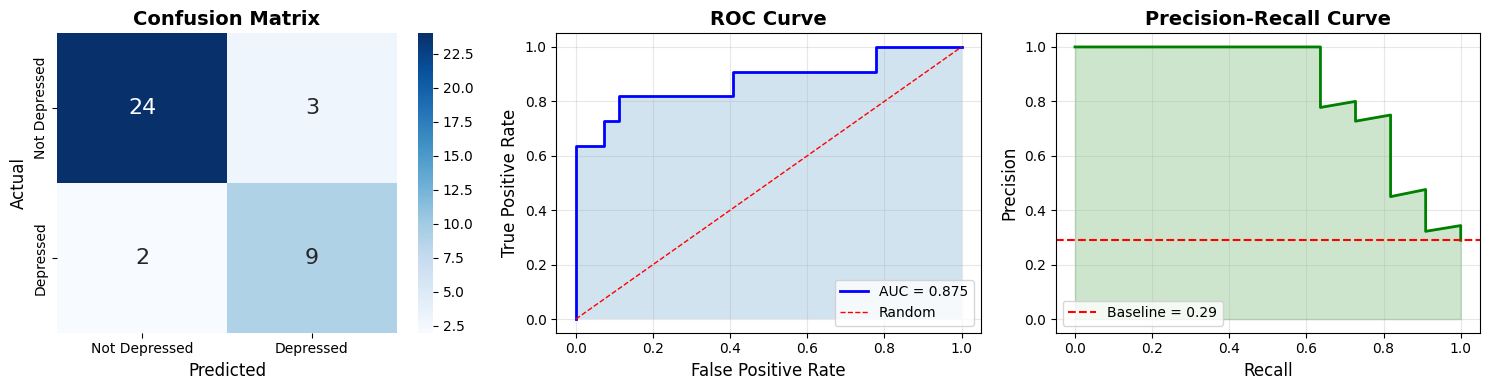

✓ Saved: confusion_matrix_and_curves.png


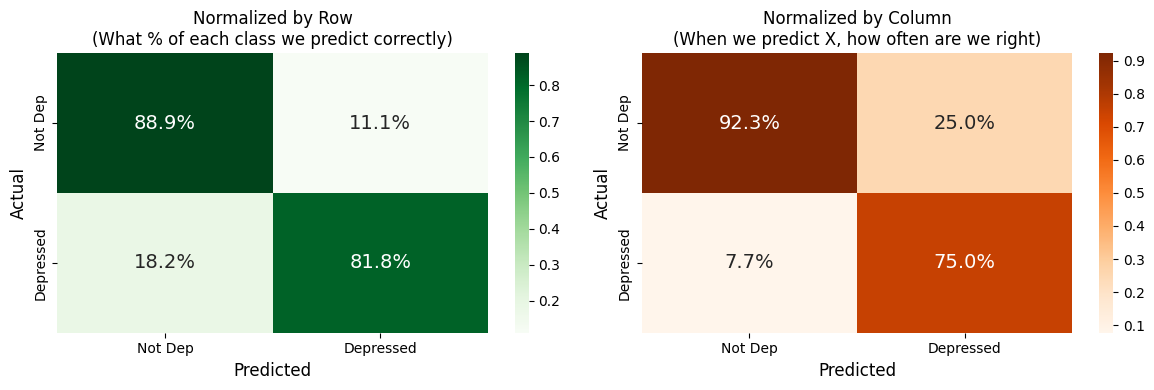

✓ Saved: confusion_matrix_normalized.png

📊 FINAL SUMMARY TABLE

     Metric    Value Percentage
   Accuracy 0.868421      86.8%
  Precision 0.750000      75.0%
     Recall 0.818182      81.8%
   F1 Score 0.782609      78.3%
Specificity 0.888889      88.9%
        NPV 0.923077      92.3%
    AUC-ROC 0.875421      87.5%

✓ Saved: final_metrics.csv

🏆 FINAL MODEL PERFORMANCE

┌─────────────────────────────────────────────────────────────────────┐
│                                                                     │
│   █████╗ ████████╗████████╗███████╗███╗   ██╗████████╗██╗ ██████╗  │
│  ██╔══██╗╚══██╔══╝╚══██╔══╝██╔════╝████╗  ██║╚══██╔══╝██║██╔═══██╗ │
│  ███████║   ██║      ██║   █████╗  ██╔██╗ ██║   ██║   ██║██║   ██║ │
│  ██╔══██║   ██║      ██║   ██╔══╝  ██║╚██╗██║   ██║   ██║██║   ██║ │
│  ██║  ██║   ██║      ██║   ███████╗██║ ╚████║   ██║   ██║╚██████╔╝ │
│  ╚═╝  ╚═╝   ╚═╝      ╚═╝   ╚══════╝╚═╝  ╚═══╝   ╚═╝   ╚═╝ ╚═════╝  │
│                                                    

In [ ]:
# ========================================
# CONFUSION MATRIX & DETAILED METRICS
# מטריצת בלבול ומטריקות מפורטות
# ========================================

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

OUTPUT_BASE = "/content/drive/MyDrive/try/"
RANDOM_STATE = 42

print("=" * 70)
print("📊 CONFUSION MATRIX & DETAILED METRICS")
print("=" * 70)

# ========================================
# Load Data & Model
# ========================================

print("\n📂 Loading data and model...")

# Load data
audio_df = pd.read_csv(f"{OUTPUT_BASE}metadata/combined_acoustic_features.csv", index_col=0)
audio_df.index = audio_df.index.astype(str)

text_df = pd.read_csv(f"{OUTPUT_BASE}metadata/llm_text_features_ALL.csv", index_col=0)
text_df.index = text_df.index.astype(str)

# Load model package
with open(f"{OUTPUT_BASE}models/final_attention_model.pkl", 'rb') as f:
    model_package = pickle.load(f)

# Features
AUDIO_FEATURES = model_package['audio_features']
TEXT_FEATURES = model_package['text_features']
threshold = model_package['threshold']

print(f"✓ Threshold: {threshold:.2f}")

# Common participants
common_pids = list(set(audio_df.index) & set(text_df.index))

X_audio = audio_df.loc[common_pids, AUDIO_FEATURES].values
X_text = text_df.loc[common_pids, TEXT_FEATURES].values
y = audio_df.loc[common_pids, 'label'].values.astype(int)

# Same split as training!
X_audio_train, X_audio_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_audio, X_text, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"✓ Test set: {len(y_test)} participants")

# Scale
audio_scaler = model_package['audio_scaler']
text_scaler = model_package['text_scaler']

X_audio_test_scaled = audio_scaler.transform(X_audio_test)
X_text_test_scaled = text_scaler.transform(X_text_test)

# ========================================
# Recreate Model & Predict
# ========================================

class SimpleAttentionFusion(nn.Module):
    def __init__(self, audio_dim, text_dim, hidden_dim=16, dropout=0.3):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(audio_dim + text_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, audio, text):
        combined = torch.cat([audio, text], dim=1)
        audio_weight = self.attention(combined)
        text_weight = 1 - audio_weight
        weighted_audio = audio_weight * audio
        weighted_text = text_weight * text
        weighted_combined = torch.cat([weighted_audio, weighted_text], dim=1)
        output = self.classifier(weighted_combined)
        return output, audio_weight

# Create model
best_params = model_package['best_params']
model = SimpleAttentionFusion(
    audio_dim=len(AUDIO_FEATURES),
    text_dim=len(TEXT_FEATURES),
    hidden_dim=best_params['hidden_dim'],
    dropout=best_params['dropout']
)
model.load_state_dict(model_package['model_state'])
model.eval()

# Predict
with torch.no_grad():
    outputs, attentions = model(
        torch.FloatTensor(X_audio_test_scaled),
        torch.FloatTensor(X_text_test_scaled)
    )
    y_prob = outputs.numpy().flatten()
    y_pred = (y_prob >= threshold).astype(int)

print(f"✓ Predictions generated")

# ========================================
# CONFUSION MATRIX
# ========================================

print("\n" + "=" * 70)
print("📊 CONFUSION MATRIX")
print("=" * 70)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"""
                        PREDICTED
                   ┌─────────┬─────────┐
                   │   Neg   │   Pos   │
        ┌──────────┼─────────┼─────────┤
        │   Neg    │   {tn:>3}   │   {fp:>3}   │  → {tn+fp:>3} Actually Not Depressed
 ACTUAL ├──────────┼─────────┼─────────┤
        │   Pos    │   {fn:>3}   │   {tp:>3}   │  → {fn+tp:>3} Actually Depressed
        └──────────┴─────────┴─────────┘
                       ↓         ↓
                   Pred Neg  Pred Pos
                     {tn+fn:>3}       {fp+tp:>3}
""")

# ========================================
# DETAILED METRICS
# ========================================

print("\n" + "=" * 70)
print("📈 DETAILED METRICS")
print("=" * 70)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = tn / (tn + fp)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
auc = roc_auc_score(y_test, y_prob)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  METRIC                    VALUE       INTERPRETATION              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Accuracy                  {accuracy:.1%}       Overall correctness          │
│                                                                     │
│  ─── For Depressed (Positive Class) ───                            │
│                                                                     │
│  Precision (PPV)           {precision:.1%}       Of predicted depressed,      │
│                                        how many are truly depressed │
│                                                                     │
│  Recall (Sensitivity)      {recall:.1%}       Of actual depressed,         │
│                                        how many did we catch        │
│                                                                     │
│  F1 Score                  {f1:.3f}       Harmonic mean of P & R       │
│                                                                     │
│  ─── For Not Depressed (Negative Class) ───                        │
│                                                                     │
│  Specificity (TNR)         {specificity:.1%}       Of actual not depressed,    │
│                                        how many correctly identified│
│                                                                     │
│  NPV                       {npv:.1%}       Of predicted not depressed, │
│                                        how many are truly not       │
│                                                                     │
│  ─── Overall ───                                                    │
│                                                                     │
│  AUC-ROC                   {auc:.3f}       Discrimination ability       │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

# ========================================
# CLINICAL INTERPRETATION
# ========================================

print("\n" + "=" * 70)
print("🏥 CLINICAL INTERPRETATION")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│  WHAT THE NUMBERS MEAN                                             │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ✅ TRUE POSITIVES (TP = {tp}):                                      │
│     Correctly identified as depressed                              │
│     → These patients get the help they need                        │
│                                                                     │
│  ❌ FALSE NEGATIVES (FN = {fn}):                                      │
│     Missed depression cases                                         │
│     → DANGEROUS: These patients might not get treatment            │
│                                                                     │
│  ⚠️  FALSE POSITIVES (FP = {fp}):                                      │
│     Incorrectly flagged as depressed                               │
│     → Less dangerous: Further evaluation will clarify              │
│                                                                     │
│  ✅ TRUE NEGATIVES (TN = {tn}):                                      │
│     Correctly identified as not depressed                          │
│     → These are correctly cleared                                  │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│  CLINICAL SUMMARY:                                                  │
│                                                                     │
│  • We catch {recall:.0%} of depressed patients (Recall = {recall:.3f})             │
│  • When we say "depressed", we're right {precision:.0%} of the time (Prec)    │
│  • Missing {fn} out of {tp+fn} depressed patients ({fn/(tp+fn)*100:.0f}% miss rate)          │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

# ========================================
# CLASSIFICATION REPORT
# ========================================

print("\n" + "=" * 70)
print("📋 SKLEARN CLASSIFICATION REPORT")
print("=" * 70)

print("\n" + classification_report(y_test, y_pred,
                                   target_names=['Not Depressed', 'Depressed']))

# ========================================
# VISUALIZATION
# ========================================

print("\n" + "=" * 70)
print("📊 CREATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Confusion Matrix Heatmap
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Depressed', 'Depressed'],
            yticklabels=['Not Depressed', 'Depressed'],
            annot_kws={'size': 16})
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 2. ROC Curve
ax2 = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc:.3f}')
ax2.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
ax2.fill_between(fpr, tpr, alpha=0.2)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = axes[2]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
ax3.plot(recall_curve, precision_curve, 'g-', linewidth=2)
ax3.fill_between(recall_curve, precision_curve, alpha=0.2, color='green')
ax3.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--',
            label=f'Baseline = {sum(y_test)/len(y_test):.2f}')
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='lower left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_BASE}results/confusion_matrix_and_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: confusion_matrix_and_curves.png")

# ========================================
# NORMALIZED CONFUSION MATRIX
# ========================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Normalized by row (Recall per class)
ax1 = axes[0]
cm_normalized_row = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized_row, annot=True, fmt='.1%', cmap='Greens', ax=ax1,
            xticklabels=['Not Dep', 'Depressed'],
            yticklabels=['Not Dep', 'Depressed'],
            annot_kws={'size': 14})
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_title('Normalized by Row\n(What % of each class we predict correctly)', fontsize=12)

# Normalized by column (Precision per prediction)
ax2 = axes[1]
cm_normalized_col = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
sns.heatmap(cm_normalized_col, annot=True, fmt='.1%', cmap='Oranges', ax=ax2,
            xticklabels=['Not Dep', 'Depressed'],
            yticklabels=['Not Dep', 'Depressed'],
            annot_kws={'size': 14})
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_title('Normalized by Column\n(When we predict X, how often are we right)', fontsize=12)

plt.tight_layout()
plt.savefig(f"{OUTPUT_BASE}results/confusion_matrix_normalized.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: confusion_matrix_normalized.png")

# ========================================
# SUMMARY TABLE
# ========================================

print("\n" + "=" * 70)
print("📊 FINAL SUMMARY TABLE")
print("=" * 70)

summary_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'NPV', 'AUC-ROC'],
    'Value': [accuracy, precision, recall, f1, specificity, npv, auc],
    'Percentage': [f'{accuracy:.1%}', f'{precision:.1%}', f'{recall:.1%}',
                   f'{f1:.1%}', f'{specificity:.1%}', f'{npv:.1%}', f'{auc:.1%}']
})

print(f"\n{summary_df.to_string(index=False)}")

# Save to CSV
summary_df.to_csv(f"{OUTPUT_BASE}results/final_metrics.csv", index=False)
print(f"\n✓ Saved: final_metrics.csv")

# ========================================
# FINAL DISPLAY
# ========================================

print("\n" + "=" * 70)
print("🏆 FINAL MODEL PERFORMANCE")
print("=" * 70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                                                                     │
│   █████╗ ████████╗████████╗███████╗███╗   ██╗████████╗██╗ ██████╗  │
│  ██╔══██╗╚══██╔══╝╚══██╔══╝██╔════╝████╗  ██║╚══██╔══╝██║██╔═══██╗ │
│  ███████║   ██║      ██║   █████╗  ██╔██╗ ██║   ██║   ██║██║   ██║ │
│  ██╔══██║   ██║      ██║   ██╔══╝  ██║╚██╗██║   ██║   ██║██║   ██║ │
│  ██║  ██║   ██║      ██║   ███████╗██║ ╚████║   ██║   ██║╚██████╔╝ │
│  ╚═╝  ╚═╝   ╚═╝      ╚═╝   ╚══════╝╚═╝  ╚═══╝   ╚═╝   ╚═╝ ╚═════╝  │
│                                                                     │
│             MULTIMODAL DEPRESSION DETECTION                        │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│                    ┌──────────────────────┐                        │
│                    │   F1 = {f1:.3f}          │                        │
│                    │   AUC = {auc:.3f}         │                        │
│                    └──────────────────────┘                        │
│                                                                     │
│   Confusion Matrix:                                                │
│                          Predicted                                  │
│                      Neg        Pos                                │
│            Neg   [ {tn:>3}    |   {fp:>3} ]                               │
│   Actual   ──────────────────────                                  │
│            Pos   [ {fn:>3}    |   {tp:>3} ]                               │
│                                                                     │
│   Key Metrics:                                                      │
│     • Precision: {precision:.1%}  (When we say depressed, we're right)    │
│     • Recall:    {recall:.1%}  (We catch this % of depressed)          │
│     • Accuracy:  {accuracy:.1%}  (Overall correctness)                  │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "=" * 70)
print("✅ CONFUSION MATRIX ANALYSIS COMPLETE!")
print("=" * 70)